<center> <h1>Проект "телекоммуникации"

Оператор связи «Ниединогоразрыва.ком» хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.

<b>Цель:</b>
Научиться прогнозировать отток клиентов. На тестовых данных получить метрику AUC_ROC с точностью >= 0.85.

**План решения задачи**

* Предварительный анализ данных: просто знакомимся с данными. Определяем таргет.
* Предобработка данных: смотрим на пропуски и дубликаты, и соответственно удаляем их или заполняем. Объединяем столбцы. Генерируем дополнительные признаки.
* Исследовательский анализ данных: строим корреляцию, графики, смотрим зависимость.
* Обучение моделей случайного леса и бустинга. Выбор наилучшей модели.
* Тестирование модели
* Вывод: описание проделанной работы и к чему мне удалось прийти.

# 1. Предварительный анализ данных

In [139]:
!pip install phik

In [140]:
!pip install catboost

In [141]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import phik
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, roc_curve, auc
from catboost import CatBoostClassifier
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import seaborn as sns

In [142]:
try:
    contract = pd.read_csv('contract_new.csv')
    internet = pd.read_csv('internet_new.csv')
    personal = pd.read_csv('personal_new.csv')
    phone = pd.read_csv('phone_new.csv')
except:
    contract = pd.read_csv('/datasets/contract_new.csv')
    internet = pd.read_csv('/datasets/internet_new.csv')
    personal = pd.read_csv('/datasets/personal_new.csv')
    phone = pd.read_csv('/datasets/phone_new.csv')

In [143]:
data_load = '2020-02-01'
RANDOM_STATE = 280823

In [144]:
contract.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5


In [145]:
internet.head()

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


In [146]:
personal.head()

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


In [147]:
phone.head()

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


In [148]:
def information(data):
    print('Количество пропусков:')
    print(data.isna().sum())
    print('Количество дубликатов:')
    print(data.duplicated().sum())
    print(data.shape)
    print(data['customerID'].nunique())

In [149]:
information(contract)

Количество пропусков:
customerID          0
BeginDate           0
EndDate             0
Type                0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
dtype: int64
Количество дубликатов:
0
(7043, 8)
7043


In [150]:
(contract['EndDate'] == 'No').sum()

5942

In [151]:
print('1101 пользователей уже ушли, а это', 1101*100/7043, '% от всех данных')

1101 пользователей уже ушли, а это 15.632542950447252 % от всех данных


In [152]:
information(internet)

Количество пропусков:
customerID          0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
dtype: int64
Количество дубликатов:
0
(5517, 8)
5517


In [153]:
information(personal)

Количество пропусков:
customerID       0
gender           0
SeniorCitizen    0
Partner          0
Dependents       0
dtype: int64
Количество дубликатов:
0
(7043, 5)
7043


In [154]:
information(phone)

Количество пропусков:
customerID       0
MultipleLines    0
dtype: int64
Количество дубликатов:
0
(6361, 2)
6361


# 2. Предобработка данных

In [155]:
contract = contract.merge(personal, on='customerID', how='left')
contract = contract.merge(phone, on='customerID', how='left')
contract = contract.merge(internet, on='customerID', how='left')

In [156]:
contract.shape

(7043, 20)

Генерируем дополнительные признаки и убираем, ставшие лишними, BeginDate и EndDate.

In [157]:
contract['target'] = 1
contract.loc[contract['EndDate']=='No','target'] = 0
contract.loc[contract['EndDate']=='No','EndDate'] = data_load
contract['BeginDate'] = pd.to_datetime(contract['BeginDate'], format='%Y-%m-%d')
contract['EndDate'] = pd.to_datetime(contract['EndDate'], format='%Y-%m-%d') 
duration = (contract['EndDate'] - contract['BeginDate'])/ np.timedelta64 ( 1 , 'M')
contract = contract.drop(['BeginDate', 'EndDate'], axis=1)

In [158]:
(contract['TotalCharges'] == ' ').sum()

11

In [159]:
contract.loc[contract['TotalCharges']==' ','TotalCharges'] = contract['MonthlyCharges']

In [160]:
contract['TotalCharges'] = contract['TotalCharges'].astype('float')

In [161]:
contract.isna().sum()

customerID             0
Type                   0
PaperlessBilling       0
PaymentMethod          0
MonthlyCharges         0
TotalCharges           0
gender                 0
SeniorCitizen          0
Partner                0
Dependents             0
MultipleLines        682
InternetService     1526
OnlineSecurity      1526
OnlineBackup        1526
DeviceProtection    1526
TechSupport         1526
StreamingTV         1526
StreamingMovies     1526
target                 0
dtype: int64

In [162]:
contract = contract.fillna('No')
contract['duration'] = duration

In [163]:
contract.isna().sum()

customerID          0
Type                0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
target              0
duration            0
dtype: int64

In [164]:
contract.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   Type              7043 non-null   object 
 2   PaperlessBilling  7043 non-null   object 
 3   PaymentMethod     7043 non-null   object 
 4   MonthlyCharges    7043 non-null   float64
 5   TotalCharges      7043 non-null   float64
 6   gender            7043 non-null   object 
 7   SeniorCitizen     7043 non-null   int64  
 8   Partner           7043 non-null   object 
 9   Dependents        7043 non-null   object 
 10  MultipleLines     7043 non-null   object 
 11  InternetService   7043 non-null   object 
 12  OnlineSecurity    7043 non-null   object 
 13  OnlineBackup      7043 non-null   object 
 14  DeviceProtection  7043 non-null   object 
 15  TechSupport       7043 non-null   object 
 16  StreamingTV       7043 non-null   object 


In [165]:
contract.head()

,customerID,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,target,duration
0,7590-VHVEG,Month-to-month,Yes,Electronic check,29.85,31.04,Female,0,Yes,No,No,DSL,No,Yes,No,No,No,No,0,1.018501
1,5575-GNVDE,One year,No,Mailed check,56.95,2071.84,Male,0,No,No,No,DSL,Yes,No,Yes,No,No,No,0,34.037660
2,3668-QPYBK,Month-to-month,Yes,Mailed check,53.85,226.17,Male,0,No,No,No,DSL,Yes,Yes,No,No,No,No,0,4.041151
3,7795-CFOCW,One year,No,Bank transfer (automatic),42.30,1960.60,Male,0,No,No,No,DSL,Yes,No,Yes,Yes,No,No,0,45.044046
4,9237-HQITU,Month-to-month,Yes,Electronic check,70.70,353.50,Female,0,No,No,No,Fiber optic,No,No,No,No,No,No,0,5.026797


## Выводы

Пропусков и дубликатов в предоставленных таблицах нет. Изменила значения на категории в столбцах Type, PaperlessBilling и PaymentMethod, а также добавила столбец target, в котором 0 значит пользователь пока не ушел, а 1 - ушел. Изменила тип данных в столбце BeginDate. Нашлось 11 строк в столбце TotalCharges со значением ' ', так как их совсем немного, я решила их удалить.

# Исследовательский анализ данных

In [166]:
contract.drop([ 'customerID'],
              axis=1).phik_matrix(interval_cols=['MonthlyCharges', 'TotalCharges', 'SeniorCitizen', 'target', 'duration'])

,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,target,duration
Type,1.000000,0.106860,0.277462,0.388444,0.468471,0.000000,0.086231,0.179736,0.147680,0.065498,0.505187,0.152145,0.098884,0.137610,0.179999,0.066961,0.069608,0.094015,0.634155
PaperlessBilling,0.106860,1.000000,0.370495,0.467812,0.203144,0.000000,0.242133,0.013218,0.172593,0.252972,0.231438,0.000000,0.196443,0.160796,0.055929,0.343524,0.325551,0.083398,0.026799
PaymentMethod,0.277462,0.370495,1.000000,0.399526,0.335175,0.000000,0.292725,0.243008,0.224903,0.339313,0.323886,0.262911,0.282475,0.306866,0.272101,0.377209,0.378907,0.214832,0.350964
MonthlyCharges,0.388444,0.467812,0.399526,1.000000,0.711029,0.008175,0.304985,0.203545,0.184366,0.675883,0.919002,0.551621,0.629541,0.667481,0.576525,0.835340,0.833307,0.226280,0.387727
TotalCharges,0.468471,0.203144,0.335175,0.711029,1.000000,0.000000,0.137707,0.381042,0.082134,0.572584,0.489674,0.521522,0.622643,0.641455,0.549866,0.642144,0.644671,0.304287,0.847414
gender,0.000000,0.000000,0.000000,0.008175,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.018397,0.009882,0.000000,0.000000,0.000000,0.000000,0.008581,0.000000
SeniorCitizen,0.086231,0.242133,0.292725,0.304985,0.137707,0.000000,1.000000,0.016992,0.324576,0.221313,0.160702,0.057028,0.102065,0.090686,0.092565,0.163120,0.186141,0.086159,0.063315
Partner,0.179736,0.013218,0.243008,0.203545,0.381042,0.000000,0.016992,1.000000,0.652122,0.220101,0.000000,0.221673,0.219223,0.238079,0.185993,0.193258,0.182011,0.226688,0.453688
Dependents,0.147680,0.172593,0.224903,0.184366,0.082134,0.000000,0.324576,0.652122,1.000000,0.033103,0.108463,0.124945,0.031533,0.010416,0.096912,0.017331,0.058999,0.046871,0.198729
MultipleLines,0.065498,0.252972,0.339313,0.675883,0.572584,0.000000,0.221313,0.220101,0.033103,1.000000,0.225383,0.151886,0.311403,0.309757,0.155739,0.392239,0.394553,0.261237,0.398222


Сильная корреляция общих трат с остальными признаками, а также все услуги оператора имеют сильную корреляцию > 0.55, тип тарифа и время = 0.63, партнер и наличие иждивенца = 0.65.

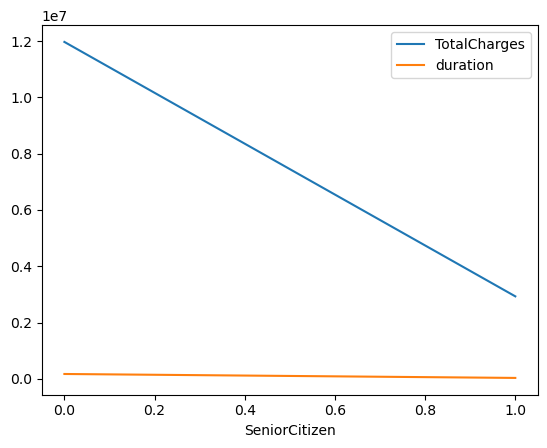

In [167]:
contract.groupby(['SeniorCitizen'])[['TotalCharges', 'duration']].sum().plot();

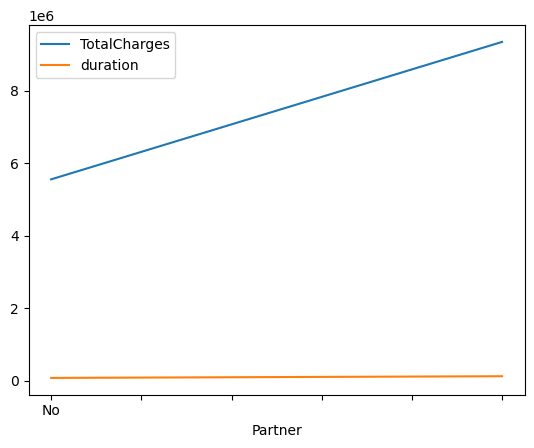

In [168]:
contract.groupby(['Partner'])[['TotalCharges', 'duration']].sum().plot();

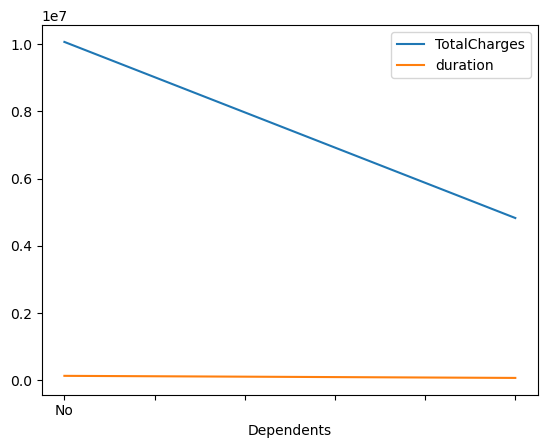

In [169]:
contract.groupby(['Dependents'])[['TotalCharges', 'duration']].sum().plot();

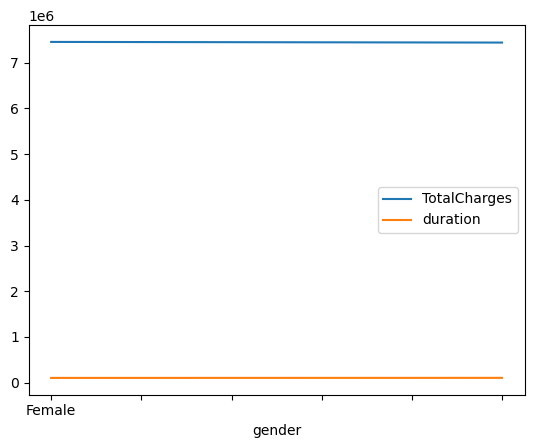

In [170]:
contract.groupby(['gender'])[['TotalCharges', 'duration']].sum().plot();

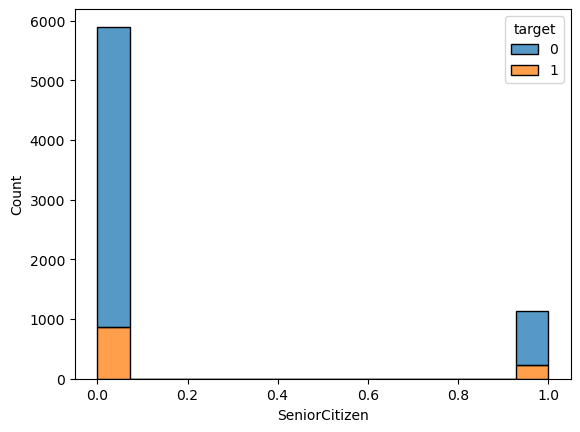

In [171]:
sns.histplot(contract, x = 'SeniorCitizen', hue = 'target', multiple = 'stack');

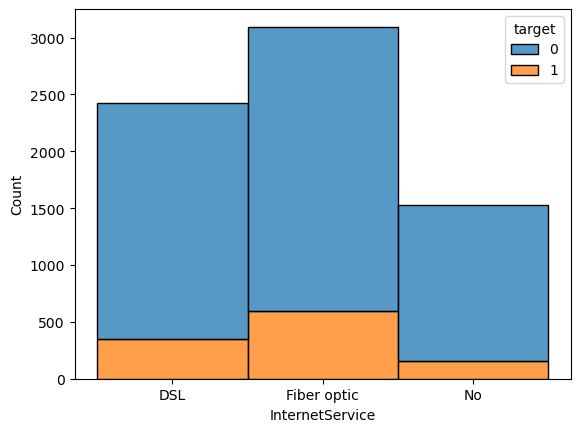

In [172]:
sns.histplot(contract, x = 'InternetService', hue = 'target', multiple = 'stack');

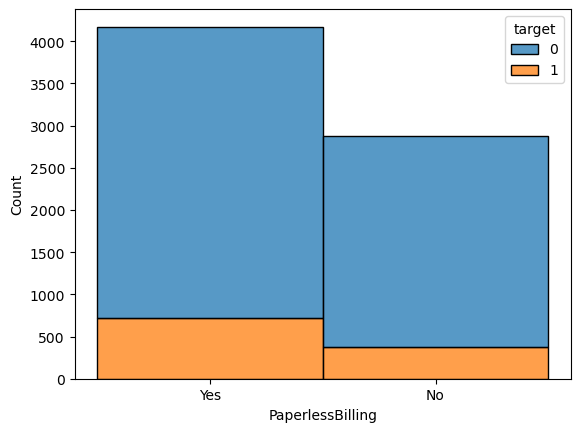

In [173]:
sns.histplot(contract, x = 'PaperlessBilling', hue = 'target', multiple = 'stack');

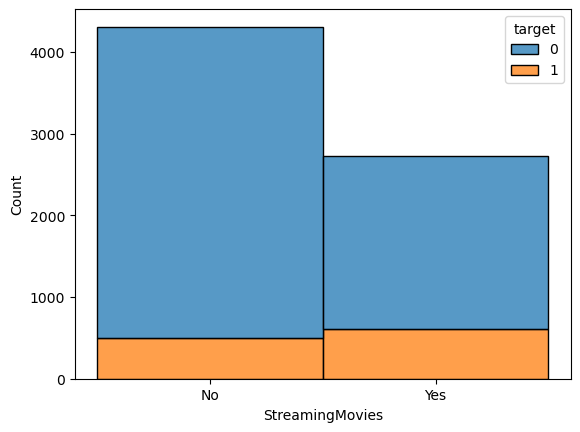

In [174]:
sns.histplot(contract, x = 'StreamingMovies', hue = 'target', multiple = 'stack');

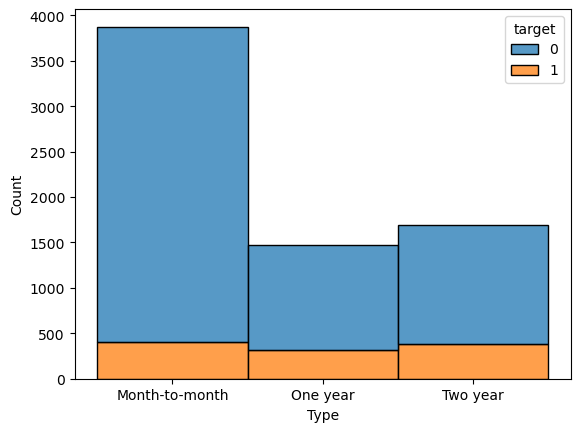

In [175]:
sns.histplot(contract, x = 'Type', hue = 'target', multiple = 'stack');

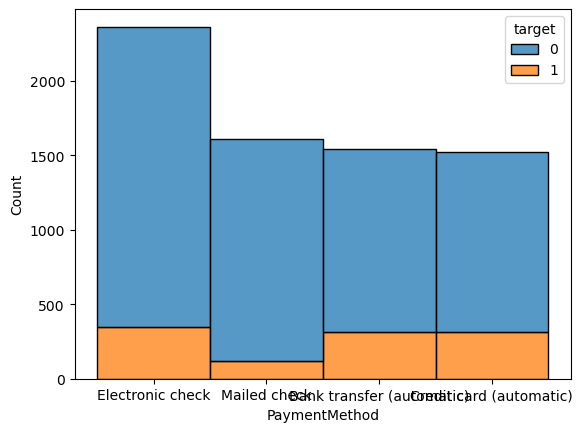

In [176]:
sns.histplot(contract, x = 'PaymentMethod', hue = 'target', multiple = 'stack');

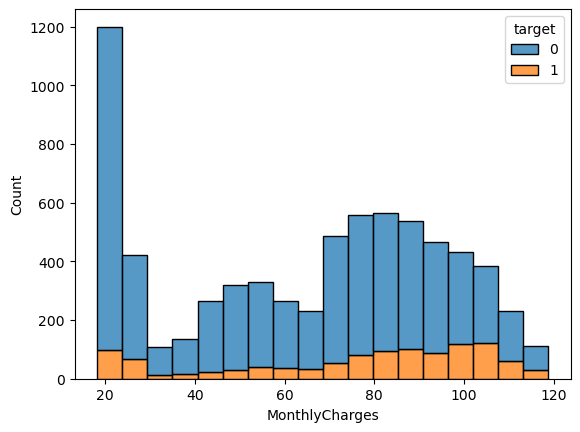

In [177]:
sns.histplot(contract, x = 'MonthlyCharges', hue = 'target', multiple = 'stack');

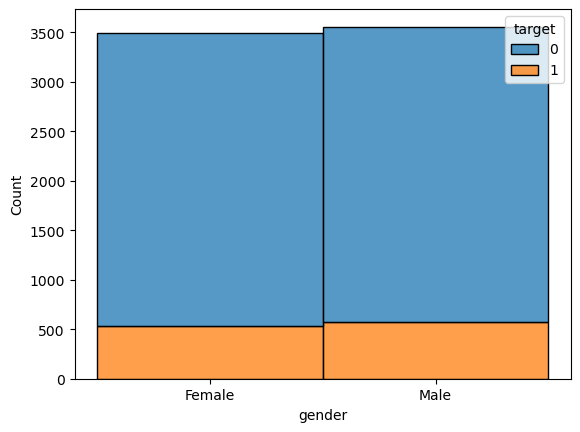

In [178]:
sns.histplot(contract, x = 'gender', hue = 'target', multiple = 'stack');

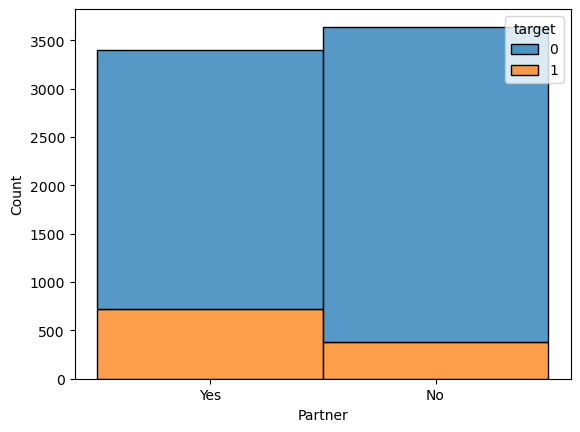

In [179]:
sns.histplot(contract, x = 'Partner', hue = 'target', multiple = 'stack');

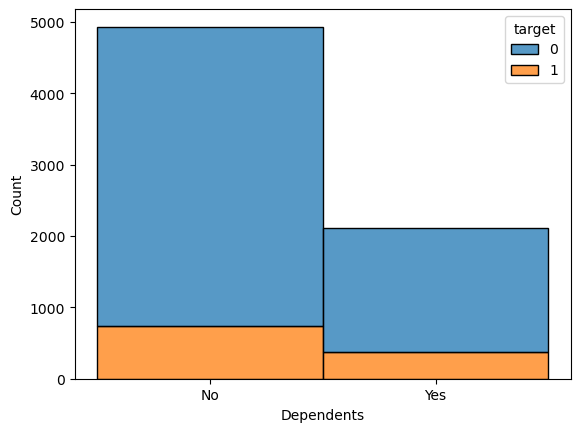

In [180]:
sns.histplot(contract, x = 'Dependents', hue = 'target', multiple = 'stack');

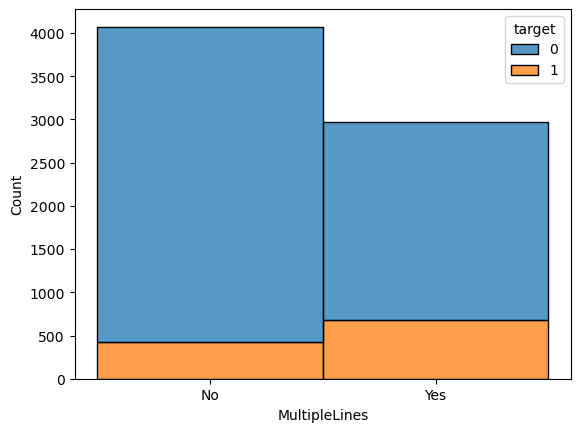

In [181]:
sns.histplot(contract, x = 'MultipleLines', hue = 'target', multiple = 'stack');

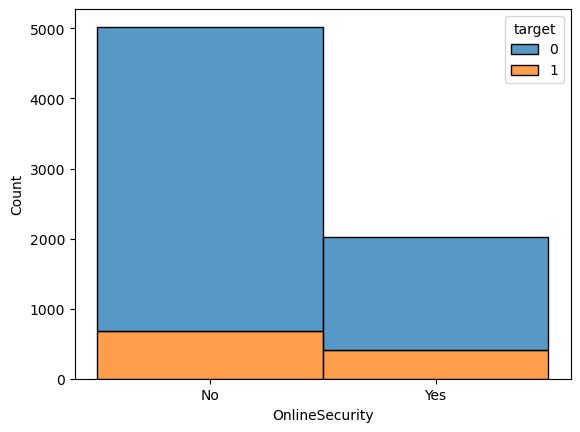

In [182]:
sns.histplot(contract, x = 'OnlineSecurity', hue = 'target', multiple = 'stack');

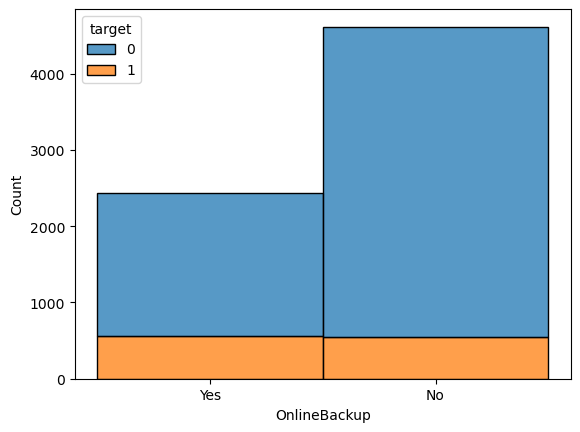

In [183]:
sns.histplot(contract, x = 'OnlineBackup', hue = 'target', multiple = 'stack');

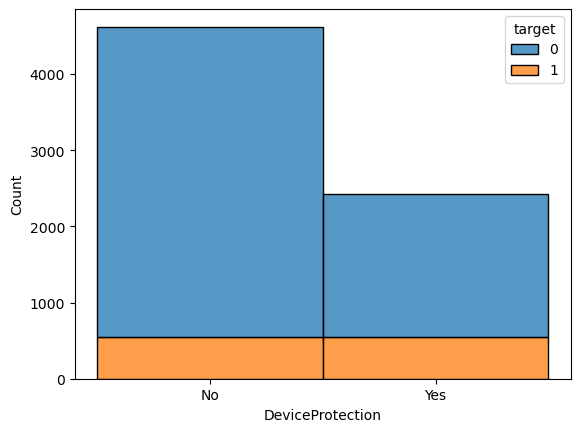

In [184]:
sns.histplot(contract, x = 'DeviceProtection', hue = 'target', multiple = 'stack');

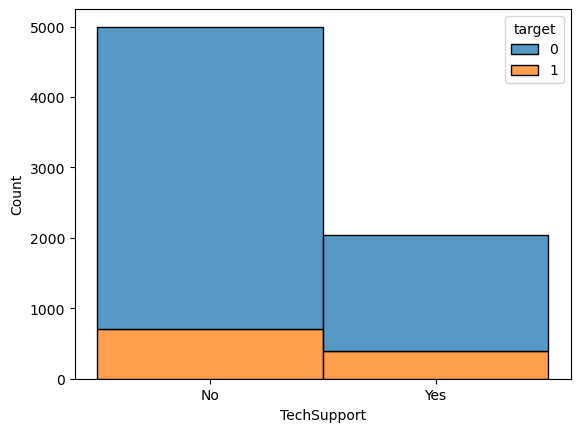

In [185]:
sns.histplot(contract, x = 'TechSupport', hue = 'target', multiple = 'stack');

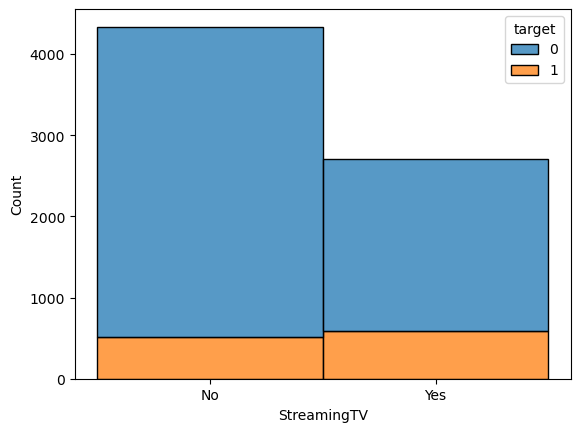

In [186]:
sns.histplot(contract, x = 'StreamingTV', hue = 'target', multiple = 'stack');

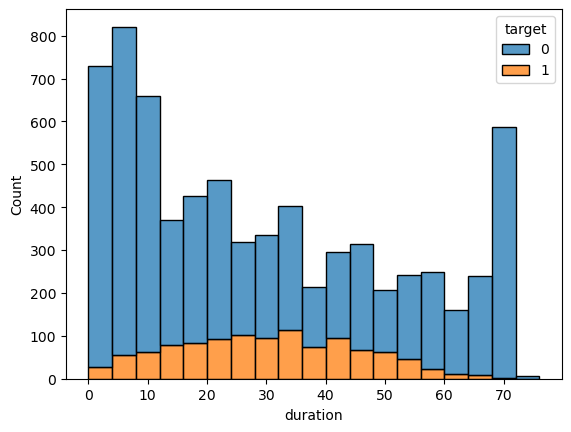

In [187]:
sns.histplot(contract, x = 'duration', hue = 'target', multiple = 'stack');

Наблюдается зависимость между возрастом и тратами с длительностью, также на траты и длительность влияет наличие партнера, наличие иждивенца ведет к уменьшению значений, а пол никак не влияет. Пенсионеры и люди не имеющие супруга реже отказываются от услуг. Клиента с оптоволокном, безналичным расчетом и наличием возможности ведения параллельных линий чеще отказываются. Способ оплаты также влияет на отток клиентов.

# Обучение моделей

In [188]:
target = contract['target']
features = contract.drop(['customerID', 'target','TotalCharges', 'gender'], axis=1)

In [189]:
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.25,
                                                                            random_state=RANDOM_STATE, stratify=target)

In [190]:
cat_columns = ['PaymentMethod','SeniorCitizen', 'Dependents', 'InternetService',
                          'StreamingTV','StreamingMovies', 'Type', 'MultipleLines','DeviceProtection',
                         'OnlineBackup','Partner','TechSupport','OnlineSecurity','PaperlessBilling']
numeric = ['MonthlyCharges', 'duration']

In [191]:
X_train_ridge = features_train.copy()
X_test_ridge = features_test.copy()
ohe_features_ridge = features_train.select_dtypes(include='object').columns.to_list()

num_features = features_train.select_dtypes(exclude='object').columns.to_list()
num_features.remove('SeniorCitizen')

encoder_ohe = OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False)

#обучаем энкодер на заданных категориальных признаках тренировочной выборки

encoder_ohe.fit(X_train_ridge[ohe_features_ridge])

#добавляем закодированные признаки в X_train_ohe
#encoder_ohe.get_feature_names_out() позволяет получить названия колонок
X_train_ridge[
    encoder_ohe.get_feature_names_out()
] = encoder_ohe.transform(X_train_ridge[ohe_features_ridge])

#удаляем незакодированные категориальные признаки (изначальные колонки)
X_train_ridge = X_train_ridge.drop(ohe_features_ridge, axis=1)

#создаём скелер
scaler = StandardScaler()

#обучаем его на численных признаках тренировочной выборки, трансформируем её же
X_train_ridge[num_features] = scaler.fit_transform(X_train_ridge[num_features])

#смотрим на результат
X_train_ridge.head()

,MonthlyCharges,SeniorCitizen,duration,Type_One year,Type_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,Partner_Yes,Dependents_Yes,MultipleLines_Yes,InternetService_Fiber optic,InternetService_No,OnlineSecurity_Yes,OnlineBackup_Yes,DeviceProtection_Yes,TechSupport_Yes,StreamingTV_Yes,StreamingMovies_Yes
3705,-0.112982,0,1.770270,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
710,-1.505565,0,-1.085132,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
6962,1.213049,1,-0.685170,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0
5637,0.847018,0,1.546116,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
277,0.005146,1,-0.370182,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0


In [192]:
from sklearn.linear_model import Ridge

In [193]:
model =  Ridge(random_state=RANDOM_STATE)
grid_ridge = GridSearchCV(model, param_grid={'alpha': np.arange(0, 0.5, 0.02)}, 
                    scoring='roc_auc', cv=5)
grid_ridge.fit(X_train_ridge, target_train)
grid_ridge.best_score_

0.7520077074307562

In [194]:
ohe_enc = OneHotEncoder(drop='first', handle_unknown='ignore')
ohe_enc.fit(features_train[cat_columns])
new_columns = ohe_enc.get_feature_names_out(cat_columns)
features_train_ohe = pd.DataFrame(ohe_enc.transform(features_train[cat_columns]).toarray(),
                                 columns=new_columns, index=features_train.index)
features_train_ohe = features_train_ohe.join(features_train[numeric])

In [195]:
features_test_ohe = pd.DataFrame(ohe_enc.transform(features_test[cat_columns]).toarray(),
                                 columns=new_columns, index=features_test.index)
features_test_ohe = features_test_ohe.join(features_test[numeric])

In [196]:
features_train_ohe.head()

,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,SeniorCitizen_1,Dependents_Yes,InternetService_Fiber optic,InternetService_No,StreamingTV_Yes,StreamingMovies_Yes,Type_One year,Type_Two year,MultipleLines_Yes,DeviceProtection_Yes,OnlineBackup_Yes,Partner_Yes,TechSupport_Yes,OnlineSecurity_Yes,PaperlessBilling_Yes,MonthlyCharges,duration
3705,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,61.40,69.060966
710,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,19.55,5.026797
6962,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,101.25,13.996181
5637,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,90.25,64.034169
277,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,64.95,21.059981


In [197]:
features_train_ohe.shape, features_test_ohe.shape

((5282, 20), (1761, 20))

In [198]:
(features_train_ohe.columns != features_test_ohe.columns).sum()

0

In [205]:
%%time
model =  RandomForestClassifier(random_state=RANDOM_STATE, class_weight='balanced')
grid = GridSearchCV(model, param_grid={'max_depth': range(5, 10), 'n_estimators': range(50, 251, 100)}, 
                    scoring='roc_auc', cv=5)
grid.fit(features_train_ohe, target_train)

Wall time: 37.8 s


GridSearchCV(cv=5,
             estimator=RandomForestClassifier(class_weight='balanced',
                                              random_state=280823),
             param_grid={'max_depth': range(5, 10),
                         'n_estimators': range(50, 251, 100)},
             scoring='roc_auc')

In [206]:
grid.best_score_, grid.best_params_

(0.8185828204769795, {'max_depth': 8, 'n_estimators': 250})

In [208]:
%%time
params = {
    'loss_function' : 'Logloss',
    'random_state' : RANDOM_STATE
    }
model = CatBoostClassifier(params)
grid_cat = GridSearchCV(model, param_grid={'learning_rate': np.arange(0.05, 0.31, 0.05), 'depth': [6, 7, 8, 9],
                                           'iterations': [300]}, scoring='roc_auc', cv=5)
grid_cat.fit(features_train, target_train, cat_features=cat_columns)
# 40min 8s

0:	learn: 0.6501629	total: 29.9ms	remaining: 8.95s
1:	learn: 0.6152811	total: 78.1ms	remaining: 11.6s
2:	learn: 0.5814401	total: 123ms	remaining: 12.2s
3:	learn: 0.5538222	total: 166ms	remaining: 12.2s
4:	learn: 0.5263836	total: 205ms	remaining: 12.1s
5:	learn: 0.5043873	total: 242ms	remaining: 11.8s
6:	learn: 0.4853126	total: 284ms	remaining: 11.9s
7:	learn: 0.4731784	total: 306ms	remaining: 11.2s
8:	learn: 0.4570800	total: 348ms	remaining: 11.3s
9:	learn: 0.4434187	total: 405ms	remaining: 11.7s
10:	learn: 0.4330660	total: 447ms	remaining: 11.7s
11:	learn: 0.4237548	total: 492ms	remaining: 11.8s
12:	learn: 0.4158305	total: 534ms	remaining: 11.8s
13:	learn: 0.4086101	total: 575ms	remaining: 11.8s
14:	learn: 0.4012070	total: 629ms	remaining: 12s
15:	learn: 0.3943459	total: 670ms	remaining: 11.9s
16:	learn: 0.3875540	total: 714ms	remaining: 11.9s
17:	learn: 0.3849245	total: 724ms	remaining: 11.3s
18:	learn: 0.3797709	total: 765ms	remaining: 11.3s
19:	learn: 0.3739991	total: 806ms	remaini

161:	learn: 0.2809381	total: 7.82s	remaining: 6.66s
162:	learn: 0.2806860	total: 7.86s	remaining: 6.61s
163:	learn: 0.2799993	total: 7.9s	remaining: 6.55s
164:	learn: 0.2797790	total: 7.94s	remaining: 6.5s
165:	learn: 0.2789220	total: 7.99s	remaining: 6.45s
166:	learn: 0.2788745	total: 8.03s	remaining: 6.39s
167:	learn: 0.2788667	total: 8.06s	remaining: 6.33s
168:	learn: 0.2783082	total: 8.1s	remaining: 6.28s
169:	learn: 0.2779155	total: 8.14s	remaining: 6.23s
170:	learn: 0.2776584	total: 8.19s	remaining: 6.17s
171:	learn: 0.2776206	total: 8.23s	remaining: 6.12s
172:	learn: 0.2775571	total: 8.27s	remaining: 6.07s
173:	learn: 0.2772557	total: 8.31s	remaining: 6.02s
174:	learn: 0.2765503	total: 8.37s	remaining: 5.97s
175:	learn: 0.2762006	total: 8.42s	remaining: 5.93s
176:	learn: 0.2760047	total: 8.47s	remaining: 5.89s
177:	learn: 0.2753306	total: 8.52s	remaining: 5.84s
178:	learn: 0.2750788	total: 8.59s	remaining: 5.8s
179:	learn: 0.2746899	total: 8.65s	remaining: 5.77s
180:	learn: 0.27

23:	learn: 0.3712261	total: 1.18s	remaining: 13.5s
24:	learn: 0.3667181	total: 1.24s	remaining: 13.7s
25:	learn: 0.3641867	total: 1.3s	remaining: 13.8s
26:	learn: 0.3603544	total: 1.36s	remaining: 13.7s
27:	learn: 0.3572588	total: 1.41s	remaining: 13.7s
28:	learn: 0.3547929	total: 1.47s	remaining: 13.7s
29:	learn: 0.3523044	total: 1.52s	remaining: 13.7s
30:	learn: 0.3497003	total: 1.58s	remaining: 13.7s
31:	learn: 0.3475062	total: 1.65s	remaining: 13.8s
32:	learn: 0.3464067	total: 1.71s	remaining: 13.8s
33:	learn: 0.3446156	total: 1.77s	remaining: 13.9s
34:	learn: 0.3432017	total: 1.84s	remaining: 13.9s
35:	learn: 0.3415212	total: 1.9s	remaining: 13.9s
36:	learn: 0.3406538	total: 1.96s	remaining: 14s
37:	learn: 0.3391877	total: 2.02s	remaining: 13.9s
38:	learn: 0.3373284	total: 2.08s	remaining: 13.9s
39:	learn: 0.3360757	total: 2.14s	remaining: 13.9s
40:	learn: 0.3352641	total: 2.21s	remaining: 13.9s
41:	learn: 0.3341484	total: 2.27s	remaining: 13.9s
42:	learn: 0.3329414	total: 2.32s	r

183:	learn: 0.2808929	total: 10.1s	remaining: 6.4s
184:	learn: 0.2804618	total: 10.2s	remaining: 6.35s
185:	learn: 0.2803445	total: 10.3s	remaining: 6.31s
186:	learn: 0.2797153	total: 10.4s	remaining: 6.26s
187:	learn: 0.2794492	total: 10.4s	remaining: 6.21s
188:	learn: 0.2792382	total: 10.5s	remaining: 6.15s
189:	learn: 0.2791309	total: 10.5s	remaining: 6.09s
190:	learn: 0.2788252	total: 10.6s	remaining: 6.02s
191:	learn: 0.2787603	total: 10.6s	remaining: 5.97s
192:	learn: 0.2782036	total: 10.7s	remaining: 5.92s
193:	learn: 0.2775703	total: 10.7s	remaining: 5.87s
194:	learn: 0.2773345	total: 10.8s	remaining: 5.82s
195:	learn: 0.2769731	total: 10.9s	remaining: 5.77s
196:	learn: 0.2769051	total: 10.9s	remaining: 5.72s
197:	learn: 0.2762912	total: 11s	remaining: 5.67s
198:	learn: 0.2758207	total: 11.1s	remaining: 5.61s
199:	learn: 0.2753727	total: 11.1s	remaining: 5.56s
200:	learn: 0.2748466	total: 11.2s	remaining: 5.51s
201:	learn: 0.2742236	total: 11.2s	remaining: 5.46s
202:	learn: 0.2

44:	learn: 0.3295171	total: 2.44s	remaining: 13.8s
45:	learn: 0.3281404	total: 2.5s	remaining: 13.8s
46:	learn: 0.3271861	total: 2.56s	remaining: 13.8s
47:	learn: 0.3271393	total: 2.58s	remaining: 13.6s
48:	learn: 0.3257175	total: 2.64s	remaining: 13.5s
49:	learn: 0.3247230	total: 2.7s	remaining: 13.5s
50:	learn: 0.3244087	total: 2.76s	remaining: 13.5s
51:	learn: 0.3237822	total: 2.83s	remaining: 13.5s
52:	learn: 0.3231205	total: 2.88s	remaining: 13.4s
53:	learn: 0.3222178	total: 2.95s	remaining: 13.4s
54:	learn: 0.3212174	total: 3.01s	remaining: 13.4s
55:	learn: 0.3201661	total: 3.07s	remaining: 13.4s
56:	learn: 0.3195327	total: 3.14s	remaining: 13.4s
57:	learn: 0.3191075	total: 3.17s	remaining: 13.2s
58:	learn: 0.3184453	total: 3.24s	remaining: 13.2s
59:	learn: 0.3177658	total: 3.3s	remaining: 13.2s
60:	learn: 0.3168801	total: 3.36s	remaining: 13.2s
61:	learn: 0.3160591	total: 3.43s	remaining: 13.2s
62:	learn: 0.3156989	total: 3.49s	remaining: 13.1s
63:	learn: 0.3152146	total: 3.55s	

204:	learn: 0.2676229	total: 9.79s	remaining: 4.54s
205:	learn: 0.2672432	total: 9.83s	remaining: 4.49s
206:	learn: 0.2671974	total: 9.88s	remaining: 4.44s
207:	learn: 0.2669433	total: 9.9s	remaining: 4.38s
208:	learn: 0.2669327	total: 9.93s	remaining: 4.32s
209:	learn: 0.2667338	total: 9.97s	remaining: 4.27s
210:	learn: 0.2661811	total: 10s	remaining: 4.22s
211:	learn: 0.2656615	total: 10.1s	remaining: 4.17s
212:	learn: 0.2654577	total: 10.1s	remaining: 4.12s
213:	learn: 0.2651151	total: 10.1s	remaining: 4.07s
214:	learn: 0.2650630	total: 10.2s	remaining: 4.02s
215:	learn: 0.2649225	total: 10.2s	remaining: 3.97s
216:	learn: 0.2643748	total: 10.3s	remaining: 3.93s
217:	learn: 0.2637626	total: 10.3s	remaining: 3.88s
218:	learn: 0.2631326	total: 10.4s	remaining: 3.83s
219:	learn: 0.2628815	total: 10.4s	remaining: 3.79s
220:	learn: 0.2626571	total: 10.5s	remaining: 3.74s
221:	learn: 0.2623595	total: 10.5s	remaining: 3.69s
222:	learn: 0.2615263	total: 10.5s	remaining: 3.64s
223:	learn: 0.2

64:	learn: 0.3180733	total: 3.55s	remaining: 12.8s
65:	learn: 0.3177860	total: 3.61s	remaining: 12.8s
66:	learn: 0.3176016	total: 3.65s	remaining: 12.7s
67:	learn: 0.3171068	total: 3.69s	remaining: 12.6s
68:	learn: 0.3163806	total: 3.75s	remaining: 12.6s
69:	learn: 0.3158316	total: 3.82s	remaining: 12.6s
70:	learn: 0.3154174	total: 3.88s	remaining: 12.5s
71:	learn: 0.3149450	total: 3.95s	remaining: 12.5s
72:	learn: 0.3146811	total: 4.01s	remaining: 12.5s
73:	learn: 0.3143844	total: 4.07s	remaining: 12.4s
74:	learn: 0.3141498	total: 4.13s	remaining: 12.4s
75:	learn: 0.3137129	total: 4.17s	remaining: 12.3s
76:	learn: 0.3129446	total: 4.23s	remaining: 12.3s
77:	learn: 0.3129192	total: 4.29s	remaining: 12.2s
78:	learn: 0.3125323	total: 4.36s	remaining: 12.2s
79:	learn: 0.3116877	total: 4.42s	remaining: 12.2s
80:	learn: 0.3114470	total: 4.48s	remaining: 12.1s
81:	learn: 0.3113232	total: 4.54s	remaining: 12.1s
82:	learn: 0.3108293	total: 4.59s	remaining: 12s
83:	learn: 0.3099436	total: 4.64s

224:	learn: 0.2693938	total: 12.4s	remaining: 4.13s
225:	learn: 0.2692412	total: 12.4s	remaining: 4.07s
226:	learn: 0.2686743	total: 12.5s	remaining: 4.02s
227:	learn: 0.2686394	total: 12.6s	remaining: 3.96s
228:	learn: 0.2681393	total: 12.6s	remaining: 3.91s
229:	learn: 0.2680696	total: 12.7s	remaining: 3.86s
230:	learn: 0.2679406	total: 12.7s	remaining: 3.81s
231:	learn: 0.2675609	total: 12.8s	remaining: 3.75s
232:	learn: 0.2675318	total: 12.9s	remaining: 3.7s
233:	learn: 0.2672885	total: 12.9s	remaining: 3.64s
234:	learn: 0.2670181	total: 13s	remaining: 3.58s
235:	learn: 0.2668005	total: 13s	remaining: 3.53s
236:	learn: 0.2660770	total: 13.1s	remaining: 3.48s
237:	learn: 0.2656738	total: 13.1s	remaining: 3.42s
238:	learn: 0.2652688	total: 13.2s	remaining: 3.37s
239:	learn: 0.2651390	total: 13.3s	remaining: 3.31s
240:	learn: 0.2645475	total: 13.3s	remaining: 3.26s
241:	learn: 0.2644747	total: 13.4s	remaining: 3.2s
242:	learn: 0.2644346	total: 13.4s	remaining: 3.15s
243:	learn: 0.2643

86:	learn: 0.3016130	total: 4.86s	remaining: 11.9s
87:	learn: 0.3009937	total: 4.92s	remaining: 11.8s
88:	learn: 0.3008545	total: 4.98s	remaining: 11.8s
89:	learn: 0.3004878	total: 5.03s	remaining: 11.7s
90:	learn: 0.3003482	total: 5.09s	remaining: 11.7s
91:	learn: 0.3001786	total: 5.15s	remaining: 11.6s
92:	learn: 0.3001312	total: 5.18s	remaining: 11.5s
93:	learn: 0.2995300	total: 5.24s	remaining: 11.5s
94:	learn: 0.2991897	total: 5.31s	remaining: 11.5s
95:	learn: 0.2990559	total: 5.37s	remaining: 11.4s
96:	learn: 0.2987297	total: 5.43s	remaining: 11.4s
97:	learn: 0.2987117	total: 5.47s	remaining: 11.3s
98:	learn: 0.2984396	total: 5.5s	remaining: 11.2s
99:	learn: 0.2980046	total: 5.57s	remaining: 11.1s
100:	learn: 0.2977798	total: 5.63s	remaining: 11.1s
101:	learn: 0.2975235	total: 5.69s	remaining: 11.1s
102:	learn: 0.2974758	total: 5.72s	remaining: 10.9s
103:	learn: 0.2970968	total: 5.75s	remaining: 10.8s
104:	learn: 0.2967011	total: 5.82s	remaining: 10.8s
105:	learn: 0.2967008	total

245:	learn: 0.2508089	total: 14s	remaining: 3.08s
246:	learn: 0.2501321	total: 14.1s	remaining: 3.02s
247:	learn: 0.2497244	total: 14.1s	remaining: 2.96s
248:	learn: 0.2495147	total: 14.2s	remaining: 2.9s
249:	learn: 0.2489019	total: 14.2s	remaining: 2.85s
250:	learn: 0.2487632	total: 14.3s	remaining: 2.79s
251:	learn: 0.2485703	total: 14.4s	remaining: 2.74s
252:	learn: 0.2483669	total: 14.4s	remaining: 2.68s
253:	learn: 0.2477029	total: 14.5s	remaining: 2.63s
254:	learn: 0.2473912	total: 14.6s	remaining: 2.57s
255:	learn: 0.2473795	total: 14.6s	remaining: 2.51s
256:	learn: 0.2470080	total: 14.7s	remaining: 2.45s
257:	learn: 0.2463282	total: 14.7s	remaining: 2.4s
258:	learn: 0.2460279	total: 14.8s	remaining: 2.34s
259:	learn: 0.2456906	total: 14.8s	remaining: 2.28s
260:	learn: 0.2452576	total: 14.9s	remaining: 2.22s
261:	learn: 0.2438065	total: 14.9s	remaining: 2.17s
262:	learn: 0.2435922	total: 15s	remaining: 2.11s
263:	learn: 0.2432750	total: 15s	remaining: 2.05s
264:	learn: 0.242560

108:	learn: 0.2632192	total: 5.75s	remaining: 10.1s
109:	learn: 0.2617735	total: 5.81s	remaining: 10s
110:	learn: 0.2609275	total: 5.85s	remaining: 9.96s
111:	learn: 0.2608470	total: 5.89s	remaining: 9.89s
112:	learn: 0.2589824	total: 5.94s	remaining: 9.82s
113:	learn: 0.2578984	total: 5.99s	remaining: 9.78s
114:	learn: 0.2569938	total: 6.05s	remaining: 9.74s
115:	learn: 0.2566983	total: 6.12s	remaining: 9.7s
116:	learn: 0.2563499	total: 6.18s	remaining: 9.66s
117:	learn: 0.2552186	total: 6.24s	remaining: 9.62s
118:	learn: 0.2550974	total: 6.3s	remaining: 9.59s
119:	learn: 0.2540846	total: 6.35s	remaining: 9.53s
120:	learn: 0.2536024	total: 6.4s	remaining: 9.46s
121:	learn: 0.2532944	total: 6.45s	remaining: 9.41s
122:	learn: 0.2529094	total: 6.51s	remaining: 9.38s
123:	learn: 0.2519070	total: 6.58s	remaining: 9.34s
124:	learn: 0.2507683	total: 6.64s	remaining: 9.3s
125:	learn: 0.2501432	total: 6.71s	remaining: 9.26s
126:	learn: 0.2489257	total: 6.77s	remaining: 9.22s
127:	learn: 0.2483

270:	learn: 0.1707259	total: 15.6s	remaining: 1.67s
271:	learn: 0.1702437	total: 15.6s	remaining: 1.61s
272:	learn: 0.1698070	total: 15.7s	remaining: 1.55s
273:	learn: 0.1695488	total: 15.8s	remaining: 1.5s
274:	learn: 0.1690302	total: 15.8s	remaining: 1.44s
275:	learn: 0.1686653	total: 15.9s	remaining: 1.38s
276:	learn: 0.1682570	total: 15.9s	remaining: 1.32s
277:	learn: 0.1680099	total: 16s	remaining: 1.27s
278:	learn: 0.1675545	total: 16.1s	remaining: 1.21s
279:	learn: 0.1672351	total: 16.1s	remaining: 1.15s
280:	learn: 0.1670854	total: 16.2s	remaining: 1.09s
281:	learn: 0.1668673	total: 16.2s	remaining: 1.04s
282:	learn: 0.1667573	total: 16.3s	remaining: 979ms
283:	learn: 0.1664263	total: 16.4s	remaining: 922ms
284:	learn: 0.1662816	total: 16.4s	remaining: 865ms
285:	learn: 0.1662349	total: 16.5s	remaining: 807ms
286:	learn: 0.1657850	total: 16.5s	remaining: 749ms
287:	learn: 0.1654848	total: 16.6s	remaining: 691ms
288:	learn: 0.1651652	total: 16.7s	remaining: 634ms
289:	learn: 0.1

134:	learn: 0.2553197	total: 6.4s	remaining: 7.82s
135:	learn: 0.2552420	total: 6.46s	remaining: 7.79s
136:	learn: 0.2547062	total: 6.52s	remaining: 7.76s
137:	learn: 0.2545842	total: 6.59s	remaining: 7.73s
138:	learn: 0.2524554	total: 6.64s	remaining: 7.69s
139:	learn: 0.2517660	total: 6.71s	remaining: 7.67s
140:	learn: 0.2516662	total: 6.76s	remaining: 7.62s
141:	learn: 0.2511886	total: 6.81s	remaining: 7.58s
142:	learn: 0.2508627	total: 6.88s	remaining: 7.55s
143:	learn: 0.2488941	total: 6.94s	remaining: 7.52s
144:	learn: 0.2482209	total: 7s	remaining: 7.48s
145:	learn: 0.2466640	total: 7.06s	remaining: 7.45s
146:	learn: 0.2455640	total: 7.13s	remaining: 7.42s
147:	learn: 0.2453139	total: 7.19s	remaining: 7.38s
148:	learn: 0.2452713	total: 7.25s	remaining: 7.35s
149:	learn: 0.2445950	total: 7.32s	remaining: 7.32s
150:	learn: 0.2436467	total: 7.37s	remaining: 7.28s
151:	learn: 0.2429149	total: 7.44s	remaining: 7.24s
152:	learn: 0.2425638	total: 7.49s	remaining: 7.2s
153:	learn: 0.241

293:	learn: 0.1646679	total: 15.3s	remaining: 312ms
294:	learn: 0.1644547	total: 15.4s	remaining: 260ms
295:	learn: 0.1642787	total: 15.4s	remaining: 208ms
296:	learn: 0.1634272	total: 15.4s	remaining: 156ms
297:	learn: 0.1631889	total: 15.5s	remaining: 104ms
298:	learn: 0.1629630	total: 15.5s	remaining: 51.9ms
299:	learn: 0.1622005	total: 15.6s	remaining: 0us
0:	learn: 0.6140429	total: 31.6ms	remaining: 9.45s
1:	learn: 0.5659391	total: 60ms	remaining: 8.94s
2:	learn: 0.5199075	total: 103ms	remaining: 10.2s
3:	learn: 0.4809825	total: 145ms	remaining: 10.7s
4:	learn: 0.4499019	total: 186ms	remaining: 11s
5:	learn: 0.4255940	total: 226ms	remaining: 11.1s
6:	learn: 0.4041068	total: 268ms	remaining: 11.2s
7:	learn: 0.3961243	total: 295ms	remaining: 10.8s
8:	learn: 0.3846282	total: 336ms	remaining: 10.9s
9:	learn: 0.3764541	total: 376ms	remaining: 10.9s
10:	learn: 0.3672723	total: 417ms	remaining: 10.9s
11:	learn: 0.3606251	total: 456ms	remaining: 10.9s
12:	learn: 0.3555424	total: 497ms	rem

154:	learn: 0.2240620	total: 7.67s	remaining: 7.18s
155:	learn: 0.2231347	total: 7.74s	remaining: 7.14s
156:	learn: 0.2230720	total: 7.8s	remaining: 7.1s
157:	learn: 0.2227334	total: 7.86s	remaining: 7.07s
158:	learn: 0.2222839	total: 7.93s	remaining: 7.03s
159:	learn: 0.2217929	total: 7.99s	remaining: 6.99s
160:	learn: 0.2215484	total: 8.05s	remaining: 6.95s
161:	learn: 0.2211744	total: 8.12s	remaining: 6.91s
162:	learn: 0.2203560	total: 8.17s	remaining: 6.87s
163:	learn: 0.2197961	total: 8.22s	remaining: 6.81s
164:	learn: 0.2187285	total: 8.27s	remaining: 6.77s
165:	learn: 0.2185466	total: 8.33s	remaining: 6.73s
166:	learn: 0.2182852	total: 8.4s	remaining: 6.69s
167:	learn: 0.2176878	total: 8.46s	remaining: 6.65s
168:	learn: 0.2170990	total: 8.52s	remaining: 6.6s
169:	learn: 0.2168238	total: 8.58s	remaining: 6.56s
170:	learn: 0.2163391	total: 8.64s	remaining: 6.52s
171:	learn: 0.2162117	total: 8.7s	remaining: 6.48s
172:	learn: 0.2160543	total: 8.77s	remaining: 6.44s
173:	learn: 0.215

14:	learn: 0.3475464	total: 822ms	remaining: 15.6s
15:	learn: 0.3440665	total: 884ms	remaining: 15.7s
16:	learn: 0.3410388	total: 947ms	remaining: 15.8s
17:	learn: 0.3383793	total: 1.01s	remaining: 15.8s
18:	learn: 0.3354422	total: 1.07s	remaining: 15.9s
19:	learn: 0.3328379	total: 1.14s	remaining: 15.9s
20:	learn: 0.3310799	total: 1.19s	remaining: 15.8s
21:	learn: 0.3300958	total: 1.24s	remaining: 15.7s
22:	learn: 0.3286225	total: 1.31s	remaining: 15.8s
23:	learn: 0.3272686	total: 1.38s	remaining: 15.9s
24:	learn: 0.3253430	total: 1.44s	remaining: 15.9s
25:	learn: 0.3243905	total: 1.47s	remaining: 15.5s
26:	learn: 0.3232736	total: 1.54s	remaining: 15.6s
27:	learn: 0.3221977	total: 1.6s	remaining: 15.6s
28:	learn: 0.3214029	total: 1.67s	remaining: 15.6s
29:	learn: 0.3208372	total: 1.73s	remaining: 15.5s
30:	learn: 0.3199640	total: 1.79s	remaining: 15.5s
31:	learn: 0.3191549	total: 1.84s	remaining: 15.4s
32:	learn: 0.3178839	total: 1.9s	remaining: 15.3s
33:	learn: 0.3172106	total: 1.96s

177:	learn: 0.2245625	total: 10.2s	remaining: 6.98s
178:	learn: 0.2242275	total: 10.2s	remaining: 6.92s
179:	learn: 0.2241785	total: 10.3s	remaining: 6.87s
180:	learn: 0.2224834	total: 10.4s	remaining: 6.82s
181:	learn: 0.2211109	total: 10.4s	remaining: 6.76s
182:	learn: 0.2204168	total: 10.5s	remaining: 6.71s
183:	learn: 0.2199258	total: 10.6s	remaining: 6.66s
184:	learn: 0.2194768	total: 10.6s	remaining: 6.6s
185:	learn: 0.2192847	total: 10.7s	remaining: 6.55s
186:	learn: 0.2186696	total: 10.7s	remaining: 6.5s
187:	learn: 0.2178799	total: 10.8s	remaining: 6.44s
188:	learn: 0.2166952	total: 10.9s	remaining: 6.38s
189:	learn: 0.2157725	total: 10.9s	remaining: 6.32s
190:	learn: 0.2151129	total: 11s	remaining: 6.27s
191:	learn: 0.2144851	total: 11s	remaining: 6.21s
192:	learn: 0.2141279	total: 11.1s	remaining: 6.16s
193:	learn: 0.2138963	total: 11.2s	remaining: 6.1s
194:	learn: 0.2135881	total: 11.2s	remaining: 6.04s
195:	learn: 0.2127854	total: 11.3s	remaining: 5.99s
196:	learn: 0.21264

38:	learn: 0.3057719	total: 2.09s	remaining: 14s
39:	learn: 0.3054561	total: 2.15s	remaining: 14s
40:	learn: 0.3043575	total: 2.21s	remaining: 14s
41:	learn: 0.3034126	total: 2.27s	remaining: 14s
42:	learn: 0.3020068	total: 2.34s	remaining: 14s
43:	learn: 0.3017967	total: 2.4s	remaining: 14s
44:	learn: 0.3012370	total: 2.47s	remaining: 14s
45:	learn: 0.3001547	total: 2.53s	remaining: 14s
46:	learn: 0.3000816	total: 2.55s	remaining: 13.8s
47:	learn: 0.2997436	total: 2.62s	remaining: 13.8s
48:	learn: 0.2993262	total: 2.67s	remaining: 13.7s
49:	learn: 0.2985152	total: 2.73s	remaining: 13.7s
50:	learn: 0.2984832	total: 2.76s	remaining: 13.5s
51:	learn: 0.2973204	total: 2.82s	remaining: 13.4s
52:	learn: 0.2970053	total: 2.87s	remaining: 13.4s
53:	learn: 0.2964174	total: 2.91s	remaining: 13.3s
54:	learn: 0.2952411	total: 2.98s	remaining: 13.3s
55:	learn: 0.2951937	total: 3s	remaining: 13.1s
56:	learn: 0.2950400	total: 3.06s	remaining: 13.1s
57:	learn: 0.2945775	total: 3.13s	remaining: 13s
58

202:	learn: 0.1936019	total: 11.7s	remaining: 5.57s
203:	learn: 0.1929172	total: 11.7s	remaining: 5.52s
204:	learn: 0.1924083	total: 11.8s	remaining: 5.46s
205:	learn: 0.1919254	total: 11.9s	remaining: 5.41s
206:	learn: 0.1908110	total: 11.9s	remaining: 5.35s
207:	learn: 0.1904532	total: 12s	remaining: 5.29s
208:	learn: 0.1897400	total: 12s	remaining: 5.24s
209:	learn: 0.1891923	total: 12.1s	remaining: 5.18s
210:	learn: 0.1887158	total: 12.2s	remaining: 5.13s
211:	learn: 0.1880762	total: 12.2s	remaining: 5.08s
212:	learn: 0.1872659	total: 12.3s	remaining: 5.02s
213:	learn: 0.1867770	total: 12.3s	remaining: 4.96s
214:	learn: 0.1858096	total: 12.4s	remaining: 4.91s
215:	learn: 0.1849347	total: 12.5s	remaining: 4.85s
216:	learn: 0.1844857	total: 12.5s	remaining: 4.8s
217:	learn: 0.1837588	total: 12.6s	remaining: 4.74s
218:	learn: 0.1828863	total: 12.7s	remaining: 4.68s
219:	learn: 0.1823559	total: 12.7s	remaining: 4.62s
220:	learn: 0.1819577	total: 12.8s	remaining: 4.56s
221:	learn: 0.181

62:	learn: 0.2700036	total: 2.81s	remaining: 10.6s
63:	learn: 0.2689615	total: 2.88s	remaining: 10.6s
64:	learn: 0.2685122	total: 2.94s	remaining: 10.6s
65:	learn: 0.2655061	total: 3s	remaining: 10.7s
66:	learn: 0.2651570	total: 3.07s	remaining: 10.7s
67:	learn: 0.2643673	total: 3.13s	remaining: 10.7s
68:	learn: 0.2612272	total: 3.19s	remaining: 10.7s
69:	learn: 0.2595643	total: 3.26s	remaining: 10.7s
70:	learn: 0.2593299	total: 3.32s	remaining: 10.7s
71:	learn: 0.2581279	total: 3.39s	remaining: 10.7s
72:	learn: 0.2562231	total: 3.45s	remaining: 10.7s
73:	learn: 0.2546704	total: 3.52s	remaining: 10.7s
74:	learn: 0.2543655	total: 3.58s	remaining: 10.7s
75:	learn: 0.2537054	total: 3.64s	remaining: 10.7s
76:	learn: 0.2527465	total: 3.71s	remaining: 10.7s
77:	learn: 0.2503468	total: 3.75s	remaining: 10.7s
78:	learn: 0.2498335	total: 3.8s	remaining: 10.6s
79:	learn: 0.2486347	total: 3.86s	remaining: 10.6s
80:	learn: 0.2475325	total: 3.9s	remaining: 10.5s
81:	learn: 0.2464512	total: 3.95s	re

225:	learn: 0.1477552	total: 12.6s	remaining: 4.14s
226:	learn: 0.1474908	total: 12.7s	remaining: 4.08s
227:	learn: 0.1474882	total: 12.8s	remaining: 4.03s
228:	learn: 0.1469527	total: 12.8s	remaining: 3.98s
229:	learn: 0.1466663	total: 12.9s	remaining: 3.92s
230:	learn: 0.1462200	total: 13s	remaining: 3.87s
231:	learn: 0.1455290	total: 13s	remaining: 3.81s
232:	learn: 0.1453716	total: 13.1s	remaining: 3.76s
233:	learn: 0.1450025	total: 13.1s	remaining: 3.71s
234:	learn: 0.1443367	total: 13.2s	remaining: 3.65s
235:	learn: 0.1433867	total: 13.3s	remaining: 3.6s
236:	learn: 0.1430375	total: 13.3s	remaining: 3.54s
237:	learn: 0.1427509	total: 13.4s	remaining: 3.49s
238:	learn: 0.1423314	total: 13.5s	remaining: 3.43s
239:	learn: 0.1417092	total: 13.5s	remaining: 3.38s
240:	learn: 0.1411493	total: 13.6s	remaining: 3.33s
241:	learn: 0.1406778	total: 13.6s	remaining: 3.27s
242:	learn: 0.1401639	total: 13.7s	remaining: 3.21s
243:	learn: 0.1398231	total: 13.8s	remaining: 3.16s
244:	learn: 0.139

87:	learn: 0.2557998	total: 4.6s	remaining: 11.1s
88:	learn: 0.2540034	total: 4.66s	remaining: 11s
89:	learn: 0.2536892	total: 4.71s	remaining: 11s
90:	learn: 0.2512832	total: 4.77s	remaining: 10.9s
91:	learn: 0.2511817	total: 4.83s	remaining: 10.9s
92:	learn: 0.2494351	total: 4.89s	remaining: 10.9s
93:	learn: 0.2486786	total: 4.96s	remaining: 10.9s
94:	learn: 0.2476176	total: 5.02s	remaining: 10.8s
95:	learn: 0.2475937	total: 5.08s	remaining: 10.8s
96:	learn: 0.2464098	total: 5.14s	remaining: 10.8s
97:	learn: 0.2464047	total: 5.21s	remaining: 10.7s
98:	learn: 0.2434153	total: 5.27s	remaining: 10.7s
99:	learn: 0.2425296	total: 5.33s	remaining: 10.7s
100:	learn: 0.2396345	total: 5.39s	remaining: 10.6s
101:	learn: 0.2385041	total: 5.46s	remaining: 10.6s
102:	learn: 0.2362161	total: 5.52s	remaining: 10.6s
103:	learn: 0.2351341	total: 5.59s	remaining: 10.5s
104:	learn: 0.2337337	total: 5.66s	remaining: 10.5s
105:	learn: 0.2312884	total: 5.72s	remaining: 10.5s
106:	learn: 0.2310242	total: 5

247:	learn: 0.1415515	total: 14s	remaining: 2.93s
248:	learn: 0.1412499	total: 14s	remaining: 2.87s
249:	learn: 0.1406003	total: 14.1s	remaining: 2.81s
250:	learn: 0.1402432	total: 14.1s	remaining: 2.75s
251:	learn: 0.1401159	total: 14.1s	remaining: 2.69s
252:	learn: 0.1399979	total: 14.2s	remaining: 2.63s
253:	learn: 0.1397149	total: 14.2s	remaining: 2.58s
254:	learn: 0.1390652	total: 14.3s	remaining: 2.52s
255:	learn: 0.1386749	total: 14.3s	remaining: 2.46s
256:	learn: 0.1385607	total: 14.3s	remaining: 2.4s
257:	learn: 0.1381105	total: 14.4s	remaining: 2.34s
258:	learn: 0.1379335	total: 14.4s	remaining: 2.28s
259:	learn: 0.1373233	total: 14.5s	remaining: 2.23s
260:	learn: 0.1364484	total: 14.5s	remaining: 2.17s
261:	learn: 0.1356937	total: 14.6s	remaining: 2.11s
262:	learn: 0.1355132	total: 14.6s	remaining: 2.05s
263:	learn: 0.1354292	total: 14.6s	remaining: 2s
264:	learn: 0.1349160	total: 14.7s	remaining: 1.94s
265:	learn: 0.1346112	total: 14.7s	remaining: 1.88s
266:	learn: 0.134276

109:	learn: 0.2252989	total: 6.18s	remaining: 10.7s
110:	learn: 0.2243765	total: 6.25s	remaining: 10.6s
111:	learn: 0.2230111	total: 6.32s	remaining: 10.6s
112:	learn: 0.2216123	total: 6.38s	remaining: 10.6s
113:	learn: 0.2210924	total: 6.44s	remaining: 10.5s
114:	learn: 0.2204948	total: 6.51s	remaining: 10.5s
115:	learn: 0.2197028	total: 6.57s	remaining: 10.4s
116:	learn: 0.2196480	total: 6.63s	remaining: 10.4s
117:	learn: 0.2182578	total: 6.69s	remaining: 10.3s
118:	learn: 0.2170874	total: 6.75s	remaining: 10.3s
119:	learn: 0.2155410	total: 6.81s	remaining: 10.2s
120:	learn: 0.2146318	total: 6.87s	remaining: 10.2s
121:	learn: 0.2140973	total: 6.94s	remaining: 10.1s
122:	learn: 0.2135409	total: 7s	remaining: 10.1s
123:	learn: 0.2124231	total: 7.06s	remaining: 10s
124:	learn: 0.2115751	total: 7.13s	remaining: 9.98s
125:	learn: 0.2110153	total: 7.19s	remaining: 9.93s
126:	learn: 0.2107142	total: 7.25s	remaining: 9.88s
127:	learn: 0.2099289	total: 7.32s	remaining: 9.83s
128:	learn: 0.209

271:	learn: 0.1326909	total: 15.9s	remaining: 1.64s
272:	learn: 0.1325371	total: 16s	remaining: 1.58s
273:	learn: 0.1322644	total: 16.1s	remaining: 1.52s
274:	learn: 0.1320396	total: 16.1s	remaining: 1.47s
275:	learn: 0.1315329	total: 16.2s	remaining: 1.41s
276:	learn: 0.1310982	total: 16.3s	remaining: 1.35s
277:	learn: 0.1306745	total: 16.3s	remaining: 1.29s
278:	learn: 0.1304194	total: 16.4s	remaining: 1.23s
279:	learn: 0.1296187	total: 16.4s	remaining: 1.17s
280:	learn: 0.1289828	total: 16.5s	remaining: 1.11s
281:	learn: 0.1286538	total: 16.5s	remaining: 1.06s
282:	learn: 0.1284050	total: 16.6s	remaining: 998ms
283:	learn: 0.1282360	total: 16.7s	remaining: 939ms
284:	learn: 0.1281648	total: 16.7s	remaining: 881ms
285:	learn: 0.1277107	total: 16.8s	remaining: 822ms
286:	learn: 0.1271525	total: 16.9s	remaining: 764ms
287:	learn: 0.1266124	total: 16.9s	remaining: 705ms
288:	learn: 0.1265304	total: 17s	remaining: 647ms
289:	learn: 0.1264752	total: 17.1s	remaining: 588ms
290:	learn: 0.12

137:	learn: 0.2034653	total: 7.04s	remaining: 8.26s
138:	learn: 0.2025762	total: 7.08s	remaining: 8.2s
139:	learn: 0.2018258	total: 7.13s	remaining: 8.15s
140:	learn: 0.2017273	total: 7.18s	remaining: 8.1s
141:	learn: 0.2008698	total: 7.22s	remaining: 8.03s
142:	learn: 0.2007264	total: 7.26s	remaining: 7.97s
143:	learn: 0.1995460	total: 7.31s	remaining: 7.91s
144:	learn: 0.1984289	total: 7.35s	remaining: 7.86s
145:	learn: 0.1972677	total: 7.39s	remaining: 7.79s
146:	learn: 0.1962977	total: 7.43s	remaining: 7.73s
147:	learn: 0.1952057	total: 7.47s	remaining: 7.67s
148:	learn: 0.1951635	total: 7.51s	remaining: 7.61s
149:	learn: 0.1947119	total: 7.55s	remaining: 7.55s
150:	learn: 0.1937011	total: 7.6s	remaining: 7.5s
151:	learn: 0.1932314	total: 7.64s	remaining: 7.44s
152:	learn: 0.1929296	total: 7.68s	remaining: 7.38s
153:	learn: 0.1916263	total: 7.72s	remaining: 7.32s
154:	learn: 0.1913223	total: 7.76s	remaining: 7.26s
155:	learn: 0.1908328	total: 7.82s	remaining: 7.21s
156:	learn: 0.19

299:	learn: 0.1269400	total: 16.4s	remaining: 0us
0:	learn: 0.5747249	total: 48.3ms	remaining: 14.5s
1:	learn: 0.5157808	total: 93.3ms	remaining: 13.9s
2:	learn: 0.4542801	total: 157ms	remaining: 15.6s
3:	learn: 0.4223388	total: 210ms	remaining: 15.6s
4:	learn: 0.3941355	total: 273ms	remaining: 16.1s
5:	learn: 0.3739429	total: 335ms	remaining: 16.4s
6:	learn: 0.3617045	total: 398ms	remaining: 16.7s
7:	learn: 0.3575992	total: 421ms	remaining: 15.4s
8:	learn: 0.3491261	total: 483ms	remaining: 15.6s
9:	learn: 0.3420758	total: 546ms	remaining: 15.8s
10:	learn: 0.3386044	total: 611ms	remaining: 16s
11:	learn: 0.3346806	total: 663ms	remaining: 15.9s
12:	learn: 0.3307809	total: 726ms	remaining: 16s
13:	learn: 0.3264983	total: 790ms	remaining: 16.1s
14:	learn: 0.3216794	total: 853ms	remaining: 16.2s
15:	learn: 0.3185128	total: 918ms	remaining: 16.3s
16:	learn: 0.3171441	total: 988ms	remaining: 16.4s
17:	learn: 0.3157322	total: 1.05s	remaining: 16.5s
18:	learn: 0.3139755	total: 1.12s	remaining:

163:	learn: 0.1723584	total: 8.97s	remaining: 7.44s
164:	learn: 0.1721830	total: 9.02s	remaining: 7.38s
165:	learn: 0.1715440	total: 9.06s	remaining: 7.32s
166:	learn: 0.1710275	total: 9.11s	remaining: 7.25s
167:	learn: 0.1700662	total: 9.15s	remaining: 7.19s
168:	learn: 0.1698242	total: 9.19s	remaining: 7.13s
169:	learn: 0.1688890	total: 9.23s	remaining: 7.06s
170:	learn: 0.1683426	total: 9.28s	remaining: 7s
171:	learn: 0.1679848	total: 9.32s	remaining: 6.93s
172:	learn: 0.1678903	total: 9.36s	remaining: 6.87s
173:	learn: 0.1677369	total: 9.4s	remaining: 6.81s
174:	learn: 0.1674491	total: 9.45s	remaining: 6.75s
175:	learn: 0.1669021	total: 9.49s	remaining: 6.68s
176:	learn: 0.1665570	total: 9.53s	remaining: 6.62s
177:	learn: 0.1660941	total: 9.57s	remaining: 6.56s
178:	learn: 0.1654154	total: 9.61s	remaining: 6.5s
179:	learn: 0.1652980	total: 9.66s	remaining: 6.44s
180:	learn: 0.1645928	total: 9.71s	remaining: 6.38s
181:	learn: 0.1639109	total: 9.76s	remaining: 6.33s
182:	learn: 0.162

25:	learn: 0.2974328	total: 1.39s	remaining: 14.7s
26:	learn: 0.2959573	total: 1.45s	remaining: 14.7s
27:	learn: 0.2959565	total: 1.47s	remaining: 14.3s
28:	learn: 0.2937467	total: 1.53s	remaining: 14.4s
29:	learn: 0.2937460	total: 1.55s	remaining: 14s
30:	learn: 0.2936408	total: 1.61s	remaining: 14s
31:	learn: 0.2936379	total: 1.64s	remaining: 13.7s
32:	learn: 0.2911980	total: 1.7s	remaining: 13.8s
33:	learn: 0.2911976	total: 1.72s	remaining: 13.4s
34:	learn: 0.2904439	total: 1.78s	remaining: 13.5s
35:	learn: 0.2899930	total: 1.84s	remaining: 13.5s
36:	learn: 0.2881366	total: 1.9s	remaining: 13.5s
37:	learn: 0.2878819	total: 1.94s	remaining: 13.4s
38:	learn: 0.2851002	total: 2s	remaining: 13.4s
39:	learn: 0.2849649	total: 2.04s	remaining: 13.3s
40:	learn: 0.2842204	total: 2.09s	remaining: 13.2s
41:	learn: 0.2828259	total: 2.14s	remaining: 13.2s
42:	learn: 0.2818950	total: 2.21s	remaining: 13.2s
43:	learn: 0.2811119	total: 2.27s	remaining: 13.2s
44:	learn: 0.2809153	total: 2.33s	remain

187:	learn: 0.1375972	total: 10.9s	remaining: 6.5s
188:	learn: 0.1366735	total: 11s	remaining: 6.44s
189:	learn: 0.1361323	total: 11s	remaining: 6.38s
190:	learn: 0.1360038	total: 11.1s	remaining: 6.32s
191:	learn: 0.1359128	total: 11.1s	remaining: 6.26s
192:	learn: 0.1356504	total: 11.2s	remaining: 6.21s
193:	learn: 0.1349068	total: 11.3s	remaining: 6.15s
194:	learn: 0.1340714	total: 11.3s	remaining: 6.1s
195:	learn: 0.1331834	total: 11.4s	remaining: 6.04s
196:	learn: 0.1320955	total: 11.4s	remaining: 5.98s
197:	learn: 0.1310930	total: 11.5s	remaining: 5.93s
198:	learn: 0.1305327	total: 11.6s	remaining: 5.87s
199:	learn: 0.1303463	total: 11.6s	remaining: 5.81s
200:	learn: 0.1297210	total: 11.7s	remaining: 5.75s
201:	learn: 0.1294075	total: 11.7s	remaining: 5.69s
202:	learn: 0.1287532	total: 11.8s	remaining: 5.63s
203:	learn: 0.1281993	total: 11.8s	remaining: 5.58s
204:	learn: 0.1280606	total: 11.9s	remaining: 5.52s
205:	learn: 0.1280010	total: 12s	remaining: 5.46s
206:	learn: 0.127799

50:	learn: 0.2771621	total: 2.73s	remaining: 13.3s
51:	learn: 0.2733136	total: 2.8s	remaining: 13.3s
52:	learn: 0.2709398	total: 2.86s	remaining: 13.3s
53:	learn: 0.2693805	total: 2.92s	remaining: 13.3s
54:	learn: 0.2687246	total: 2.99s	remaining: 13.3s
55:	learn: 0.2677825	total: 3.05s	remaining: 13.3s
56:	learn: 0.2645340	total: 3.11s	remaining: 13.3s
57:	learn: 0.2625647	total: 3.17s	remaining: 13.2s
58:	learn: 0.2624025	total: 3.24s	remaining: 13.2s
59:	learn: 0.2613178	total: 3.3s	remaining: 13.2s
60:	learn: 0.2610971	total: 3.33s	remaining: 13.1s
61:	learn: 0.2609971	total: 3.38s	remaining: 13s
62:	learn: 0.2606221	total: 3.44s	remaining: 12.9s
63:	learn: 0.2605485	total: 3.5s	remaining: 12.9s
64:	learn: 0.2605174	total: 3.54s	remaining: 12.8s
65:	learn: 0.2599144	total: 3.6s	remaining: 12.8s
66:	learn: 0.2571437	total: 3.68s	remaining: 12.8s
67:	learn: 0.2537305	total: 3.74s	remaining: 12.8s
68:	learn: 0.2525439	total: 3.81s	remaining: 12.8s
69:	learn: 0.2523376	total: 3.87s	rem

213:	learn: 0.1251760	total: 12.7s	remaining: 5.11s
214:	learn: 0.1245259	total: 12.8s	remaining: 5.04s
215:	learn: 0.1240841	total: 12.8s	remaining: 4.98s
216:	learn: 0.1237032	total: 12.8s	remaining: 4.91s
217:	learn: 0.1234380	total: 12.9s	remaining: 4.84s
218:	learn: 0.1231676	total: 12.9s	remaining: 4.78s
219:	learn: 0.1228550	total: 13s	remaining: 4.71s
220:	learn: 0.1222430	total: 13s	remaining: 4.65s
221:	learn: 0.1213409	total: 13s	remaining: 4.58s
222:	learn: 0.1211216	total: 13.1s	remaining: 4.52s
223:	learn: 0.1205259	total: 13.1s	remaining: 4.45s
224:	learn: 0.1200874	total: 13.2s	remaining: 4.39s
225:	learn: 0.1199020	total: 13.2s	remaining: 4.33s
226:	learn: 0.1198671	total: 13.3s	remaining: 4.26s
227:	learn: 0.1194080	total: 13.3s	remaining: 4.2s
228:	learn: 0.1188015	total: 13.3s	remaining: 4.14s
229:	learn: 0.1183452	total: 13.4s	remaining: 4.07s
230:	learn: 0.1176636	total: 13.4s	remaining: 4.01s
231:	learn: 0.1172289	total: 13.5s	remaining: 3.95s
232:	learn: 0.11689

76:	learn: 0.2297966	total: 4.5s	remaining: 13s
77:	learn: 0.2281923	total: 4.56s	remaining: 13s
78:	learn: 0.2277710	total: 4.6s	remaining: 12.9s
79:	learn: 0.2272105	total: 4.66s	remaining: 12.8s
80:	learn: 0.2266321	total: 4.72s	remaining: 12.8s
81:	learn: 0.2244423	total: 4.79s	remaining: 12.7s
82:	learn: 0.2239699	total: 4.85s	remaining: 12.7s
83:	learn: 0.2234228	total: 4.91s	remaining: 12.6s
84:	learn: 0.2229075	total: 4.97s	remaining: 12.6s
85:	learn: 0.2218020	total: 5.04s	remaining: 12.5s
86:	learn: 0.2195232	total: 5.1s	remaining: 12.5s
87:	learn: 0.2181887	total: 5.16s	remaining: 12.4s
88:	learn: 0.2171731	total: 5.22s	remaining: 12.4s
89:	learn: 0.2151877	total: 5.28s	remaining: 12.3s
90:	learn: 0.2147645	total: 5.34s	remaining: 12.3s
91:	learn: 0.2132794	total: 5.41s	remaining: 12.2s
92:	learn: 0.2125722	total: 5.47s	remaining: 12.2s
93:	learn: 0.2123210	total: 5.54s	remaining: 12.1s
94:	learn: 0.2120085	total: 5.6s	remaining: 12.1s
95:	learn: 0.2118682	total: 5.65s	remai

236:	learn: 0.1209716	total: 14.3s	remaining: 3.79s
237:	learn: 0.1204269	total: 14.3s	remaining: 3.73s
238:	learn: 0.1198862	total: 14.4s	remaining: 3.67s
239:	learn: 0.1194605	total: 14.5s	remaining: 3.61s
240:	learn: 0.1187496	total: 14.5s	remaining: 3.55s
241:	learn: 0.1184895	total: 14.6s	remaining: 3.49s
242:	learn: 0.1182035	total: 14.6s	remaining: 3.43s
243:	learn: 0.1176971	total: 14.7s	remaining: 3.37s
244:	learn: 0.1172492	total: 14.7s	remaining: 3.3s
245:	learn: 0.1168474	total: 14.8s	remaining: 3.24s
246:	learn: 0.1164513	total: 14.8s	remaining: 3.18s
247:	learn: 0.1163056	total: 14.9s	remaining: 3.12s
248:	learn: 0.1160137	total: 14.9s	remaining: 3.06s
249:	learn: 0.1151359	total: 15s	remaining: 3s
250:	learn: 0.1150333	total: 15.1s	remaining: 2.94s
251:	learn: 0.1141666	total: 15.1s	remaining: 2.88s
252:	learn: 0.1134864	total: 15.2s	remaining: 2.82s
253:	learn: 0.1126045	total: 15.2s	remaining: 2.76s
254:	learn: 0.1123442	total: 15.3s	remaining: 2.7s
255:	learn: 0.11229

100:	learn: 0.2066181	total: 5.72s	remaining: 11.3s
101:	learn: 0.2063689	total: 5.77s	remaining: 11.2s
102:	learn: 0.2038815	total: 5.83s	remaining: 11.1s
103:	learn: 0.2032846	total: 5.89s	remaining: 11.1s
104:	learn: 0.2026792	total: 5.96s	remaining: 11.1s
105:	learn: 0.2018320	total: 6.02s	remaining: 11s
106:	learn: 0.2011028	total: 6.08s	remaining: 11s
107:	learn: 0.2010131	total: 6.15s	remaining: 10.9s
108:	learn: 0.1989476	total: 6.21s	remaining: 10.9s
109:	learn: 0.1981638	total: 6.27s	remaining: 10.8s
110:	learn: 0.1978460	total: 6.33s	remaining: 10.8s
111:	learn: 0.1969597	total: 6.4s	remaining: 10.7s
112:	learn: 0.1956390	total: 6.46s	remaining: 10.7s
113:	learn: 0.1951646	total: 6.53s	remaining: 10.6s
114:	learn: 0.1946598	total: 6.59s	remaining: 10.6s
115:	learn: 0.1938867	total: 6.64s	remaining: 10.5s
116:	learn: 0.1937367	total: 6.7s	remaining: 10.5s
117:	learn: 0.1926513	total: 6.76s	remaining: 10.4s
118:	learn: 0.1918029	total: 6.82s	remaining: 10.4s
119:	learn: 0.1897

260:	learn: 0.1116698	total: 15.8s	remaining: 2.35s
261:	learn: 0.1111628	total: 15.8s	remaining: 2.29s
262:	learn: 0.1106039	total: 15.9s	remaining: 2.23s
263:	learn: 0.1104072	total: 15.9s	remaining: 2.17s
264:	learn: 0.1103621	total: 16s	remaining: 2.11s
265:	learn: 0.1098704	total: 16.1s	remaining: 2.05s
266:	learn: 0.1095876	total: 16.1s	remaining: 1.99s
267:	learn: 0.1095175	total: 16.2s	remaining: 1.93s
268:	learn: 0.1094771	total: 16.2s	remaining: 1.87s
269:	learn: 0.1094417	total: 16.3s	remaining: 1.81s
270:	learn: 0.1088942	total: 16.4s	remaining: 1.75s
271:	learn: 0.1086246	total: 16.4s	remaining: 1.69s
272:	learn: 0.1084997	total: 16.5s	remaining: 1.63s
273:	learn: 0.1077968	total: 16.5s	remaining: 1.57s
274:	learn: 0.1075298	total: 16.6s	remaining: 1.51s
275:	learn: 0.1071275	total: 16.6s	remaining: 1.45s
276:	learn: 0.1067939	total: 16.7s	remaining: 1.39s
277:	learn: 0.1061387	total: 16.8s	remaining: 1.33s
278:	learn: 0.1056252	total: 16.8s	remaining: 1.27s
279:	learn: 0.

122:	learn: 0.1701086	total: 7.28s	remaining: 10.5s
123:	learn: 0.1689435	total: 7.34s	remaining: 10.4s
124:	learn: 0.1671262	total: 7.39s	remaining: 10.3s
125:	learn: 0.1666511	total: 7.44s	remaining: 10.3s
126:	learn: 0.1661225	total: 7.5s	remaining: 10.2s
127:	learn: 0.1654855	total: 7.56s	remaining: 10.2s
128:	learn: 0.1651439	total: 7.62s	remaining: 10.1s
129:	learn: 0.1643953	total: 7.69s	remaining: 10.1s
130:	learn: 0.1637195	total: 7.75s	remaining: 10s
131:	learn: 0.1630870	total: 7.81s	remaining: 9.94s
132:	learn: 0.1621509	total: 7.86s	remaining: 9.87s
133:	learn: 0.1618672	total: 7.92s	remaining: 9.82s
134:	learn: 0.1608592	total: 7.99s	remaining: 9.76s
135:	learn: 0.1601871	total: 8.05s	remaining: 9.71s
136:	learn: 0.1601090	total: 8.12s	remaining: 9.66s
137:	learn: 0.1597115	total: 8.18s	remaining: 9.6s
138:	learn: 0.1590919	total: 8.24s	remaining: 9.55s
139:	learn: 0.1586568	total: 8.31s	remaining: 9.5s
140:	learn: 0.1572398	total: 8.37s	remaining: 9.44s
141:	learn: 0.156

284:	learn: 0.0961444	total: 17.1s	remaining: 898ms
285:	learn: 0.0959651	total: 17.1s	remaining: 838ms
286:	learn: 0.0956115	total: 17.2s	remaining: 778ms
287:	learn: 0.0951820	total: 17.2s	remaining: 718ms
288:	learn: 0.0946720	total: 17.3s	remaining: 659ms
289:	learn: 0.0943874	total: 17.4s	remaining: 600ms
290:	learn: 0.0943291	total: 17.5s	remaining: 540ms
291:	learn: 0.0942306	total: 17.5s	remaining: 480ms
292:	learn: 0.0939619	total: 17.6s	remaining: 420ms
293:	learn: 0.0939608	total: 17.6s	remaining: 360ms
294:	learn: 0.0937910	total: 17.7s	remaining: 300ms
295:	learn: 0.0936284	total: 17.7s	remaining: 240ms
296:	learn: 0.0930196	total: 17.8s	remaining: 180ms
297:	learn: 0.0927394	total: 17.8s	remaining: 120ms
298:	learn: 0.0923816	total: 17.9s	remaining: 59.9ms
299:	learn: 0.0920372	total: 18s	remaining: 0us
0:	learn: 0.5146496	total: 28.1ms	remaining: 8.41s
1:	learn: 0.4315190	total: 69.3ms	remaining: 10.3s
2:	learn: 0.3870427	total: 110ms	remaining: 10.9s
3:	learn: 0.3750446

147:	learn: 0.1369436	total: 8.01s	remaining: 8.23s
148:	learn: 0.1362136	total: 8.08s	remaining: 8.19s
149:	learn: 0.1358413	total: 8.14s	remaining: 8.14s
150:	learn: 0.1352657	total: 8.21s	remaining: 8.1s
151:	learn: 0.1349518	total: 8.27s	remaining: 8.05s
152:	learn: 0.1348600	total: 8.34s	remaining: 8.01s
153:	learn: 0.1343763	total: 8.39s	remaining: 7.96s
154:	learn: 0.1340361	total: 8.46s	remaining: 7.91s
155:	learn: 0.1338928	total: 8.52s	remaining: 7.87s
156:	learn: 0.1338071	total: 8.59s	remaining: 7.82s
157:	learn: 0.1333301	total: 8.65s	remaining: 7.77s
158:	learn: 0.1309150	total: 8.71s	remaining: 7.73s
159:	learn: 0.1301560	total: 8.78s	remaining: 7.68s
160:	learn: 0.1298921	total: 8.83s	remaining: 7.62s
161:	learn: 0.1297792	total: 8.89s	remaining: 7.57s
162:	learn: 0.1287142	total: 8.95s	remaining: 7.52s
163:	learn: 0.1280347	total: 9.02s	remaining: 7.48s
164:	learn: 0.1272775	total: 9.08s	remaining: 7.43s
165:	learn: 0.1272774	total: 9.13s	remaining: 7.37s
166:	learn: 0

8:	learn: 0.3310537	total: 498ms	remaining: 16.1s
9:	learn: 0.3267128	total: 548ms	remaining: 15.9s
10:	learn: 0.3215688	total: 603ms	remaining: 15.8s
11:	learn: 0.3211317	total: 640ms	remaining: 15.4s
12:	learn: 0.3196174	total: 695ms	remaining: 15.3s
13:	learn: 0.3178541	total: 744ms	remaining: 15.2s
14:	learn: 0.3157394	total: 787ms	remaining: 14.9s
15:	learn: 0.3114176	total: 831ms	remaining: 14.8s
16:	learn: 0.3108537	total: 892ms	remaining: 14.8s
17:	learn: 0.3094251	total: 937ms	remaining: 14.7s
18:	learn: 0.3090270	total: 980ms	remaining: 14.5s
19:	learn: 0.3071426	total: 1.02s	remaining: 14.3s
20:	learn: 0.3060300	total: 1.06s	remaining: 14.1s
21:	learn: 0.3043931	total: 1.11s	remaining: 14s
22:	learn: 0.3019467	total: 1.16s	remaining: 13.9s
23:	learn: 0.3019448	total: 1.17s	remaining: 13.4s
24:	learn: 0.2980074	total: 1.24s	remaining: 13.7s
25:	learn: 0.2964968	total: 1.3s	remaining: 13.7s
26:	learn: 0.2949368	total: 1.36s	remaining: 13.8s
27:	learn: 0.2947188	total: 1.41s	re

171:	learn: 0.1212936	total: 9.08s	remaining: 6.75s
172:	learn: 0.1204034	total: 9.14s	remaining: 6.71s
173:	learn: 0.1198287	total: 9.21s	remaining: 6.67s
174:	learn: 0.1189790	total: 9.28s	remaining: 6.63s
175:	learn: 0.1183255	total: 9.35s	remaining: 6.58s
176:	learn: 0.1179250	total: 9.41s	remaining: 6.54s
177:	learn: 0.1176340	total: 9.47s	remaining: 6.49s
178:	learn: 0.1168878	total: 9.51s	remaining: 6.43s
179:	learn: 0.1162934	total: 9.57s	remaining: 6.38s
180:	learn: 0.1161544	total: 9.62s	remaining: 6.32s
181:	learn: 0.1159336	total: 9.68s	remaining: 6.28s
182:	learn: 0.1153555	total: 9.73s	remaining: 6.22s
183:	learn: 0.1147376	total: 9.78s	remaining: 6.17s
184:	learn: 0.1144791	total: 9.83s	remaining: 6.11s
185:	learn: 0.1137758	total: 9.87s	remaining: 6.05s
186:	learn: 0.1131402	total: 9.92s	remaining: 5.99s
187:	learn: 0.1127889	total: 9.96s	remaining: 5.93s
188:	learn: 0.1114633	total: 10s	remaining: 5.87s
189:	learn: 0.1108738	total: 10s	remaining: 5.82s
190:	learn: 0.11

32:	learn: 0.2910876	total: 1.24s	remaining: 10s
33:	learn: 0.2896537	total: 1.28s	remaining: 10s
34:	learn: 0.2896530	total: 1.29s	remaining: 9.76s
35:	learn: 0.2877000	total: 1.32s	remaining: 9.67s
36:	learn: 0.2854429	total: 1.36s	remaining: 9.67s
37:	learn: 0.2835149	total: 1.4s	remaining: 9.68s
38:	learn: 0.2803218	total: 1.45s	remaining: 9.69s
39:	learn: 0.2797643	total: 1.49s	remaining: 9.69s
40:	learn: 0.2789423	total: 1.53s	remaining: 9.68s
41:	learn: 0.2747611	total: 1.58s	remaining: 9.7s
42:	learn: 0.2718612	total: 1.62s	remaining: 9.69s
43:	learn: 0.2700388	total: 1.67s	remaining: 9.69s
44:	learn: 0.2693885	total: 1.71s	remaining: 9.7s
45:	learn: 0.2676054	total: 1.75s	remaining: 9.68s
46:	learn: 0.2658806	total: 1.8s	remaining: 9.67s
47:	learn: 0.2626907	total: 1.84s	remaining: 9.66s
48:	learn: 0.2578145	total: 1.88s	remaining: 9.64s
49:	learn: 0.2566084	total: 1.93s	remaining: 9.63s
50:	learn: 0.2550503	total: 1.97s	remaining: 9.62s
51:	learn: 0.2503747	total: 2.01s	remai

193:	learn: 0.1179131	total: 8.96s	remaining: 4.89s
194:	learn: 0.1173366	total: 9.02s	remaining: 4.86s
195:	learn: 0.1167968	total: 9.08s	remaining: 4.82s
196:	learn: 0.1161342	total: 9.12s	remaining: 4.77s
197:	learn: 0.1158989	total: 9.18s	remaining: 4.73s
198:	learn: 0.1158277	total: 9.23s	remaining: 4.68s
199:	learn: 0.1156710	total: 9.27s	remaining: 4.64s
200:	learn: 0.1151021	total: 9.34s	remaining: 4.6s
201:	learn: 0.1148869	total: 9.39s	remaining: 4.55s
202:	learn: 0.1144281	total: 9.45s	remaining: 4.52s
203:	learn: 0.1139188	total: 9.52s	remaining: 4.48s
204:	learn: 0.1135731	total: 9.58s	remaining: 4.44s
205:	learn: 0.1133231	total: 9.63s	remaining: 4.4s
206:	learn: 0.1130537	total: 9.7s	remaining: 4.36s
207:	learn: 0.1129139	total: 9.76s	remaining: 4.32s
208:	learn: 0.1123984	total: 9.83s	remaining: 4.28s
209:	learn: 0.1121454	total: 9.89s	remaining: 4.24s
210:	learn: 0.1118201	total: 9.95s	remaining: 4.2s
211:	learn: 0.1116283	total: 10s	remaining: 4.16s
212:	learn: 0.1106

55:	learn: 0.2573179	total: 2.91s	remaining: 12.7s
56:	learn: 0.2522715	total: 2.97s	remaining: 12.7s
57:	learn: 0.2505485	total: 3.04s	remaining: 12.7s
58:	learn: 0.2492625	total: 3.1s	remaining: 12.7s
59:	learn: 0.2479371	total: 3.15s	remaining: 12.6s
60:	learn: 0.2477990	total: 3.22s	remaining: 12.6s
61:	learn: 0.2464964	total: 3.27s	remaining: 12.5s
62:	learn: 0.2447359	total: 3.31s	remaining: 12.5s
63:	learn: 0.2425498	total: 3.36s	remaining: 12.4s
64:	learn: 0.2383083	total: 3.41s	remaining: 12.3s
65:	learn: 0.2374007	total: 3.48s	remaining: 12.3s
66:	learn: 0.2349315	total: 3.55s	remaining: 12.3s
67:	learn: 0.2312669	total: 3.61s	remaining: 12.3s
68:	learn: 0.2293055	total: 3.66s	remaining: 12.3s
69:	learn: 0.2268203	total: 3.72s	remaining: 12.2s
70:	learn: 0.2263857	total: 3.78s	remaining: 12.2s
71:	learn: 0.2234887	total: 3.84s	remaining: 12.2s
72:	learn: 0.2216272	total: 3.9s	remaining: 12.1s
73:	learn: 0.2186608	total: 3.96s	remaining: 12.1s
74:	learn: 0.2172775	total: 4.03s

219:	learn: 0.1049793	total: 11.7s	remaining: 4.24s
220:	learn: 0.1046612	total: 11.7s	remaining: 4.19s
221:	learn: 0.1041177	total: 11.8s	remaining: 4.13s
222:	learn: 0.1039663	total: 11.8s	remaining: 4.07s
223:	learn: 0.1036280	total: 11.8s	remaining: 4.02s
224:	learn: 0.1028151	total: 11.9s	remaining: 3.96s
225:	learn: 0.1024791	total: 11.9s	remaining: 3.9s
226:	learn: 0.1021476	total: 12s	remaining: 3.85s
227:	learn: 0.1018343	total: 12s	remaining: 3.79s
228:	learn: 0.1014523	total: 12s	remaining: 3.74s
229:	learn: 0.1009854	total: 12.1s	remaining: 3.68s
230:	learn: 0.1005828	total: 12.1s	remaining: 3.63s
231:	learn: 0.0999360	total: 12.2s	remaining: 3.57s
232:	learn: 0.0996732	total: 12.2s	remaining: 3.51s
233:	learn: 0.0993894	total: 12.3s	remaining: 3.46s
234:	learn: 0.0990878	total: 12.3s	remaining: 3.4s
235:	learn: 0.0989074	total: 12.3s	remaining: 3.35s
236:	learn: 0.0987553	total: 12.4s	remaining: 3.29s
237:	learn: 0.0984350	total: 12.4s	remaining: 3.24s
238:	learn: 0.097982

82:	learn: 0.1943640	total: 4.91s	remaining: 12.8s
83:	learn: 0.1938174	total: 4.97s	remaining: 12.8s
84:	learn: 0.1925578	total: 5.04s	remaining: 12.7s
85:	learn: 0.1908752	total: 5.12s	remaining: 12.7s
86:	learn: 0.1888898	total: 5.18s	remaining: 12.7s
87:	learn: 0.1872386	total: 5.25s	remaining: 12.6s
88:	learn: 0.1846415	total: 5.31s	remaining: 12.6s
89:	learn: 0.1823350	total: 5.37s	remaining: 12.5s
90:	learn: 0.1813309	total: 5.45s	remaining: 12.5s
91:	learn: 0.1796773	total: 5.51s	remaining: 12.5s
92:	learn: 0.1781379	total: 5.57s	remaining: 12.4s
93:	learn: 0.1764131	total: 5.63s	remaining: 12.3s
94:	learn: 0.1761931	total: 5.69s	remaining: 12.3s
95:	learn: 0.1752780	total: 5.75s	remaining: 12.2s
96:	learn: 0.1744915	total: 5.81s	remaining: 12.2s
97:	learn: 0.1719822	total: 5.86s	remaining: 12.1s
98:	learn: 0.1704359	total: 5.9s	remaining: 12s
99:	learn: 0.1700049	total: 5.95s	remaining: 11.9s
100:	learn: 0.1687709	total: 6.01s	remaining: 11.8s
101:	learn: 0.1682283	total: 6.06

241:	learn: 0.0877990	total: 12.6s	remaining: 3.01s
242:	learn: 0.0874913	total: 12.6s	remaining: 2.96s
243:	learn: 0.0869269	total: 12.7s	remaining: 2.9s
244:	learn: 0.0864959	total: 12.7s	remaining: 2.85s
245:	learn: 0.0861838	total: 12.7s	remaining: 2.8s
246:	learn: 0.0858762	total: 12.8s	remaining: 2.75s
247:	learn: 0.0858474	total: 12.9s	remaining: 2.69s
248:	learn: 0.0856569	total: 12.9s	remaining: 2.65s
249:	learn: 0.0855175	total: 13s	remaining: 2.6s
250:	learn: 0.0850444	total: 13s	remaining: 2.55s
251:	learn: 0.0846952	total: 13.1s	remaining: 2.5s
252:	learn: 0.0842802	total: 13.2s	remaining: 2.45s
253:	learn: 0.0840136	total: 13.2s	remaining: 2.39s
254:	learn: 0.0838446	total: 13.3s	remaining: 2.34s
255:	learn: 0.0837396	total: 13.3s	remaining: 2.29s
256:	learn: 0.0831136	total: 13.4s	remaining: 2.24s
257:	learn: 0.0824553	total: 13.5s	remaining: 2.19s
258:	learn: 0.0824388	total: 13.5s	remaining: 2.14s
259:	learn: 0.0821428	total: 13.6s	remaining: 2.09s
260:	learn: 0.081670

102:	learn: 0.1529631	total: 6.11s	remaining: 11.7s
103:	learn: 0.1513178	total: 6.18s	remaining: 11.6s
104:	learn: 0.1504442	total: 6.24s	remaining: 11.6s
105:	learn: 0.1492699	total: 6.31s	remaining: 11.5s
106:	learn: 0.1480284	total: 6.36s	remaining: 11.5s
107:	learn: 0.1474551	total: 6.41s	remaining: 11.4s
108:	learn: 0.1473837	total: 6.46s	remaining: 11.3s
109:	learn: 0.1465279	total: 6.52s	remaining: 11.3s
110:	learn: 0.1457304	total: 6.57s	remaining: 11.2s
111:	learn: 0.1444851	total: 6.63s	remaining: 11.1s
112:	learn: 0.1432551	total: 6.69s	remaining: 11.1s
113:	learn: 0.1424251	total: 6.75s	remaining: 11s
114:	learn: 0.1413250	total: 6.8s	remaining: 10.9s
115:	learn: 0.1408208	total: 6.86s	remaining: 10.9s
116:	learn: 0.1402796	total: 6.93s	remaining: 10.8s
117:	learn: 0.1402696	total: 6.99s	remaining: 10.8s
118:	learn: 0.1393192	total: 7.04s	remaining: 10.7s
119:	learn: 0.1383619	total: 7.08s	remaining: 10.6s
120:	learn: 0.1376053	total: 7.12s	remaining: 10.5s
121:	learn: 0.1

263:	learn: 0.0761052	total: 15.7s	remaining: 2.14s
264:	learn: 0.0755358	total: 15.8s	remaining: 2.08s
265:	learn: 0.0754522	total: 15.8s	remaining: 2.02s
266:	learn: 0.0753467	total: 15.9s	remaining: 1.97s
267:	learn: 0.0749732	total: 16s	remaining: 1.91s
268:	learn: 0.0747648	total: 16s	remaining: 1.85s
269:	learn: 0.0744649	total: 16.1s	remaining: 1.79s
270:	learn: 0.0744612	total: 16.2s	remaining: 1.73s
271:	learn: 0.0743055	total: 16.2s	remaining: 1.67s
272:	learn: 0.0737361	total: 16.3s	remaining: 1.61s
273:	learn: 0.0732194	total: 16.4s	remaining: 1.55s
274:	learn: 0.0730504	total: 16.4s	remaining: 1.49s
275:	learn: 0.0730310	total: 16.5s	remaining: 1.43s
276:	learn: 0.0724985	total: 16.5s	remaining: 1.37s
277:	learn: 0.0722774	total: 16.6s	remaining: 1.31s
278:	learn: 0.0722010	total: 16.7s	remaining: 1.25s
279:	learn: 0.0721152	total: 16.7s	remaining: 1.2s
280:	learn: 0.0717793	total: 16.8s	remaining: 1.14s
281:	learn: 0.0712555	total: 16.9s	remaining: 1.08s
282:	learn: 0.070

127:	learn: 0.1405832	total: 7.45s	remaining: 10s
128:	learn: 0.1395188	total: 7.51s	remaining: 9.96s
129:	learn: 0.1388738	total: 7.58s	remaining: 9.91s
130:	learn: 0.1386779	total: 7.64s	remaining: 9.85s
131:	learn: 0.1376194	total: 7.7s	remaining: 9.8s
132:	learn: 0.1374945	total: 7.77s	remaining: 9.75s
133:	learn: 0.1363373	total: 7.83s	remaining: 9.7s
134:	learn: 0.1354135	total: 7.89s	remaining: 9.65s
135:	learn: 0.1342722	total: 7.95s	remaining: 9.59s
136:	learn: 0.1340153	total: 8.02s	remaining: 9.54s
137:	learn: 0.1333193	total: 8.08s	remaining: 9.48s
138:	learn: 0.1323905	total: 8.14s	remaining: 9.43s
139:	learn: 0.1314550	total: 8.21s	remaining: 9.38s
140:	learn: 0.1313907	total: 8.27s	remaining: 9.33s
141:	learn: 0.1300802	total: 8.34s	remaining: 9.27s
142:	learn: 0.1295913	total: 8.4s	remaining: 9.22s
143:	learn: 0.1294030	total: 8.46s	remaining: 9.17s
144:	learn: 0.1292342	total: 8.53s	remaining: 9.12s
145:	learn: 0.1283189	total: 8.59s	remaining: 9.06s
146:	learn: 0.1279

287:	learn: 0.0730463	total: 16.7s	remaining: 694ms
288:	learn: 0.0727303	total: 16.7s	remaining: 636ms
289:	learn: 0.0723875	total: 16.8s	remaining: 579ms
290:	learn: 0.0721472	total: 16.8s	remaining: 521ms
291:	learn: 0.0716197	total: 16.9s	remaining: 463ms
292:	learn: 0.0715475	total: 17s	remaining: 405ms
293:	learn: 0.0714339	total: 17s	remaining: 347ms
294:	learn: 0.0712969	total: 17.1s	remaining: 289ms
295:	learn: 0.0711974	total: 17.1s	remaining: 231ms
296:	learn: 0.0709786	total: 17.2s	remaining: 174ms
297:	learn: 0.0705205	total: 17.2s	remaining: 116ms
298:	learn: 0.0704027	total: 17.3s	remaining: 57.9ms
299:	learn: 0.0698882	total: 17.4s	remaining: 0us
0:	learn: 0.4951245	total: 39.7ms	remaining: 11.9s
1:	learn: 0.4313257	total: 78ms	remaining: 11.6s
2:	learn: 0.3822149	total: 130ms	remaining: 12.9s
3:	learn: 0.3643492	total: 174ms	remaining: 12.8s
4:	learn: 0.3471718	total: 233ms	remaining: 13.8s
5:	learn: 0.3365367	total: 298ms	remaining: 14.6s
6:	learn: 0.3312564	total: 36

152:	learn: 0.1220021	total: 8.45s	remaining: 8.12s
153:	learn: 0.1213662	total: 8.49s	remaining: 8.05s
154:	learn: 0.1206489	total: 8.53s	remaining: 7.98s
155:	learn: 0.1195080	total: 8.57s	remaining: 7.91s
156:	learn: 0.1191018	total: 8.61s	remaining: 7.84s
157:	learn: 0.1185058	total: 8.65s	remaining: 7.78s
158:	learn: 0.1177452	total: 8.69s	remaining: 7.71s
159:	learn: 0.1172206	total: 8.74s	remaining: 7.65s
160:	learn: 0.1171228	total: 8.78s	remaining: 7.58s
161:	learn: 0.1168394	total: 8.82s	remaining: 7.51s
162:	learn: 0.1164522	total: 8.87s	remaining: 7.45s
163:	learn: 0.1158089	total: 8.91s	remaining: 7.39s
164:	learn: 0.1148522	total: 8.95s	remaining: 7.32s
165:	learn: 0.1141218	total: 8.99s	remaining: 7.26s
166:	learn: 0.1139312	total: 9.04s	remaining: 7.2s
167:	learn: 0.1124911	total: 9.08s	remaining: 7.13s
168:	learn: 0.1120896	total: 9.12s	remaining: 7.07s
169:	learn: 0.1114751	total: 9.16s	remaining: 7s
170:	learn: 0.1111682	total: 9.2s	remaining: 6.94s
171:	learn: 0.110

12:	learn: 0.3132959	total: 708ms	remaining: 15.6s
13:	learn: 0.3092888	total: 763ms	remaining: 15.6s
14:	learn: 0.3086945	total: 823ms	remaining: 15.6s
15:	learn: 0.3083764	total: 847ms	remaining: 15s
16:	learn: 0.3072282	total: 910ms	remaining: 15.1s
17:	learn: 0.3048033	total: 973ms	remaining: 15.2s
18:	learn: 0.3027719	total: 1.03s	remaining: 15.3s
19:	learn: 0.3004989	total: 1.1s	remaining: 15.4s
20:	learn: 0.2981157	total: 1.16s	remaining: 15.5s
21:	learn: 0.2944582	total: 1.22s	remaining: 15.4s
22:	learn: 0.2944378	total: 1.25s	remaining: 15.1s
23:	learn: 0.2918759	total: 1.31s	remaining: 15.1s
24:	learn: 0.2916306	total: 1.35s	remaining: 14.8s
25:	learn: 0.2914760	total: 1.4s	remaining: 14.7s
26:	learn: 0.2897416	total: 1.46s	remaining: 14.8s
27:	learn: 0.2887559	total: 1.53s	remaining: 14.9s
28:	learn: 0.2887545	total: 1.55s	remaining: 14.5s
29:	learn: 0.2884527	total: 1.59s	remaining: 14.3s
30:	learn: 0.2868217	total: 1.65s	remaining: 14.4s
31:	learn: 0.2862107	total: 1.7s	re

175:	learn: 0.1097650	total: 10.2s	remaining: 7.17s
176:	learn: 0.1092626	total: 10.2s	remaining: 7.12s
177:	learn: 0.1086776	total: 10.3s	remaining: 7.07s
178:	learn: 0.1078972	total: 10.4s	remaining: 7.01s
179:	learn: 0.1068850	total: 10.4s	remaining: 6.95s
180:	learn: 0.1066011	total: 10.5s	remaining: 6.9s
181:	learn: 0.1058673	total: 10.6s	remaining: 6.85s
182:	learn: 0.1051582	total: 10.6s	remaining: 6.79s
183:	learn: 0.1046149	total: 10.7s	remaining: 6.74s
184:	learn: 0.1042956	total: 10.8s	remaining: 6.69s
185:	learn: 0.1039442	total: 10.8s	remaining: 6.63s
186:	learn: 0.1036086	total: 10.9s	remaining: 6.58s
187:	learn: 0.1032746	total: 10.9s	remaining: 6.52s
188:	learn: 0.1030071	total: 11s	remaining: 6.46s
189:	learn: 0.1025251	total: 11.1s	remaining: 6.4s
190:	learn: 0.1017837	total: 11.1s	remaining: 6.34s
191:	learn: 0.1016532	total: 11.2s	remaining: 6.28s
192:	learn: 0.1014680	total: 11.2s	remaining: 6.22s
193:	learn: 0.1006513	total: 11.3s	remaining: 6.16s
194:	learn: 0.10

38:	learn: 0.2514769	total: 1.89s	remaining: 12.7s
39:	learn: 0.2469340	total: 1.96s	remaining: 12.7s
40:	learn: 0.2428798	total: 2.02s	remaining: 12.8s
41:	learn: 0.2412478	total: 2.08s	remaining: 12.8s
42:	learn: 0.2404943	total: 2.13s	remaining: 12.7s
43:	learn: 0.2370315	total: 2.19s	remaining: 12.7s
44:	learn: 0.2344210	total: 2.23s	remaining: 12.7s
45:	learn: 0.2316792	total: 2.3s	remaining: 12.7s
46:	learn: 0.2271927	total: 2.36s	remaining: 12.7s
47:	learn: 0.2252678	total: 2.41s	remaining: 12.7s
48:	learn: 0.2237930	total: 2.48s	remaining: 12.7s
49:	learn: 0.2206390	total: 2.54s	remaining: 12.7s
50:	learn: 0.2187572	total: 2.6s	remaining: 12.7s
51:	learn: 0.2170466	total: 2.66s	remaining: 12.7s
52:	learn: 0.2138987	total: 2.72s	remaining: 12.7s
53:	learn: 0.2120990	total: 2.79s	remaining: 12.7s
54:	learn: 0.2101965	total: 2.85s	remaining: 12.7s
55:	learn: 0.2086955	total: 2.92s	remaining: 12.7s
56:	learn: 0.2080790	total: 2.98s	remaining: 12.7s
57:	learn: 0.2035475	total: 3.04s

200:	learn: 0.0853545	total: 10.5s	remaining: 5.18s
201:	learn: 0.0851552	total: 10.6s	remaining: 5.12s
202:	learn: 0.0846874	total: 10.6s	remaining: 5.06s
203:	learn: 0.0843849	total: 10.6s	remaining: 5.01s
204:	learn: 0.0841775	total: 10.7s	remaining: 4.96s
205:	learn: 0.0838650	total: 10.7s	remaining: 4.9s
206:	learn: 0.0830296	total: 10.8s	remaining: 4.84s
207:	learn: 0.0827551	total: 10.8s	remaining: 4.79s
208:	learn: 0.0826360	total: 10.9s	remaining: 4.73s
209:	learn: 0.0820833	total: 10.9s	remaining: 4.67s
210:	learn: 0.0819266	total: 10.9s	remaining: 4.62s
211:	learn: 0.0817519	total: 11s	remaining: 4.56s
212:	learn: 0.0813964	total: 11s	remaining: 4.51s
213:	learn: 0.0810393	total: 11.1s	remaining: 4.45s
214:	learn: 0.0805039	total: 11.1s	remaining: 4.39s
215:	learn: 0.0801968	total: 11.2s	remaining: 4.34s
216:	learn: 0.0798688	total: 11.2s	remaining: 4.28s
217:	learn: 0.0796124	total: 11.2s	remaining: 4.23s
218:	learn: 0.0793742	total: 11.3s	remaining: 4.17s
219:	learn: 0.078

60:	learn: 0.3100900	total: 2.8s	remaining: 11s
61:	learn: 0.3100378	total: 2.82s	remaining: 10.8s
62:	learn: 0.3092424	total: 2.87s	remaining: 10.8s
63:	learn: 0.3084876	total: 2.92s	remaining: 10.8s
64:	learn: 0.3079222	total: 2.99s	remaining: 10.8s
65:	learn: 0.3071326	total: 3.04s	remaining: 10.8s
66:	learn: 0.3069197	total: 3.06s	remaining: 10.6s
67:	learn: 0.3060030	total: 3.11s	remaining: 10.6s
68:	learn: 0.3058271	total: 3.15s	remaining: 10.6s
69:	learn: 0.3054621	total: 3.18s	remaining: 10.4s
70:	learn: 0.3047482	total: 3.24s	remaining: 10.5s
71:	learn: 0.3040073	total: 3.29s	remaining: 10.4s
72:	learn: 0.3040072	total: 3.31s	remaining: 10.3s
73:	learn: 0.3032744	total: 3.36s	remaining: 10.3s
74:	learn: 0.3021601	total: 3.41s	remaining: 10.2s
75:	learn: 0.3015538	total: 3.47s	remaining: 10.2s
76:	learn: 0.3010767	total: 3.52s	remaining: 10.2s
77:	learn: 0.3007827	total: 3.54s	remaining: 10.1s
78:	learn: 0.3002303	total: 3.59s	remaining: 10.1s
79:	learn: 0.2996225	total: 3.64s	

220:	learn: 0.2423995	total: 11.6s	remaining: 4.15s
221:	learn: 0.2414990	total: 11.7s	remaining: 4.11s
222:	learn: 0.2405307	total: 11.8s	remaining: 4.07s
223:	learn: 0.2397900	total: 11.9s	remaining: 4.02s
224:	learn: 0.2394526	total: 11.9s	remaining: 3.98s
225:	learn: 0.2391582	total: 12s	remaining: 3.93s
226:	learn: 0.2388802	total: 12.1s	remaining: 3.89s
227:	learn: 0.2387157	total: 12.2s	remaining: 3.84s
228:	learn: 0.2383042	total: 12.2s	remaining: 3.79s
229:	learn: 0.2378464	total: 12.3s	remaining: 3.73s
230:	learn: 0.2373139	total: 12.3s	remaining: 3.68s
231:	learn: 0.2369656	total: 12.4s	remaining: 3.63s
232:	learn: 0.2365019	total: 12.4s	remaining: 3.57s
233:	learn: 0.2358709	total: 12.5s	remaining: 3.52s
234:	learn: 0.2355105	total: 12.5s	remaining: 3.46s
235:	learn: 0.2351053	total: 12.6s	remaining: 3.41s
236:	learn: 0.2346063	total: 12.6s	remaining: 3.36s
237:	learn: 0.2344063	total: 12.7s	remaining: 3.3s
238:	learn: 0.2337626	total: 12.7s	remaining: 3.25s
239:	learn: 0.2

82:	learn: 0.2990014	total: 4.25s	remaining: 11.1s
83:	learn: 0.2987272	total: 4.3s	remaining: 11.1s
84:	learn: 0.2980620	total: 4.35s	remaining: 11s
85:	learn: 0.2972763	total: 4.4s	remaining: 10.9s
86:	learn: 0.2969833	total: 4.45s	remaining: 10.9s
87:	learn: 0.2969477	total: 4.49s	remaining: 10.8s
88:	learn: 0.2967607	total: 4.54s	remaining: 10.8s
89:	learn: 0.2962980	total: 4.59s	remaining: 10.7s
90:	learn: 0.2959817	total: 4.64s	remaining: 10.7s
91:	learn: 0.2957139	total: 4.7s	remaining: 10.6s
92:	learn: 0.2952891	total: 4.72s	remaining: 10.5s
93:	learn: 0.2948434	total: 4.77s	remaining: 10.5s
94:	learn: 0.2936124	total: 4.84s	remaining: 10.4s
95:	learn: 0.2932714	total: 4.9s	remaining: 10.4s
96:	learn: 0.2930621	total: 4.93s	remaining: 10.3s
97:	learn: 0.2923580	total: 4.99s	remaining: 10.3s
98:	learn: 0.2919222	total: 5.04s	remaining: 10.2s
99:	learn: 0.2912696	total: 5.1s	remaining: 10.2s
100:	learn: 0.2909081	total: 5.15s	remaining: 10.1s
101:	learn: 0.2906007	total: 5.21s	re

241:	learn: 0.2400591	total: 13.1s	remaining: 3.14s
242:	learn: 0.2398269	total: 13.2s	remaining: 3.09s
243:	learn: 0.2396095	total: 13.2s	remaining: 3.04s
244:	learn: 0.2395591	total: 13.3s	remaining: 3s
245:	learn: 0.2391563	total: 13.4s	remaining: 2.95s
246:	learn: 0.2385438	total: 13.5s	remaining: 2.9s
247:	learn: 0.2380528	total: 13.6s	remaining: 2.85s
248:	learn: 0.2371219	total: 13.7s	remaining: 2.8s
249:	learn: 0.2367121	total: 13.7s	remaining: 2.75s
250:	learn: 0.2359283	total: 13.8s	remaining: 2.69s
251:	learn: 0.2352572	total: 13.9s	remaining: 2.64s
252:	learn: 0.2347937	total: 14s	remaining: 2.59s
253:	learn: 0.2344909	total: 14s	remaining: 2.54s
254:	learn: 0.2338651	total: 14.1s	remaining: 2.49s
255:	learn: 0.2333887	total: 14.2s	remaining: 2.44s
256:	learn: 0.2326553	total: 14.2s	remaining: 2.38s
257:	learn: 0.2321217	total: 14.3s	remaining: 2.33s
258:	learn: 0.2318248	total: 14.4s	remaining: 2.27s
259:	learn: 0.2312479	total: 14.4s	remaining: 2.22s
260:	learn: 0.2310217

104:	learn: 0.2883873	total: 4.75s	remaining: 8.82s
105:	learn: 0.2883188	total: 4.78s	remaining: 8.74s
106:	learn: 0.2883118	total: 4.81s	remaining: 8.68s
107:	learn: 0.2879623	total: 4.86s	remaining: 8.64s
108:	learn: 0.2877465	total: 4.9s	remaining: 8.59s
109:	learn: 0.2868704	total: 4.95s	remaining: 8.55s
110:	learn: 0.2867535	total: 5s	remaining: 8.51s
111:	learn: 0.2865802	total: 5.04s	remaining: 8.46s
112:	learn: 0.2864320	total: 5.09s	remaining: 8.42s
113:	learn: 0.2861375	total: 5.14s	remaining: 8.38s
114:	learn: 0.2861368	total: 5.15s	remaining: 8.28s
115:	learn: 0.2856995	total: 5.2s	remaining: 8.24s
116:	learn: 0.2853582	total: 5.24s	remaining: 8.2s
117:	learn: 0.2852934	total: 5.27s	remaining: 8.13s
118:	learn: 0.2847157	total: 5.32s	remaining: 8.09s
119:	learn: 0.2847009	total: 5.36s	remaining: 8.05s
120:	learn: 0.2843419	total: 5.41s	remaining: 8.01s
121:	learn: 0.2837449	total: 5.48s	remaining: 8s
122:	learn: 0.2836285	total: 5.52s	remaining: 7.94s
123:	learn: 0.2832900

264:	learn: 0.2250185	total: 13.6s	remaining: 1.79s
265:	learn: 0.2248064	total: 13.7s	remaining: 1.75s
266:	learn: 0.2245048	total: 13.7s	remaining: 1.7s
267:	learn: 0.2240658	total: 13.8s	remaining: 1.65s
268:	learn: 0.2238667	total: 13.9s	remaining: 1.6s
269:	learn: 0.2234045	total: 14s	remaining: 1.55s
270:	learn: 0.2232073	total: 14.1s	remaining: 1.5s
271:	learn: 0.2229148	total: 14.1s	remaining: 1.46s
272:	learn: 0.2228247	total: 14.2s	remaining: 1.41s
273:	learn: 0.2221190	total: 14.3s	remaining: 1.36s
274:	learn: 0.2219634	total: 14.4s	remaining: 1.31s
275:	learn: 0.2216416	total: 14.4s	remaining: 1.25s
276:	learn: 0.2212362	total: 14.5s	remaining: 1.21s
277:	learn: 0.2210460	total: 14.6s	remaining: 1.15s
278:	learn: 0.2196684	total: 14.7s	remaining: 1.1s
279:	learn: 0.2194704	total: 14.7s	remaining: 1.05s
280:	learn: 0.2192036	total: 14.8s	remaining: 1s
281:	learn: 0.2189906	total: 14.9s	remaining: 950ms
282:	learn: 0.2187159	total: 15s	remaining: 898ms
283:	learn: 0.2177507	t

125:	learn: 0.2830690	total: 7.21s	remaining: 9.96s
126:	learn: 0.2829692	total: 7.28s	remaining: 9.92s
127:	learn: 0.2827377	total: 7.34s	remaining: 9.86s
128:	learn: 0.2824594	total: 7.42s	remaining: 9.83s
129:	learn: 0.2824586	total: 7.43s	remaining: 9.71s
130:	learn: 0.2821039	total: 7.5s	remaining: 9.68s
131:	learn: 0.2820606	total: 7.58s	remaining: 9.64s
132:	learn: 0.2818718	total: 7.65s	remaining: 9.61s
133:	learn: 0.2814181	total: 7.72s	remaining: 9.57s
134:	learn: 0.2812430	total: 7.78s	remaining: 9.51s
135:	learn: 0.2808871	total: 7.83s	remaining: 9.45s
136:	learn: 0.2808478	total: 7.87s	remaining: 9.36s
137:	learn: 0.2808417	total: 7.9s	remaining: 9.27s
138:	learn: 0.2805352	total: 7.97s	remaining: 9.24s
139:	learn: 0.2801414	total: 8.05s	remaining: 9.2s
140:	learn: 0.2799093	total: 8.11s	remaining: 9.15s
141:	learn: 0.2795478	total: 8.18s	remaining: 9.1s
142:	learn: 0.2794958	total: 8.22s	remaining: 9.02s
143:	learn: 0.2794954	total: 8.23s	remaining: 8.92s
144:	learn: 0.27

284:	learn: 0.2285984	total: 17.8s	remaining: 936ms
285:	learn: 0.2280537	total: 17.9s	remaining: 874ms
286:	learn: 0.2278496	total: 17.9s	remaining: 812ms
287:	learn: 0.2275738	total: 18s	remaining: 750ms
288:	learn: 0.2274309	total: 18.1s	remaining: 688ms
289:	learn: 0.2272939	total: 18.1s	remaining: 626ms
290:	learn: 0.2270732	total: 18.2s	remaining: 563ms
291:	learn: 0.2265425	total: 18.3s	remaining: 501ms
292:	learn: 0.2263828	total: 18.4s	remaining: 439ms
293:	learn: 0.2260982	total: 18.4s	remaining: 376ms
294:	learn: 0.2252676	total: 18.5s	remaining: 314ms
295:	learn: 0.2246754	total: 18.6s	remaining: 251ms
296:	learn: 0.2246205	total: 18.7s	remaining: 188ms
297:	learn: 0.2242100	total: 18.7s	remaining: 126ms
298:	learn: 0.2239421	total: 18.8s	remaining: 62.9ms
299:	learn: 0.2236326	total: 18.9s	remaining: 0us
0:	learn: 0.6499227	total: 47.3ms	remaining: 14.2s
1:	learn: 0.6212904	total: 91.3ms	remaining: 13.6s
2:	learn: 0.5885146	total: 167ms	remaining: 16.6s
3:	learn: 0.5683482

145:	learn: 0.2806372	total: 8.1s	remaining: 8.55s
146:	learn: 0.2798735	total: 8.16s	remaining: 8.49s
147:	learn: 0.2797374	total: 8.18s	remaining: 8.4s
148:	learn: 0.2795908	total: 8.22s	remaining: 8.33s
149:	learn: 0.2794670	total: 8.27s	remaining: 8.27s
150:	learn: 0.2794512	total: 8.31s	remaining: 8.21s
151:	learn: 0.2794437	total: 8.34s	remaining: 8.12s
152:	learn: 0.2794433	total: 8.36s	remaining: 8.03s
153:	learn: 0.2791711	total: 8.4s	remaining: 7.96s
154:	learn: 0.2787476	total: 8.48s	remaining: 7.93s
155:	learn: 0.2784732	total: 8.55s	remaining: 7.9s
156:	learn: 0.2780222	total: 8.6s	remaining: 7.83s
157:	learn: 0.2774781	total: 8.66s	remaining: 7.79s
158:	learn: 0.2769133	total: 8.74s	remaining: 7.75s
159:	learn: 0.2766018	total: 8.79s	remaining: 7.69s
160:	learn: 0.2764293	total: 8.85s	remaining: 7.64s
161:	learn: 0.2763796	total: 8.88s	remaining: 7.57s
162:	learn: 0.2759340	total: 8.95s	remaining: 7.53s
163:	learn: 0.2752063	total: 9.03s	remaining: 7.49s
164:	learn: 0.274

5:	learn: 0.4267564	total: 275ms	remaining: 13.5s
6:	learn: 0.4033111	total: 325ms	remaining: 13.6s
7:	learn: 0.3907280	total: 380ms	remaining: 13.9s
8:	learn: 0.3797845	total: 457ms	remaining: 14.8s
9:	learn: 0.3741933	total: 498ms	remaining: 14.4s
10:	learn: 0.3634322	total: 552ms	remaining: 14.5s
11:	learn: 0.3605397	total: 574ms	remaining: 13.8s
12:	learn: 0.3525134	total: 631ms	remaining: 13.9s
13:	learn: 0.3501452	total: 647ms	remaining: 13.2s
14:	learn: 0.3449183	total: 718ms	remaining: 13.6s
15:	learn: 0.3385982	total: 771ms	remaining: 13.7s
16:	learn: 0.3370856	total: 812ms	remaining: 13.5s
17:	learn: 0.3338237	total: 887ms	remaining: 13.9s
18:	learn: 0.3301654	total: 962ms	remaining: 14.2s
19:	learn: 0.3297685	total: 987ms	remaining: 13.8s
20:	learn: 0.3250782	total: 1.06s	remaining: 14.1s
21:	learn: 0.3221165	total: 1.14s	remaining: 14.4s
22:	learn: 0.3215975	total: 1.19s	remaining: 14.3s
23:	learn: 0.3204113	total: 1.23s	remaining: 14.2s
24:	learn: 0.3182966	total: 1.31s	re

169:	learn: 0.1929079	total: 9.5s	remaining: 7.26s
170:	learn: 0.1919976	total: 9.57s	remaining: 7.22s
171:	learn: 0.1914362	total: 9.65s	remaining: 7.18s
172:	learn: 0.1910192	total: 9.72s	remaining: 7.14s
173:	learn: 0.1902754	total: 9.8s	remaining: 7.1s
174:	learn: 0.1895112	total: 9.88s	remaining: 7.05s
175:	learn: 0.1890732	total: 9.95s	remaining: 7.01s
176:	learn: 0.1888198	total: 10s	remaining: 6.97s
177:	learn: 0.1882718	total: 10.1s	remaining: 6.93s
178:	learn: 0.1873429	total: 10.2s	remaining: 6.88s
179:	learn: 0.1863756	total: 10.3s	remaining: 6.84s
180:	learn: 0.1857532	total: 10.3s	remaining: 6.79s
181:	learn: 0.1856293	total: 10.4s	remaining: 6.75s
182:	learn: 0.1846829	total: 10.5s	remaining: 6.7s
183:	learn: 0.1839510	total: 10.6s	remaining: 6.65s
184:	learn: 0.1832719	total: 10.6s	remaining: 6.61s
185:	learn: 0.1831500	total: 10.7s	remaining: 6.56s
186:	learn: 0.1824833	total: 10.8s	remaining: 6.51s
187:	learn: 0.1815849	total: 10.8s	remaining: 6.46s
188:	learn: 0.1807

28:	learn: 0.3133865	total: 1.71s	remaining: 16s
29:	learn: 0.3124979	total: 1.78s	remaining: 16.1s
30:	learn: 0.3111706	total: 1.86s	remaining: 16.1s
31:	learn: 0.3097971	total: 1.94s	remaining: 16.2s
32:	learn: 0.3079530	total: 2.01s	remaining: 16.3s
33:	learn: 0.3074128	total: 2.09s	remaining: 16.3s
34:	learn: 0.3067250	total: 2.16s	remaining: 16.4s
35:	learn: 0.3046230	total: 2.24s	remaining: 16.4s
36:	learn: 0.3023828	total: 2.31s	remaining: 16.4s
37:	learn: 0.3023576	total: 2.35s	remaining: 16.2s
38:	learn: 0.3009515	total: 2.44s	remaining: 16.3s
39:	learn: 0.3003218	total: 2.49s	remaining: 16.2s
40:	learn: 0.3003121	total: 2.51s	remaining: 15.9s
41:	learn: 0.3001991	total: 2.56s	remaining: 15.7s
42:	learn: 0.2992186	total: 2.64s	remaining: 15.8s
43:	learn: 0.2986390	total: 2.69s	remaining: 15.7s
44:	learn: 0.2982663	total: 2.76s	remaining: 15.6s
45:	learn: 0.2973144	total: 2.79s	remaining: 15.4s
46:	learn: 0.2971359	total: 2.83s	remaining: 15.2s
47:	learn: 0.2951855	total: 2.9s	

188:	learn: 0.1889971	total: 12.2s	remaining: 7.16s
189:	learn: 0.1882478	total: 12.3s	remaining: 7.09s
190:	learn: 0.1878985	total: 12.3s	remaining: 7.03s
191:	learn: 0.1865864	total: 12.4s	remaining: 6.97s
192:	learn: 0.1860194	total: 12.5s	remaining: 6.92s
193:	learn: 0.1858669	total: 12.5s	remaining: 6.86s
194:	learn: 0.1855078	total: 12.6s	remaining: 6.8s
195:	learn: 0.1853342	total: 12.7s	remaining: 6.74s
196:	learn: 0.1844445	total: 12.8s	remaining: 6.68s
197:	learn: 0.1838850	total: 12.8s	remaining: 6.62s
198:	learn: 0.1833025	total: 12.9s	remaining: 6.56s
199:	learn: 0.1825633	total: 13s	remaining: 6.49s
200:	learn: 0.1822423	total: 13s	remaining: 6.43s
201:	learn: 0.1818775	total: 13.1s	remaining: 6.36s
202:	learn: 0.1802920	total: 13.2s	remaining: 6.3s
203:	learn: 0.1788827	total: 13.3s	remaining: 6.24s
204:	learn: 0.1785555	total: 13.3s	remaining: 6.18s
205:	learn: 0.1778041	total: 13.4s	remaining: 6.12s
206:	learn: 0.1773400	total: 13.5s	remaining: 6.07s
207:	learn: 0.1768

51:	learn: 0.2924156	total: 2.31s	remaining: 11s
52:	learn: 0.2916350	total: 2.36s	remaining: 11s
53:	learn: 0.2910848	total: 2.41s	remaining: 11s
54:	learn: 0.2908822	total: 2.45s	remaining: 10.9s
55:	learn: 0.2898023	total: 2.5s	remaining: 10.9s
56:	learn: 0.2887242	total: 2.55s	remaining: 10.9s
57:	learn: 0.2881228	total: 2.6s	remaining: 10.8s
58:	learn: 0.2880667	total: 2.63s	remaining: 10.7s
59:	learn: 0.2874479	total: 2.68s	remaining: 10.7s
60:	learn: 0.2872812	total: 2.73s	remaining: 10.7s
61:	learn: 0.2871825	total: 2.76s	remaining: 10.6s
62:	learn: 0.2864641	total: 2.81s	remaining: 10.6s
63:	learn: 0.2864637	total: 2.82s	remaining: 10.4s
64:	learn: 0.2861582	total: 2.88s	remaining: 10.4s
65:	learn: 0.2861578	total: 2.89s	remaining: 10.2s
66:	learn: 0.2849669	total: 2.94s	remaining: 10.2s
67:	learn: 0.2839502	total: 2.98s	remaining: 10.2s
68:	learn: 0.2833096	total: 3.03s	remaining: 10.2s
69:	learn: 0.2828730	total: 3.08s	remaining: 10.1s
70:	learn: 0.2823488	total: 3.11s	remai

214:	learn: 0.1746421	total: 11.6s	remaining: 4.58s
215:	learn: 0.1739602	total: 11.6s	remaining: 4.53s
216:	learn: 0.1730707	total: 11.7s	remaining: 4.47s
217:	learn: 0.1726850	total: 11.8s	remaining: 4.42s
218:	learn: 0.1717880	total: 11.8s	remaining: 4.37s
219:	learn: 0.1714214	total: 11.9s	remaining: 4.31s
220:	learn: 0.1708037	total: 11.9s	remaining: 4.26s
221:	learn: 0.1706739	total: 12s	remaining: 4.21s
222:	learn: 0.1698934	total: 12s	remaining: 4.16s
223:	learn: 0.1693240	total: 12.1s	remaining: 4.11s
224:	learn: 0.1689891	total: 12.2s	remaining: 4.06s
225:	learn: 0.1686420	total: 12.3s	remaining: 4.01s
226:	learn: 0.1684669	total: 12.3s	remaining: 3.97s
227:	learn: 0.1680378	total: 12.4s	remaining: 3.92s
228:	learn: 0.1673158	total: 12.5s	remaining: 3.87s
229:	learn: 0.1671779	total: 12.6s	remaining: 3.82s
230:	learn: 0.1668334	total: 12.6s	remaining: 3.77s
231:	learn: 0.1659120	total: 12.7s	remaining: 3.73s
232:	learn: 0.1653466	total: 12.8s	remaining: 3.68s
233:	learn: 0.16

77:	learn: 0.2810058	total: 4.23s	remaining: 12s
78:	learn: 0.2796944	total: 4.29s	remaining: 12s
79:	learn: 0.2789657	total: 4.34s	remaining: 11.9s
80:	learn: 0.2786994	total: 4.39s	remaining: 11.9s
81:	learn: 0.2768598	total: 4.44s	remaining: 11.8s
82:	learn: 0.2754962	total: 4.49s	remaining: 11.7s
83:	learn: 0.2745669	total: 4.54s	remaining: 11.7s
84:	learn: 0.2739631	total: 4.59s	remaining: 11.6s
85:	learn: 0.2732503	total: 4.64s	remaining: 11.5s
86:	learn: 0.2725503	total: 4.68s	remaining: 11.5s
87:	learn: 0.2718809	total: 4.73s	remaining: 11.4s
88:	learn: 0.2718784	total: 4.75s	remaining: 11.3s
89:	learn: 0.2718189	total: 4.78s	remaining: 11.2s
90:	learn: 0.2717335	total: 4.82s	remaining: 11.1s
91:	learn: 0.2704321	total: 4.87s	remaining: 11s
92:	learn: 0.2685815	total: 4.92s	remaining: 11s
93:	learn: 0.2679479	total: 4.97s	remaining: 10.9s
94:	learn: 0.2678834	total: 5s	remaining: 10.8s
95:	learn: 0.2671216	total: 5.04s	remaining: 10.7s
96:	learn: 0.2660563	total: 5.09s	remainin

240:	learn: 0.1698904	total: 14.6s	remaining: 3.57s
241:	learn: 0.1693773	total: 14.6s	remaining: 3.51s
242:	learn: 0.1688460	total: 14.7s	remaining: 3.45s
243:	learn: 0.1682010	total: 14.8s	remaining: 3.38s
244:	learn: 0.1679159	total: 14.8s	remaining: 3.33s
245:	learn: 0.1674709	total: 14.9s	remaining: 3.27s
246:	learn: 0.1670192	total: 15s	remaining: 3.21s
247:	learn: 0.1664658	total: 15s	remaining: 3.15s
248:	learn: 0.1656872	total: 15.1s	remaining: 3.09s
249:	learn: 0.1646803	total: 15.2s	remaining: 3.04s
250:	learn: 0.1639360	total: 15.3s	remaining: 2.98s
251:	learn: 0.1638738	total: 15.3s	remaining: 2.92s
252:	learn: 0.1636001	total: 15.4s	remaining: 2.86s
253:	learn: 0.1629626	total: 15.5s	remaining: 2.8s
254:	learn: 0.1624374	total: 15.5s	remaining: 2.74s
255:	learn: 0.1614493	total: 15.6s	remaining: 2.68s
256:	learn: 0.1607406	total: 15.7s	remaining: 2.62s
257:	learn: 0.1604847	total: 15.7s	remaining: 2.56s
258:	learn: 0.1602125	total: 15.8s	remaining: 2.5s
259:	learn: 0.1596

105:	learn: 0.2529326	total: 6.02s	remaining: 11s
106:	learn: 0.2517405	total: 6.07s	remaining: 10.9s
107:	learn: 0.2495799	total: 6.12s	remaining: 10.9s
108:	learn: 0.2487464	total: 6.17s	remaining: 10.8s
109:	learn: 0.2473590	total: 6.22s	remaining: 10.7s
110:	learn: 0.2465618	total: 6.27s	remaining: 10.7s
111:	learn: 0.2454229	total: 6.32s	remaining: 10.6s
112:	learn: 0.2441878	total: 6.36s	remaining: 10.5s
113:	learn: 0.2436431	total: 6.42s	remaining: 10.5s
114:	learn: 0.2430409	total: 6.46s	remaining: 10.4s
115:	learn: 0.2429825	total: 6.51s	remaining: 10.3s
116:	learn: 0.2417952	total: 6.56s	remaining: 10.3s
117:	learn: 0.2408002	total: 6.61s	remaining: 10.2s
118:	learn: 0.2398668	total: 6.66s	remaining: 10.1s
119:	learn: 0.2380209	total: 6.71s	remaining: 10.1s
120:	learn: 0.2365185	total: 6.76s	remaining: 10s
121:	learn: 0.2348226	total: 6.81s	remaining: 9.93s
122:	learn: 0.2332605	total: 6.86s	remaining: 9.87s
123:	learn: 0.2316852	total: 6.91s	remaining: 9.8s
124:	learn: 0.231

268:	learn: 0.1432324	total: 16.4s	remaining: 1.89s
269:	learn: 0.1429287	total: 16.5s	remaining: 1.83s
270:	learn: 0.1425706	total: 16.5s	remaining: 1.76s
271:	learn: 0.1421262	total: 16.5s	remaining: 1.7s
272:	learn: 0.1420580	total: 16.6s	remaining: 1.64s
273:	learn: 0.1415128	total: 16.6s	remaining: 1.58s
274:	learn: 0.1411648	total: 16.7s	remaining: 1.52s
275:	learn: 0.1407985	total: 16.7s	remaining: 1.46s
276:	learn: 0.1404764	total: 16.8s	remaining: 1.39s
277:	learn: 0.1403788	total: 16.8s	remaining: 1.33s
278:	learn: 0.1400614	total: 16.9s	remaining: 1.27s
279:	learn: 0.1396249	total: 16.9s	remaining: 1.21s
280:	learn: 0.1394394	total: 17s	remaining: 1.15s
281:	learn: 0.1390825	total: 17s	remaining: 1.09s
282:	learn: 0.1385087	total: 17.1s	remaining: 1.03s
283:	learn: 0.1376242	total: 17.1s	remaining: 965ms
284:	learn: 0.1372378	total: 17.2s	remaining: 904ms
285:	learn: 0.1370359	total: 17.2s	remaining: 843ms
286:	learn: 0.1368944	total: 17.3s	remaining: 783ms
287:	learn: 0.136

133:	learn: 0.1751930	total: 8.07s	remaining: 10s
134:	learn: 0.1734522	total: 8.12s	remaining: 9.93s
135:	learn: 0.1723659	total: 8.17s	remaining: 9.85s
136:	learn: 0.1717169	total: 8.22s	remaining: 9.78s
137:	learn: 0.1705889	total: 8.27s	remaining: 9.71s
138:	learn: 0.1692552	total: 8.32s	remaining: 9.64s
139:	learn: 0.1681192	total: 8.37s	remaining: 9.56s
140:	learn: 0.1667377	total: 8.42s	remaining: 9.49s
141:	learn: 0.1661100	total: 8.47s	remaining: 9.42s
142:	learn: 0.1651531	total: 8.53s	remaining: 9.37s
143:	learn: 0.1639808	total: 8.61s	remaining: 9.32s
144:	learn: 0.1634232	total: 8.68s	remaining: 9.28s
145:	learn: 0.1631914	total: 8.77s	remaining: 9.24s
146:	learn: 0.1627084	total: 8.84s	remaining: 9.2s
147:	learn: 0.1619285	total: 8.92s	remaining: 9.16s
148:	learn: 0.1616860	total: 8.99s	remaining: 9.12s
149:	learn: 0.1614691	total: 9.07s	remaining: 9.07s
150:	learn: 0.1602092	total: 9.15s	remaining: 9.02s
151:	learn: 0.1589362	total: 9.22s	remaining: 8.98s
152:	learn: 0.1

292:	learn: 0.0942555	total: 19s	remaining: 455ms
293:	learn: 0.0939440	total: 19.1s	remaining: 389ms
294:	learn: 0.0937747	total: 19.1s	remaining: 324ms
295:	learn: 0.0935959	total: 19.2s	remaining: 259ms
296:	learn: 0.0930646	total: 19.2s	remaining: 194ms
297:	learn: 0.0930237	total: 19.3s	remaining: 129ms
298:	learn: 0.0929263	total: 19.3s	remaining: 64.6ms
299:	learn: 0.0926072	total: 19.4s	remaining: 0us
0:	learn: 0.5763848	total: 28.8ms	remaining: 8.61s
1:	learn: 0.5175013	total: 57.3ms	remaining: 8.54s
2:	learn: 0.4630425	total: 108ms	remaining: 10.7s
3:	learn: 0.4215188	total: 158ms	remaining: 11.7s
4:	learn: 0.3935832	total: 208ms	remaining: 12.3s
5:	learn: 0.3721118	total: 259ms	remaining: 12.7s
6:	learn: 0.3597315	total: 309ms	remaining: 12.9s
7:	learn: 0.3510853	total: 365ms	remaining: 13.3s
8:	learn: 0.3452724	total: 419ms	remaining: 13.5s
9:	learn: 0.3424283	total: 440ms	remaining: 12.8s
10:	learn: 0.3345503	total: 489ms	remaining: 12.8s
11:	learn: 0.3323151	total: 537ms	

156:	learn: 0.1604920	total: 7.49s	remaining: 6.82s
157:	learn: 0.1595443	total: 7.54s	remaining: 6.78s
158:	learn: 0.1580326	total: 7.58s	remaining: 6.73s
159:	learn: 0.1573798	total: 7.63s	remaining: 6.68s
160:	learn: 0.1573261	total: 7.68s	remaining: 6.63s
161:	learn: 0.1566511	total: 7.72s	remaining: 6.58s
162:	learn: 0.1553457	total: 7.77s	remaining: 6.53s
163:	learn: 0.1546590	total: 7.82s	remaining: 6.49s
164:	learn: 0.1536389	total: 7.87s	remaining: 6.44s
165:	learn: 0.1534430	total: 7.92s	remaining: 6.39s
166:	learn: 0.1533211	total: 7.97s	remaining: 6.35s
167:	learn: 0.1532201	total: 8.02s	remaining: 6.3s
168:	learn: 0.1526813	total: 8.07s	remaining: 6.25s
169:	learn: 0.1522707	total: 8.11s	remaining: 6.21s
170:	learn: 0.1512916	total: 8.16s	remaining: 6.16s
171:	learn: 0.1506615	total: 8.22s	remaining: 6.11s
172:	learn: 0.1506559	total: 8.26s	remaining: 6.07s
173:	learn: 0.1497707	total: 8.31s	remaining: 6.02s
174:	learn: 0.1495002	total: 8.37s	remaining: 5.98s
175:	learn: 0

15:	learn: 0.3175182	total: 1.04s	remaining: 18.5s
16:	learn: 0.3167583	total: 1.08s	remaining: 17.9s
17:	learn: 0.3155447	total: 1.14s	remaining: 17.9s
18:	learn: 0.3127275	total: 1.21s	remaining: 17.9s
19:	learn: 0.3112843	total: 1.28s	remaining: 18s
20:	learn: 0.3097046	total: 1.36s	remaining: 18.1s
21:	learn: 0.3091676	total: 1.44s	remaining: 18.2s
22:	learn: 0.3073746	total: 1.51s	remaining: 18.2s
23:	learn: 0.3054177	total: 1.59s	remaining: 18.3s
24:	learn: 0.3051018	total: 1.63s	remaining: 17.9s
25:	learn: 0.3039058	total: 1.7s	remaining: 18s
26:	learn: 0.3038287	total: 1.75s	remaining: 17.7s
27:	learn: 0.3026664	total: 1.82s	remaining: 17.7s
28:	learn: 0.3021202	total: 1.9s	remaining: 17.7s
29:	learn: 0.2994417	total: 1.97s	remaining: 17.8s
30:	learn: 0.2966878	total: 2.05s	remaining: 17.8s
31:	learn: 0.2954041	total: 2.12s	remaining: 17.8s
32:	learn: 0.2953820	total: 2.15s	remaining: 17.4s
33:	learn: 0.2929930	total: 2.23s	remaining: 17.4s
34:	learn: 0.2915787	total: 2.3s	rema

176:	learn: 0.1514959	total: 12.1s	remaining: 8.42s
177:	learn: 0.1506888	total: 12.2s	remaining: 8.35s
178:	learn: 0.1498133	total: 12.3s	remaining: 8.29s
179:	learn: 0.1495464	total: 12.3s	remaining: 8.22s
180:	learn: 0.1491608	total: 12.4s	remaining: 8.15s
181:	learn: 0.1489652	total: 12.5s	remaining: 8.09s
182:	learn: 0.1485519	total: 12.6s	remaining: 8.03s
183:	learn: 0.1478705	total: 12.6s	remaining: 7.96s
184:	learn: 0.1476115	total: 12.7s	remaining: 7.9s
185:	learn: 0.1470412	total: 12.8s	remaining: 7.83s
186:	learn: 0.1461612	total: 12.8s	remaining: 7.76s
187:	learn: 0.1460460	total: 12.9s	remaining: 7.7s
188:	learn: 0.1459268	total: 13s	remaining: 7.63s
189:	learn: 0.1454742	total: 13.1s	remaining: 7.57s
190:	learn: 0.1449767	total: 13.2s	remaining: 7.5s
191:	learn: 0.1443208	total: 13.2s	remaining: 7.44s
192:	learn: 0.1432542	total: 13.3s	remaining: 7.38s
193:	learn: 0.1425884	total: 13.4s	remaining: 7.31s
194:	learn: 0.1420526	total: 13.5s	remaining: 7.24s
195:	learn: 0.141

40:	learn: 0.2862764	total: 2.62s	remaining: 16.6s
41:	learn: 0.2853621	total: 2.7s	remaining: 16.6s
42:	learn: 0.2845588	total: 2.78s	remaining: 16.6s
43:	learn: 0.2843394	total: 2.83s	remaining: 16.5s
44:	learn: 0.2826724	total: 2.91s	remaining: 16.5s
45:	learn: 0.2810731	total: 2.99s	remaining: 16.5s
46:	learn: 0.2805751	total: 3.07s	remaining: 16.5s
47:	learn: 0.2796835	total: 3.14s	remaining: 16.5s
48:	learn: 0.2788208	total: 3.22s	remaining: 16.5s
49:	learn: 0.2773071	total: 3.3s	remaining: 16.5s
50:	learn: 0.2755421	total: 3.37s	remaining: 16.5s
51:	learn: 0.2755102	total: 3.41s	remaining: 16.3s
52:	learn: 0.2745273	total: 3.49s	remaining: 16.3s
53:	learn: 0.2740084	total: 3.57s	remaining: 16.2s
54:	learn: 0.2739500	total: 3.61s	remaining: 16.1s
55:	learn: 0.2724472	total: 3.69s	remaining: 16.1s
56:	learn: 0.2720064	total: 3.75s	remaining: 16s
57:	learn: 0.2713593	total: 3.78s	remaining: 15.8s
58:	learn: 0.2706417	total: 3.84s	remaining: 15.7s
59:	learn: 0.2697891	total: 3.92s	r

202:	learn: 0.1442228	total: 13.9s	remaining: 6.63s
203:	learn: 0.1439529	total: 13.9s	remaining: 6.56s
204:	learn: 0.1437564	total: 14s	remaining: 6.48s
205:	learn: 0.1432694	total: 14s	remaining: 6.4s
206:	learn: 0.1429775	total: 14.1s	remaining: 6.33s
207:	learn: 0.1422166	total: 14.1s	remaining: 6.25s
208:	learn: 0.1421416	total: 14.2s	remaining: 6.17s
209:	learn: 0.1415212	total: 14.2s	remaining: 6.1s
210:	learn: 0.1404002	total: 14.3s	remaining: 6.02s
211:	learn: 0.1400910	total: 14.3s	remaining: 5.95s
212:	learn: 0.1397255	total: 14.4s	remaining: 5.87s
213:	learn: 0.1389206	total: 14.4s	remaining: 5.8s
214:	learn: 0.1382408	total: 14.5s	remaining: 5.72s
215:	learn: 0.1375841	total: 14.5s	remaining: 5.65s
216:	learn: 0.1371598	total: 14.6s	remaining: 5.58s
217:	learn: 0.1366896	total: 14.6s	remaining: 5.51s
218:	learn: 0.1362318	total: 14.7s	remaining: 5.43s
219:	learn: 0.1357031	total: 14.7s	remaining: 5.36s
220:	learn: 0.1353307	total: 14.8s	remaining: 5.28s
221:	learn: 0.13452

66:	learn: 0.2527000	total: 2.96s	remaining: 10.3s
67:	learn: 0.2504955	total: 3.01s	remaining: 10.3s
68:	learn: 0.2498333	total: 3.06s	remaining: 10.3s
69:	learn: 0.2487638	total: 3.11s	remaining: 10.2s
70:	learn: 0.2467349	total: 3.16s	remaining: 10.2s
71:	learn: 0.2455133	total: 3.21s	remaining: 10.2s
72:	learn: 0.2452557	total: 3.26s	remaining: 10.1s
73:	learn: 0.2423754	total: 3.31s	remaining: 10.1s
74:	learn: 0.2399694	total: 3.37s	remaining: 10.1s
75:	learn: 0.2399277	total: 3.39s	remaining: 9.99s
76:	learn: 0.2396159	total: 3.44s	remaining: 9.95s
77:	learn: 0.2375681	total: 3.5s	remaining: 9.97s
78:	learn: 0.2362786	total: 3.59s	remaining: 10s
79:	learn: 0.2338995	total: 3.66s	remaining: 10.1s
80:	learn: 0.2319382	total: 3.74s	remaining: 10.1s
81:	learn: 0.2294047	total: 3.8s	remaining: 10.1s
82:	learn: 0.2269374	total: 3.87s	remaining: 10.1s
83:	learn: 0.2258838	total: 3.93s	remaining: 10.1s
84:	learn: 0.2245554	total: 4s	remaining: 10.1s
85:	learn: 0.2235324	total: 4.08s	rema

226:	learn: 0.1195493	total: 13.6s	remaining: 4.37s
227:	learn: 0.1192078	total: 13.7s	remaining: 4.31s
228:	learn: 0.1185387	total: 13.7s	remaining: 4.26s
229:	learn: 0.1180050	total: 13.8s	remaining: 4.2s
230:	learn: 0.1175548	total: 13.9s	remaining: 4.15s
231:	learn: 0.1172581	total: 14s	remaining: 4.09s
232:	learn: 0.1168260	total: 14.1s	remaining: 4.04s
233:	learn: 0.1163253	total: 14.1s	remaining: 3.98s
234:	learn: 0.1161866	total: 14.2s	remaining: 3.93s
235:	learn: 0.1158626	total: 14.3s	remaining: 3.87s
236:	learn: 0.1154161	total: 14.4s	remaining: 3.82s
237:	learn: 0.1151682	total: 14.4s	remaining: 3.76s
238:	learn: 0.1148200	total: 14.5s	remaining: 3.71s
239:	learn: 0.1143080	total: 14.6s	remaining: 3.65s
240:	learn: 0.1138910	total: 14.7s	remaining: 3.59s
241:	learn: 0.1131162	total: 14.8s	remaining: 3.54s
242:	learn: 0.1126730	total: 14.8s	remaining: 3.47s
243:	learn: 0.1118303	total: 14.9s	remaining: 3.41s
244:	learn: 0.1112234	total: 14.9s	remaining: 3.35s
245:	learn: 0.1

90:	learn: 0.1898020	total: 4.32s	remaining: 9.92s
91:	learn: 0.1889769	total: 4.37s	remaining: 9.87s
92:	learn: 0.1887815	total: 4.42s	remaining: 9.83s
93:	learn: 0.1867944	total: 4.47s	remaining: 9.79s
94:	learn: 0.1853540	total: 4.53s	remaining: 9.78s
95:	learn: 0.1838675	total: 4.58s	remaining: 9.74s
96:	learn: 0.1824460	total: 4.63s	remaining: 9.7s
97:	learn: 0.1815931	total: 4.69s	remaining: 9.66s
98:	learn: 0.1809318	total: 4.74s	remaining: 9.63s
99:	learn: 0.1800979	total: 4.8s	remaining: 9.6s
100:	learn: 0.1783101	total: 4.86s	remaining: 9.57s
101:	learn: 0.1772589	total: 4.92s	remaining: 9.55s
102:	learn: 0.1760169	total: 4.99s	remaining: 9.54s
103:	learn: 0.1752044	total: 5.04s	remaining: 9.5s
104:	learn: 0.1729955	total: 5.09s	remaining: 9.45s
105:	learn: 0.1722319	total: 5.14s	remaining: 9.41s
106:	learn: 0.1720985	total: 5.21s	remaining: 9.4s
107:	learn: 0.1711391	total: 5.27s	remaining: 9.37s
108:	learn: 0.1697583	total: 5.32s	remaining: 9.33s
109:	learn: 0.1685307	total

249:	learn: 0.0860226	total: 12.7s	remaining: 2.53s
250:	learn: 0.0855724	total: 12.7s	remaining: 2.48s
251:	learn: 0.0854809	total: 12.8s	remaining: 2.43s
252:	learn: 0.0851306	total: 12.8s	remaining: 2.38s
253:	learn: 0.0847497	total: 12.9s	remaining: 2.33s
254:	learn: 0.0844573	total: 12.9s	remaining: 2.28s
255:	learn: 0.0840893	total: 13s	remaining: 2.23s
256:	learn: 0.0838817	total: 13s	remaining: 2.18s
257:	learn: 0.0838085	total: 13.1s	remaining: 2.13s
258:	learn: 0.0833879	total: 13.1s	remaining: 2.08s
259:	learn: 0.0829855	total: 13.2s	remaining: 2.02s
260:	learn: 0.0825059	total: 13.2s	remaining: 1.97s
261:	learn: 0.0820738	total: 13.3s	remaining: 1.92s
262:	learn: 0.0819687	total: 13.3s	remaining: 1.87s
263:	learn: 0.0818159	total: 13.4s	remaining: 1.82s
264:	learn: 0.0813851	total: 13.4s	remaining: 1.77s
265:	learn: 0.0808932	total: 13.5s	remaining: 1.72s
266:	learn: 0.0805438	total: 13.5s	remaining: 1.67s
267:	learn: 0.0802981	total: 13.6s	remaining: 1.62s
268:	learn: 0.08

112:	learn: 0.1676235	total: 6.9s	remaining: 11.4s
113:	learn: 0.1670185	total: 6.98s	remaining: 11.4s
114:	learn: 0.1654252	total: 7.05s	remaining: 11.3s
115:	learn: 0.1642589	total: 7.12s	remaining: 11.3s
116:	learn: 0.1626670	total: 7.19s	remaining: 11.3s
117:	learn: 0.1612887	total: 7.27s	remaining: 11.2s
118:	learn: 0.1596568	total: 7.34s	remaining: 11.2s
119:	learn: 0.1594329	total: 7.42s	remaining: 11.1s
120:	learn: 0.1583253	total: 7.5s	remaining: 11.1s
121:	learn: 0.1566468	total: 7.59s	remaining: 11.1s
122:	learn: 0.1559673	total: 7.67s	remaining: 11s
123:	learn: 0.1550251	total: 7.74s	remaining: 11s
124:	learn: 0.1535499	total: 7.82s	remaining: 10.9s
125:	learn: 0.1521316	total: 7.89s	remaining: 10.9s
126:	learn: 0.1515512	total: 7.96s	remaining: 10.8s
127:	learn: 0.1509178	total: 8.04s	remaining: 10.8s
128:	learn: 0.1505993	total: 8.13s	remaining: 10.8s
129:	learn: 0.1490764	total: 8.21s	remaining: 10.7s
130:	learn: 0.1474833	total: 8.29s	remaining: 10.7s
131:	learn: 0.1468

274:	learn: 0.0824689	total: 18.4s	remaining: 1.67s
275:	learn: 0.0820538	total: 18.5s	remaining: 1.6s
276:	learn: 0.0816519	total: 18.5s	remaining: 1.54s
277:	learn: 0.0812866	total: 18.6s	remaining: 1.47s
278:	learn: 0.0807461	total: 18.7s	remaining: 1.41s
279:	learn: 0.0804187	total: 18.8s	remaining: 1.34s
280:	learn: 0.0801757	total: 18.8s	remaining: 1.27s
281:	learn: 0.0799113	total: 18.9s	remaining: 1.21s
282:	learn: 0.0795725	total: 19s	remaining: 1.14s
283:	learn: 0.0792681	total: 19.1s	remaining: 1.07s
284:	learn: 0.0787947	total: 19.2s	remaining: 1.01s
285:	learn: 0.0785517	total: 19.2s	remaining: 941ms
286:	learn: 0.0783543	total: 19.3s	remaining: 873ms
287:	learn: 0.0775649	total: 19.3s	remaining: 806ms
288:	learn: 0.0771925	total: 19.4s	remaining: 739ms
289:	learn: 0.0769555	total: 19.5s	remaining: 672ms
290:	learn: 0.0769349	total: 19.6s	remaining: 605ms
291:	learn: 0.0766530	total: 19.6s	remaining: 538ms
292:	learn: 0.0765633	total: 19.7s	remaining: 471ms
293:	learn: 0.0

138:	learn: 0.1437628	total: 8.37s	remaining: 9.69s
139:	learn: 0.1433097	total: 8.43s	remaining: 9.63s
140:	learn: 0.1432018	total: 8.48s	remaining: 9.56s
141:	learn: 0.1424572	total: 8.54s	remaining: 9.5s
142:	learn: 0.1414718	total: 8.59s	remaining: 9.43s
143:	learn: 0.1405341	total: 8.65s	remaining: 9.37s
144:	learn: 0.1396255	total: 8.72s	remaining: 9.33s
145:	learn: 0.1385883	total: 8.8s	remaining: 9.28s
146:	learn: 0.1381446	total: 8.87s	remaining: 9.24s
147:	learn: 0.1366230	total: 8.94s	remaining: 9.18s
148:	learn: 0.1349641	total: 9.01s	remaining: 9.13s
149:	learn: 0.1341229	total: 9.09s	remaining: 9.09s
150:	learn: 0.1337864	total: 9.17s	remaining: 9.04s
151:	learn: 0.1332813	total: 9.24s	remaining: 9s
152:	learn: 0.1327440	total: 9.31s	remaining: 8.95s
153:	learn: 0.1325929	total: 9.39s	remaining: 8.9s
154:	learn: 0.1312292	total: 9.46s	remaining: 8.85s
155:	learn: 0.1311036	total: 9.54s	remaining: 8.8s
156:	learn: 0.1300727	total: 9.61s	remaining: 8.76s
157:	learn: 0.12974

297:	learn: 0.0737687	total: 19.8s	remaining: 133ms
298:	learn: 0.0736161	total: 19.8s	remaining: 66.3ms
299:	learn: 0.0731985	total: 19.9s	remaining: 0us
0:	learn: 0.5455059	total: 40.7ms	remaining: 12.2s
1:	learn: 0.4803709	total: 70.9ms	remaining: 10.6s
2:	learn: 0.4225988	total: 146ms	remaining: 14.4s
3:	learn: 0.3838773	total: 221ms	remaining: 16.4s
4:	learn: 0.3616646	total: 297ms	remaining: 17.5s
5:	learn: 0.3459466	total: 372ms	remaining: 18.3s
6:	learn: 0.3343965	total: 451ms	remaining: 18.9s
7:	learn: 0.3267201	total: 545ms	remaining: 19.9s
8:	learn: 0.3240876	total: 583ms	remaining: 18.9s
9:	learn: 0.3179268	total: 656ms	remaining: 19s
10:	learn: 0.3134094	total: 730ms	remaining: 19.2s
11:	learn: 0.3115061	total: 805ms	remaining: 19.3s
12:	learn: 0.3091122	total: 872ms	remaining: 19.3s
13:	learn: 0.3067492	total: 950ms	remaining: 19.4s
14:	learn: 0.3034452	total: 1.02s	remaining: 19.5s
15:	learn: 0.3012905	total: 1.1s	remaining: 19.5s
16:	learn: 0.3003834	total: 1.18s	remain

161:	learn: 0.1347990	total: 10.6s	remaining: 9.04s
162:	learn: 0.1342589	total: 10.7s	remaining: 8.98s
163:	learn: 0.1337018	total: 10.8s	remaining: 8.93s
164:	learn: 0.1330251	total: 10.8s	remaining: 8.87s
165:	learn: 0.1326552	total: 10.9s	remaining: 8.81s
166:	learn: 0.1325404	total: 11s	remaining: 8.73s
167:	learn: 0.1319095	total: 11s	remaining: 8.68s
168:	learn: 0.1316305	total: 11.1s	remaining: 8.62s
169:	learn: 0.1307865	total: 11.2s	remaining: 8.56s
170:	learn: 0.1300449	total: 11.3s	remaining: 8.51s
171:	learn: 0.1297876	total: 11.3s	remaining: 8.45s
172:	learn: 0.1291923	total: 11.4s	remaining: 8.39s
173:	learn: 0.1284405	total: 11.5s	remaining: 8.32s
174:	learn: 0.1278116	total: 11.6s	remaining: 8.26s
175:	learn: 0.1266555	total: 11.6s	remaining: 8.2s
176:	learn: 0.1252344	total: 11.7s	remaining: 8.14s
177:	learn: 0.1244758	total: 11.8s	remaining: 8.08s
178:	learn: 0.1236623	total: 11.9s	remaining: 8.03s
179:	learn: 0.1229420	total: 11.9s	remaining: 7.96s
180:	learn: 0.122

21:	learn: 0.2960430	total: 1.28s	remaining: 16.2s
22:	learn: 0.2934870	total: 1.37s	remaining: 16.5s
23:	learn: 0.2904878	total: 1.44s	remaining: 16.5s
24:	learn: 0.2889133	total: 1.5s	remaining: 16.5s
25:	learn: 0.2886236	total: 1.57s	remaining: 16.6s
26:	learn: 0.2873708	total: 1.61s	remaining: 16.3s
27:	learn: 0.2870708	total: 1.64s	remaining: 16s
28:	learn: 0.2833122	total: 1.72s	remaining: 16s
29:	learn: 0.2824678	total: 1.79s	remaining: 16.1s
30:	learn: 0.2824463	total: 1.86s	remaining: 16.1s
31:	learn: 0.2816914	total: 1.94s	remaining: 16.3s
32:	learn: 0.2790944	total: 2.02s	remaining: 16.3s
33:	learn: 0.2790929	total: 2.04s	remaining: 15.9s
34:	learn: 0.2787180	total: 2.07s	remaining: 15.7s
35:	learn: 0.2776671	total: 2.13s	remaining: 15.6s
36:	learn: 0.2772070	total: 2.2s	remaining: 15.6s
37:	learn: 0.2755088	total: 2.27s	remaining: 15.7s
38:	learn: 0.2750396	total: 2.35s	remaining: 15.7s
39:	learn: 0.2736791	total: 2.44s	remaining: 15.9s
40:	learn: 0.2723997	total: 2.5s	rema

183:	learn: 0.1062718	total: 12s	remaining: 7.59s
184:	learn: 0.1058688	total: 12.1s	remaining: 7.53s
185:	learn: 0.1056333	total: 12.2s	remaining: 7.47s
186:	learn: 0.1051193	total: 12.3s	remaining: 7.41s
187:	learn: 0.1044621	total: 12.3s	remaining: 7.35s
188:	learn: 0.1039924	total: 12.4s	remaining: 7.29s
189:	learn: 0.1036940	total: 12.5s	remaining: 7.22s
190:	learn: 0.1029917	total: 12.5s	remaining: 7.16s
191:	learn: 0.1028950	total: 12.6s	remaining: 7.1s
192:	learn: 0.1026288	total: 12.7s	remaining: 7.03s
193:	learn: 0.1022173	total: 12.8s	remaining: 6.97s
194:	learn: 0.1016005	total: 12.8s	remaining: 6.91s
195:	learn: 0.1009515	total: 12.9s	remaining: 6.84s
196:	learn: 0.1006557	total: 13s	remaining: 6.78s
197:	learn: 0.1003998	total: 13.1s	remaining: 6.72s
198:	learn: 0.1001044	total: 13.1s	remaining: 6.66s
199:	learn: 0.0997634	total: 13.2s	remaining: 6.6s
200:	learn: 0.0992796	total: 13.3s	remaining: 6.53s
201:	learn: 0.0987996	total: 13.3s	remaining: 6.47s
202:	learn: 0.0982

45:	learn: 0.2345781	total: 2.63s	remaining: 14.5s
46:	learn: 0.2334941	total: 2.7s	remaining: 14.5s
47:	learn: 0.2328607	total: 2.78s	remaining: 14.6s
48:	learn: 0.2315241	total: 2.85s	remaining: 14.6s
49:	learn: 0.2313302	total: 2.93s	remaining: 14.7s
50:	learn: 0.2296849	total: 3.01s	remaining: 14.7s
51:	learn: 0.2269157	total: 3.08s	remaining: 14.7s
52:	learn: 0.2235559	total: 3.15s	remaining: 14.7s
53:	learn: 0.2217671	total: 3.22s	remaining: 14.7s
54:	learn: 0.2208556	total: 3.3s	remaining: 14.7s
55:	learn: 0.2172819	total: 3.38s	remaining: 14.7s
56:	learn: 0.2150551	total: 3.45s	remaining: 14.7s
57:	learn: 0.2141052	total: 3.53s	remaining: 14.7s
58:	learn: 0.2113796	total: 3.6s	remaining: 14.7s
59:	learn: 0.2109122	total: 3.66s	remaining: 14.6s
60:	learn: 0.2099195	total: 3.71s	remaining: 14.5s
61:	learn: 0.2059121	total: 3.76s	remaining: 14.4s
62:	learn: 0.2040656	total: 3.81s	remaining: 14.3s
63:	learn: 0.1988049	total: 3.86s	remaining: 14.2s
64:	learn: 0.1964456	total: 3.91s	

207:	learn: 0.0808727	total: 13.6s	remaining: 6.01s
208:	learn: 0.0804066	total: 13.7s	remaining: 5.95s
209:	learn: 0.0797403	total: 13.7s	remaining: 5.89s
210:	learn: 0.0792837	total: 13.8s	remaining: 5.83s
211:	learn: 0.0791831	total: 13.9s	remaining: 5.76s
212:	learn: 0.0788996	total: 14s	remaining: 5.7s
213:	learn: 0.0786519	total: 14s	remaining: 5.64s
214:	learn: 0.0785399	total: 14.1s	remaining: 5.57s
215:	learn: 0.0776324	total: 14.2s	remaining: 5.51s
216:	learn: 0.0772327	total: 14.2s	remaining: 5.45s
217:	learn: 0.0767823	total: 14.3s	remaining: 5.39s
218:	learn: 0.0765315	total: 14.4s	remaining: 5.33s
219:	learn: 0.0756040	total: 14.5s	remaining: 5.26s
220:	learn: 0.0749761	total: 14.6s	remaining: 5.2s
221:	learn: 0.0743219	total: 14.6s	remaining: 5.14s
222:	learn: 0.0737370	total: 14.7s	remaining: 5.08s
223:	learn: 0.0729892	total: 14.8s	remaining: 5.02s
224:	learn: 0.0724294	total: 14.9s	remaining: 4.95s
225:	learn: 0.0722265	total: 14.9s	remaining: 4.89s
226:	learn: 0.0717

70:	learn: 0.1856063	total: 3.71s	remaining: 12s
71:	learn: 0.1847943	total: 3.76s	remaining: 11.9s
72:	learn: 0.1834102	total: 3.81s	remaining: 11.9s
73:	learn: 0.1824081	total: 3.86s	remaining: 11.8s
74:	learn: 0.1805658	total: 3.91s	remaining: 11.7s
75:	learn: 0.1789993	total: 3.96s	remaining: 11.7s
76:	learn: 0.1765513	total: 4.01s	remaining: 11.6s
77:	learn: 0.1753486	total: 4.06s	remaining: 11.6s
78:	learn: 0.1749624	total: 4.11s	remaining: 11.5s
79:	learn: 0.1738409	total: 4.15s	remaining: 11.4s
80:	learn: 0.1728213	total: 4.2s	remaining: 11.4s
81:	learn: 0.1714336	total: 4.25s	remaining: 11.3s
82:	learn: 0.1696489	total: 4.3s	remaining: 11.2s
83:	learn: 0.1687677	total: 4.35s	remaining: 11.2s
84:	learn: 0.1654870	total: 4.4s	remaining: 11.1s
85:	learn: 0.1644959	total: 4.45s	remaining: 11.1s
86:	learn: 0.1639469	total: 4.52s	remaining: 11.1s
87:	learn: 0.1623065	total: 4.58s	remaining: 11s
88:	learn: 0.1595597	total: 4.63s	remaining: 11s
89:	learn: 0.1584562	total: 4.68s	remain

229:	learn: 0.0740756	total: 14.9s	remaining: 4.54s
230:	learn: 0.0739421	total: 15s	remaining: 4.48s
231:	learn: 0.0738406	total: 15.1s	remaining: 4.41s
232:	learn: 0.0735913	total: 15.1s	remaining: 4.35s
233:	learn: 0.0733135	total: 15.2s	remaining: 4.29s
234:	learn: 0.0729397	total: 15.3s	remaining: 4.23s
235:	learn: 0.0726283	total: 15.4s	remaining: 4.17s
236:	learn: 0.0723204	total: 15.4s	remaining: 4.11s
237:	learn: 0.0719318	total: 15.5s	remaining: 4.04s
238:	learn: 0.0712366	total: 15.6s	remaining: 3.98s
239:	learn: 0.0710719	total: 15.7s	remaining: 3.92s
240:	learn: 0.0708542	total: 15.7s	remaining: 3.85s
241:	learn: 0.0704900	total: 15.8s	remaining: 3.79s
242:	learn: 0.0700712	total: 15.9s	remaining: 3.73s
243:	learn: 0.0698291	total: 16s	remaining: 3.67s
244:	learn: 0.0696274	total: 16s	remaining: 3.6s
245:	learn: 0.0692581	total: 16.1s	remaining: 3.54s
246:	learn: 0.0691644	total: 16.2s	remaining: 3.47s
247:	learn: 0.0688833	total: 16.2s	remaining: 3.4s
248:	learn: 0.068468

90:	learn: 0.1641575	total: 6.33s	remaining: 14.5s
91:	learn: 0.1633644	total: 6.39s	remaining: 14.5s
92:	learn: 0.1627448	total: 6.45s	remaining: 14.3s
93:	learn: 0.1611114	total: 6.5s	remaining: 14.3s
94:	learn: 0.1599586	total: 6.57s	remaining: 14.2s
95:	learn: 0.1586928	total: 6.63s	remaining: 14.1s
96:	learn: 0.1582373	total: 6.71s	remaining: 14s
97:	learn: 0.1577793	total: 6.79s	remaining: 14s
98:	learn: 0.1572784	total: 6.86s	remaining: 13.9s
99:	learn: 0.1562085	total: 6.94s	remaining: 13.9s
100:	learn: 0.1529703	total: 7.02s	remaining: 13.8s
101:	learn: 0.1525788	total: 7.08s	remaining: 13.7s
102:	learn: 0.1518925	total: 7.13s	remaining: 13.6s
103:	learn: 0.1503846	total: 7.21s	remaining: 13.6s
104:	learn: 0.1496191	total: 7.29s	remaining: 13.5s
105:	learn: 0.1487543	total: 7.36s	remaining: 13.5s
106:	learn: 0.1478715	total: 7.44s	remaining: 13.4s
107:	learn: 0.1455735	total: 7.51s	remaining: 13.4s
108:	learn: 0.1452079	total: 7.59s	remaining: 13.3s
109:	learn: 0.1435582	total

250:	learn: 0.0706913	total: 18s	remaining: 3.52s
251:	learn: 0.0704533	total: 18.1s	remaining: 3.45s
252:	learn: 0.0702519	total: 18.2s	remaining: 3.37s
253:	learn: 0.0699344	total: 18.2s	remaining: 3.3s
254:	learn: 0.0698186	total: 18.3s	remaining: 3.23s
255:	learn: 0.0696044	total: 18.4s	remaining: 3.15s
256:	learn: 0.0689647	total: 18.4s	remaining: 3.08s
257:	learn: 0.0686326	total: 18.5s	remaining: 3.01s
258:	learn: 0.0681743	total: 18.6s	remaining: 2.94s
259:	learn: 0.0680992	total: 18.7s	remaining: 2.87s
260:	learn: 0.0678733	total: 18.7s	remaining: 2.8s
261:	learn: 0.0674281	total: 18.8s	remaining: 2.73s
262:	learn: 0.0672572	total: 18.9s	remaining: 2.66s
263:	learn: 0.0669419	total: 19s	remaining: 2.58s
264:	learn: 0.0665289	total: 19s	remaining: 2.51s
265:	learn: 0.0661812	total: 19.1s	remaining: 2.44s
266:	learn: 0.0659675	total: 19.2s	remaining: 2.37s
267:	learn: 0.0657743	total: 19.3s	remaining: 2.3s
268:	learn: 0.0656234	total: 19.3s	remaining: 2.23s
269:	learn: 0.0652945

113:	learn: 0.1485964	total: 7.39s	remaining: 12.1s
114:	learn: 0.1476927	total: 7.47s	remaining: 12s
115:	learn: 0.1457632	total: 7.54s	remaining: 12s
116:	learn: 0.1444467	total: 7.61s	remaining: 11.9s
117:	learn: 0.1433094	total: 7.7s	remaining: 11.9s
118:	learn: 0.1418320	total: 7.78s	remaining: 11.8s
119:	learn: 0.1408769	total: 7.85s	remaining: 11.8s
120:	learn: 0.1398138	total: 7.93s	remaining: 11.7s
121:	learn: 0.1384992	total: 8.01s	remaining: 11.7s
122:	learn: 0.1377156	total: 8.08s	remaining: 11.6s
123:	learn: 0.1370424	total: 8.15s	remaining: 11.6s
124:	learn: 0.1362050	total: 8.22s	remaining: 11.5s
125:	learn: 0.1358624	total: 8.3s	remaining: 11.5s
126:	learn: 0.1352929	total: 8.37s	remaining: 11.4s
127:	learn: 0.1341456	total: 8.43s	remaining: 11.3s
128:	learn: 0.1337978	total: 8.51s	remaining: 11.3s
129:	learn: 0.1327954	total: 8.59s	remaining: 11.2s
130:	learn: 0.1313239	total: 8.66s	remaining: 11.2s
131:	learn: 0.1305230	total: 8.74s	remaining: 11.1s
132:	learn: 0.1297

273:	learn: 0.0667352	total: 19.2s	remaining: 1.82s
274:	learn: 0.0663624	total: 19.3s	remaining: 1.75s
275:	learn: 0.0660705	total: 19.3s	remaining: 1.68s
276:	learn: 0.0655857	total: 19.4s	remaining: 1.61s
277:	learn: 0.0654708	total: 19.5s	remaining: 1.54s
278:	learn: 0.0653299	total: 19.6s	remaining: 1.47s
279:	learn: 0.0652424	total: 19.6s	remaining: 1.4s
280:	learn: 0.0646291	total: 19.7s	remaining: 1.33s
281:	learn: 0.0642762	total: 19.8s	remaining: 1.26s
282:	learn: 0.0638168	total: 19.8s	remaining: 1.19s
283:	learn: 0.0636813	total: 19.9s	remaining: 1.12s
284:	learn: 0.0636260	total: 20s	remaining: 1.05s
285:	learn: 0.0631571	total: 20s	remaining: 981ms
286:	learn: 0.0629825	total: 20.1s	remaining: 911ms
287:	learn: 0.0627729	total: 20.2s	remaining: 841ms
288:	learn: 0.0626341	total: 20.3s	remaining: 771ms
289:	learn: 0.0624238	total: 20.3s	remaining: 702ms
290:	learn: 0.0622416	total: 20.4s	remaining: 632ms
291:	learn: 0.0620274	total: 20.5s	remaining: 562ms
292:	learn: 0.061

134:	learn: 0.1163568	total: 7.84s	remaining: 9.58s
135:	learn: 0.1159907	total: 7.9s	remaining: 9.53s
136:	learn: 0.1150170	total: 7.95s	remaining: 9.46s
137:	learn: 0.1132111	total: 8.03s	remaining: 9.42s
138:	learn: 0.1119730	total: 8.11s	remaining: 9.39s
139:	learn: 0.1116967	total: 8.19s	remaining: 9.35s
140:	learn: 0.1113751	total: 8.26s	remaining: 9.31s
141:	learn: 0.1101140	total: 8.32s	remaining: 9.26s
142:	learn: 0.1099631	total: 8.39s	remaining: 9.21s
143:	learn: 0.1097452	total: 8.45s	remaining: 9.15s
144:	learn: 0.1094221	total: 8.51s	remaining: 9.1s
145:	learn: 0.1086584	total: 8.59s	remaining: 9.06s
146:	learn: 0.1085761	total: 8.66s	remaining: 9.01s
147:	learn: 0.1079488	total: 8.74s	remaining: 8.97s
148:	learn: 0.1076207	total: 8.81s	remaining: 8.93s
149:	learn: 0.1071578	total: 8.89s	remaining: 8.89s
150:	learn: 0.1061732	total: 8.97s	remaining: 8.85s
151:	learn: 0.1052447	total: 9.04s	remaining: 8.81s
152:	learn: 0.1049332	total: 9.12s	remaining: 8.76s
153:	learn: 0.

296:	learn: 0.0501117	total: 16.5s	remaining: 166ms
297:	learn: 0.0500519	total: 16.5s	remaining: 111ms
298:	learn: 0.0498400	total: 16.6s	remaining: 55.5ms
299:	learn: 0.0496340	total: 16.6s	remaining: 0us
0:	learn: 0.4892369	total: 29.8ms	remaining: 8.91s
1:	learn: 0.4039489	total: 80ms	remaining: 11.9s
2:	learn: 0.3606865	total: 141ms	remaining: 14s
3:	learn: 0.3361302	total: 193ms	remaining: 14.3s
4:	learn: 0.3218419	total: 246ms	remaining: 14.5s
5:	learn: 0.3128934	total: 297ms	remaining: 14.6s
6:	learn: 0.3071047	total: 347ms	remaining: 14.5s
7:	learn: 0.3037000	total: 375ms	remaining: 13.7s
8:	learn: 0.3035783	total: 391ms	remaining: 12.6s
9:	learn: 0.2954614	total: 439ms	remaining: 12.7s
10:	learn: 0.2951746	total: 455ms	remaining: 12s
11:	learn: 0.2905730	total: 505ms	remaining: 12.1s
12:	learn: 0.2904865	total: 528ms	remaining: 11.6s
13:	learn: 0.2882549	total: 577ms	remaining: 11.8s
14:	learn: 0.2836352	total: 627ms	remaining: 11.9s
15:	learn: 0.2807466	total: 678ms	remainin

160:	learn: 0.0879264	total: 7.86s	remaining: 6.78s
161:	learn: 0.0877786	total: 7.91s	remaining: 6.74s
162:	learn: 0.0873367	total: 7.96s	remaining: 6.69s
163:	learn: 0.0867019	total: 8.01s	remaining: 6.64s
164:	learn: 0.0864441	total: 8.06s	remaining: 6.6s
165:	learn: 0.0859363	total: 8.11s	remaining: 6.55s
166:	learn: 0.0856725	total: 8.16s	remaining: 6.5s
167:	learn: 0.0850313	total: 8.21s	remaining: 6.45s
168:	learn: 0.0847107	total: 8.26s	remaining: 6.4s
169:	learn: 0.0841676	total: 8.3s	remaining: 6.35s
170:	learn: 0.0832224	total: 8.36s	remaining: 6.3s
171:	learn: 0.0824119	total: 8.4s	remaining: 6.25s
172:	learn: 0.0814431	total: 8.45s	remaining: 6.2s
173:	learn: 0.0810113	total: 8.5s	remaining: 6.16s
174:	learn: 0.0807272	total: 8.55s	remaining: 6.11s
175:	learn: 0.0801427	total: 8.6s	remaining: 6.06s
176:	learn: 0.0794365	total: 8.65s	remaining: 6.01s
177:	learn: 0.0789473	total: 8.7s	remaining: 5.96s
178:	learn: 0.0786643	total: 8.75s	remaining: 5.91s
179:	learn: 0.0783725	

23:	learn: 0.2958869	total: 1.04s	remaining: 12s
24:	learn: 0.2958689	total: 1.07s	remaining: 11.7s
25:	learn: 0.2933349	total: 1.13s	remaining: 11.9s
26:	learn: 0.2915404	total: 1.19s	remaining: 12s
27:	learn: 0.2855632	total: 1.24s	remaining: 12s
28:	learn: 0.2843108	total: 1.29s	remaining: 12.1s
29:	learn: 0.2807614	total: 1.35s	remaining: 12.1s
30:	learn: 0.2777145	total: 1.4s	remaining: 12.2s
31:	learn: 0.2764495	total: 1.45s	remaining: 12.2s
32:	learn: 0.2749089	total: 1.5s	remaining: 12.1s
33:	learn: 0.2709609	total: 1.55s	remaining: 12.1s
34:	learn: 0.2707630	total: 1.57s	remaining: 11.9s
35:	learn: 0.2666382	total: 1.62s	remaining: 11.9s
36:	learn: 0.2659827	total: 1.68s	remaining: 11.9s
37:	learn: 0.2642581	total: 1.73s	remaining: 12s
38:	learn: 0.2607621	total: 1.79s	remaining: 12s
39:	learn: 0.2567898	total: 1.84s	remaining: 12s
40:	learn: 0.2531583	total: 1.89s	remaining: 11.9s
41:	learn: 0.2526331	total: 1.94s	remaining: 11.9s
42:	learn: 0.2477454	total: 1.99s	remaining: 

185:	learn: 0.0807966	total: 9.9s	remaining: 6.07s
186:	learn: 0.0804508	total: 9.97s	remaining: 6.02s
187:	learn: 0.0801479	total: 10s	remaining: 5.97s
188:	learn: 0.0793961	total: 10.1s	remaining: 5.92s
189:	learn: 0.0790093	total: 10.2s	remaining: 5.88s
190:	learn: 0.0789546	total: 10.2s	remaining: 5.84s
191:	learn: 0.0783232	total: 10.3s	remaining: 5.8s
192:	learn: 0.0778757	total: 10.4s	remaining: 5.76s
193:	learn: 0.0776224	total: 10.5s	remaining: 5.72s
194:	learn: 0.0772975	total: 10.5s	remaining: 5.67s
195:	learn: 0.0769155	total: 10.6s	remaining: 5.63s
196:	learn: 0.0766675	total: 10.7s	remaining: 5.57s
197:	learn: 0.0766097	total: 10.7s	remaining: 5.53s
198:	learn: 0.0762835	total: 10.8s	remaining: 5.49s
199:	learn: 0.0758582	total: 10.9s	remaining: 5.45s
200:	learn: 0.0754222	total: 11s	remaining: 5.4s
201:	learn: 0.0750609	total: 11s	remaining: 5.36s
202:	learn: 0.0744131	total: 11.1s	remaining: 5.31s
203:	learn: 0.0741729	total: 11.2s	remaining: 5.27s
204:	learn: 0.0740975

45:	learn: 0.2203344	total: 2.63s	remaining: 14.5s
46:	learn: 0.2175258	total: 2.68s	remaining: 14.4s
47:	learn: 0.2133069	total: 2.73s	remaining: 14.3s
48:	learn: 0.2118607	total: 2.78s	remaining: 14.2s
49:	learn: 0.2074959	total: 2.83s	remaining: 14.1s
50:	learn: 0.2072766	total: 2.88s	remaining: 14.1s
51:	learn: 0.2039662	total: 2.93s	remaining: 14s
52:	learn: 0.2027411	total: 2.98s	remaining: 13.9s
53:	learn: 0.2007734	total: 3.03s	remaining: 13.8s
54:	learn: 0.1985366	total: 3.08s	remaining: 13.7s
55:	learn: 0.1954880	total: 3.13s	remaining: 13.6s
56:	learn: 0.1948530	total: 3.18s	remaining: 13.6s
57:	learn: 0.1925779	total: 3.23s	remaining: 13.5s
58:	learn: 0.1901000	total: 3.27s	remaining: 13.4s
59:	learn: 0.1883227	total: 3.32s	remaining: 13.3s
60:	learn: 0.1875851	total: 3.37s	remaining: 13.2s
61:	learn: 0.1857920	total: 3.43s	remaining: 13.2s
62:	learn: 0.1845882	total: 3.48s	remaining: 13.1s
63:	learn: 0.1839130	total: 3.54s	remaining: 13s
64:	learn: 0.1829243	total: 3.59s	r

205:	learn: 0.0733593	total: 13.8s	remaining: 6.31s
206:	learn: 0.0731328	total: 13.9s	remaining: 6.25s
207:	learn: 0.0729994	total: 14s	remaining: 6.18s
208:	learn: 0.0726062	total: 14s	remaining: 6.12s
209:	learn: 0.0719194	total: 14.1s	remaining: 6.05s
210:	learn: 0.0714393	total: 14.2s	remaining: 5.99s
211:	learn: 0.0712181	total: 14.3s	remaining: 5.92s
212:	learn: 0.0707918	total: 14.3s	remaining: 5.86s
213:	learn: 0.0705760	total: 14.4s	remaining: 5.79s
214:	learn: 0.0702694	total: 14.5s	remaining: 5.73s
215:	learn: 0.0696618	total: 14.6s	remaining: 5.66s
216:	learn: 0.0693300	total: 14.6s	remaining: 5.6s
217:	learn: 0.0688211	total: 14.7s	remaining: 5.54s
218:	learn: 0.0687074	total: 14.8s	remaining: 5.47s
219:	learn: 0.0686205	total: 14.9s	remaining: 5.41s
220:	learn: 0.0683791	total: 14.9s	remaining: 5.34s
221:	learn: 0.0682355	total: 15s	remaining: 5.28s
222:	learn: 0.0680092	total: 15.1s	remaining: 5.21s
223:	learn: 0.0676006	total: 15.2s	remaining: 5.14s
224:	learn: 0.06737

67:	learn: 0.1926450	total: 4.36s	remaining: 14.9s
68:	learn: 0.1902411	total: 4.43s	remaining: 14.8s
69:	learn: 0.1877895	total: 4.51s	remaining: 14.8s
70:	learn: 0.1860020	total: 4.58s	remaining: 14.8s
71:	learn: 0.1833035	total: 4.66s	remaining: 14.8s
72:	learn: 0.1819900	total: 4.73s	remaining: 14.7s
73:	learn: 0.1806398	total: 4.81s	remaining: 14.7s
74:	learn: 0.1779089	total: 4.89s	remaining: 14.7s
75:	learn: 0.1739869	total: 4.96s	remaining: 14.6s
76:	learn: 0.1721628	total: 5.03s	remaining: 14.6s
77:	learn: 0.1702403	total: 5.11s	remaining: 14.5s
78:	learn: 0.1680229	total: 5.18s	remaining: 14.5s
79:	learn: 0.1659421	total: 5.24s	remaining: 14.4s
80:	learn: 0.1652333	total: 5.32s	remaining: 14.4s
81:	learn: 0.1644297	total: 5.39s	remaining: 14.3s
82:	learn: 0.1624285	total: 5.46s	remaining: 14.3s
83:	learn: 0.1614471	total: 5.53s	remaining: 14.2s
84:	learn: 0.1595937	total: 5.61s	remaining: 14.2s
85:	learn: 0.1586578	total: 5.68s	remaining: 14.1s
86:	learn: 0.1565312	total: 5.7

230:	learn: 0.0655254	total: 15.9s	remaining: 4.76s
231:	learn: 0.0651558	total: 16s	remaining: 4.69s
232:	learn: 0.0648680	total: 16.1s	remaining: 4.62s
233:	learn: 0.0645077	total: 16.1s	remaining: 4.55s
234:	learn: 0.0644596	total: 16.2s	remaining: 4.49s
235:	learn: 0.0643864	total: 16.3s	remaining: 4.42s
236:	learn: 0.0642500	total: 16.4s	remaining: 4.36s
237:	learn: 0.0635690	total: 16.5s	remaining: 4.29s
238:	learn: 0.0632532	total: 16.5s	remaining: 4.22s
239:	learn: 0.0629853	total: 16.6s	remaining: 4.15s
240:	learn: 0.0628060	total: 16.7s	remaining: 4.08s
241:	learn: 0.0626253	total: 16.8s	remaining: 4.02s
242:	learn: 0.0621952	total: 16.8s	remaining: 3.95s
243:	learn: 0.0618992	total: 16.9s	remaining: 3.88s
244:	learn: 0.0615558	total: 17s	remaining: 3.81s
245:	learn: 0.0614207	total: 17s	remaining: 3.74s
246:	learn: 0.0612450	total: 17.1s	remaining: 3.67s
247:	learn: 0.0608255	total: 17.2s	remaining: 3.6s
248:	learn: 0.0603056	total: 17.3s	remaining: 3.53s
249:	learn: 0.05967

91:	learn: 0.1318993	total: 6.19s	remaining: 14s
92:	learn: 0.1318564	total: 6.26s	remaining: 13.9s
93:	learn: 0.1306861	total: 6.33s	remaining: 13.9s
94:	learn: 0.1294429	total: 6.41s	remaining: 13.8s
95:	learn: 0.1286602	total: 6.49s	remaining: 13.8s
96:	learn: 0.1277791	total: 6.55s	remaining: 13.7s
97:	learn: 0.1275056	total: 6.62s	remaining: 13.6s
98:	learn: 0.1261820	total: 6.68s	remaining: 13.6s
99:	learn: 0.1259320	total: 6.76s	remaining: 13.5s
100:	learn: 0.1245359	total: 6.84s	remaining: 13.5s
101:	learn: 0.1236447	total: 6.91s	remaining: 13.4s
102:	learn: 0.1225978	total: 7s	remaining: 13.4s
103:	learn: 0.1218324	total: 7.08s	remaining: 13.3s
104:	learn: 0.1213939	total: 7.14s	remaining: 13.3s
105:	learn: 0.1205654	total: 7.2s	remaining: 13.2s
106:	learn: 0.1198392	total: 7.26s	remaining: 13.1s
107:	learn: 0.1188905	total: 7.3s	remaining: 13s
108:	learn: 0.1181322	total: 7.36s	remaining: 12.9s
109:	learn: 0.1169459	total: 7.41s	remaining: 12.8s
110:	learn: 0.1161043	total: 7

251:	learn: 0.0500660	total: 17.4s	remaining: 3.31s
252:	learn: 0.0499760	total: 17.4s	remaining: 3.24s
253:	learn: 0.0497583	total: 17.5s	remaining: 3.17s
254:	learn: 0.0496510	total: 17.6s	remaining: 3.1s
255:	learn: 0.0494734	total: 17.7s	remaining: 3.04s
256:	learn: 0.0492012	total: 17.7s	remaining: 2.97s
257:	learn: 0.0489331	total: 17.8s	remaining: 2.9s
258:	learn: 0.0488033	total: 17.9s	remaining: 2.83s
259:	learn: 0.0486522	total: 18s	remaining: 2.76s
260:	learn: 0.0483244	total: 18s	remaining: 2.7s
261:	learn: 0.0481517	total: 18.1s	remaining: 2.63s
262:	learn: 0.0478945	total: 18.2s	remaining: 2.56s
263:	learn: 0.0476562	total: 18.3s	remaining: 2.49s
264:	learn: 0.0473615	total: 18.3s	remaining: 2.42s
265:	learn: 0.0469519	total: 18.4s	remaining: 2.35s
266:	learn: 0.0468423	total: 18.5s	remaining: 2.29s
267:	learn: 0.0467967	total: 18.6s	remaining: 2.22s
268:	learn: 0.0466582	total: 18.7s	remaining: 2.15s
269:	learn: 0.0463310	total: 18.7s	remaining: 2.08s
270:	learn: 0.04611

113:	learn: 0.2685919	total: 7.75s	remaining: 12.7s
114:	learn: 0.2685653	total: 7.77s	remaining: 12.5s
115:	learn: 0.2683567	total: 7.85s	remaining: 12.5s
116:	learn: 0.2679605	total: 7.94s	remaining: 12.4s
117:	learn: 0.2675207	total: 8.02s	remaining: 12.4s
118:	learn: 0.2670404	total: 8.07s	remaining: 12.3s
119:	learn: 0.2668933	total: 8.1s	remaining: 12.1s
120:	learn: 0.2666971	total: 8.18s	remaining: 12.1s
121:	learn: 0.2660806	total: 8.27s	remaining: 12.1s
122:	learn: 0.2659889	total: 8.32s	remaining: 12s
123:	learn: 0.2653380	total: 8.41s	remaining: 11.9s
124:	learn: 0.2640249	total: 8.5s	remaining: 11.9s
125:	learn: 0.2628715	total: 8.59s	remaining: 11.9s
126:	learn: 0.2628425	total: 8.62s	remaining: 11.7s
127:	learn: 0.2621869	total: 8.71s	remaining: 11.7s
128:	learn: 0.2621702	total: 8.73s	remaining: 11.6s
129:	learn: 0.2621581	total: 8.77s	remaining: 11.5s
130:	learn: 0.2618763	total: 8.85s	remaining: 11.4s
131:	learn: 0.2617276	total: 8.9s	remaining: 11.3s
132:	learn: 0.261

274:	learn: 0.1958074	total: 19.9s	remaining: 1.81s
275:	learn: 0.1956310	total: 20s	remaining: 1.74s
276:	learn: 0.1954046	total: 20.1s	remaining: 1.67s
277:	learn: 0.1948563	total: 20.2s	remaining: 1.59s
278:	learn: 0.1947213	total: 20.3s	remaining: 1.52s
279:	learn: 0.1945539	total: 20.3s	remaining: 1.45s
280:	learn: 0.1941078	total: 20.4s	remaining: 1.38s
281:	learn: 0.1936486	total: 20.5s	remaining: 1.31s
282:	learn: 0.1932582	total: 20.6s	remaining: 1.24s
283:	learn: 0.1927924	total: 20.7s	remaining: 1.17s
284:	learn: 0.1922984	total: 20.8s	remaining: 1.09s
285:	learn: 0.1920275	total: 20.9s	remaining: 1.02s
286:	learn: 0.1918626	total: 21s	remaining: 949ms
287:	learn: 0.1915145	total: 21s	remaining: 877ms
288:	learn: 0.1910485	total: 21.1s	remaining: 804ms
289:	learn: 0.1907846	total: 21.2s	remaining: 732ms
290:	learn: 0.1900860	total: 21.3s	remaining: 659ms
291:	learn: 0.1896808	total: 21.4s	remaining: 586ms
292:	learn: 0.1892457	total: 21.5s	remaining: 513ms
293:	learn: 0.1892

135:	learn: 0.2673145	total: 9.38s	remaining: 11.3s
136:	learn: 0.2667597	total: 9.44s	remaining: 11.2s
137:	learn: 0.2661185	total: 9.53s	remaining: 11.2s
138:	learn: 0.2657625	total: 9.61s	remaining: 11.1s
139:	learn: 0.2650695	total: 9.69s	remaining: 11.1s
140:	learn: 0.2649025	total: 9.74s	remaining: 11s
141:	learn: 0.2645035	total: 9.82s	remaining: 10.9s
142:	learn: 0.2643005	total: 9.86s	remaining: 10.8s
143:	learn: 0.2635255	total: 9.96s	remaining: 10.8s
144:	learn: 0.2631835	total: 10s	remaining: 10.7s
145:	learn: 0.2629820	total: 10.1s	remaining: 10.7s
146:	learn: 0.2629814	total: 10.1s	remaining: 10.6s
147:	learn: 0.2627412	total: 10.2s	remaining: 10.5s
148:	learn: 0.2625294	total: 10.3s	remaining: 10.4s
149:	learn: 0.2615816	total: 10.4s	remaining: 10.4s
150:	learn: 0.2606603	total: 10.5s	remaining: 10.3s
151:	learn: 0.2603822	total: 10.6s	remaining: 10.3s
152:	learn: 0.2597613	total: 10.6s	remaining: 10.2s
153:	learn: 0.2592604	total: 10.7s	remaining: 10.2s
154:	learn: 0.25

295:	learn: 0.1977039	total: 22.1s	remaining: 299ms
296:	learn: 0.1972015	total: 22.2s	remaining: 225ms
297:	learn: 0.1971496	total: 22.3s	remaining: 150ms
298:	learn: 0.1962239	total: 22.4s	remaining: 74.9ms
299:	learn: 0.1958934	total: 22.5s	remaining: 0us
0:	learn: 0.6518929	total: 46.6ms	remaining: 13.9s
1:	learn: 0.6230795	total: 90ms	remaining: 13.4s
2:	learn: 0.5885940	total: 167ms	remaining: 16.6s
3:	learn: 0.5584638	total: 228ms	remaining: 16.9s
4:	learn: 0.5371714	total: 257ms	remaining: 15.2s
5:	learn: 0.5130881	total: 313ms	remaining: 15.3s
6:	learn: 0.4998508	total: 334ms	remaining: 14s
7:	learn: 0.4891496	total: 343ms	remaining: 12.5s
8:	learn: 0.4739737	total: 392ms	remaining: 12.7s
9:	learn: 0.4571342	total: 452ms	remaining: 13.1s
10:	learn: 0.4409205	total: 515ms	remaining: 13.5s
11:	learn: 0.4347785	total: 525ms	remaining: 12.6s
12:	learn: 0.4244915	total: 567ms	remaining: 12.5s
13:	learn: 0.4155953	total: 624ms	remaining: 12.7s
14:	learn: 0.4094095	total: 658ms	remai

157:	learn: 0.2611365	total: 9.34s	remaining: 8.39s
158:	learn: 0.2607172	total: 9.43s	remaining: 8.36s
159:	learn: 0.2604072	total: 9.52s	remaining: 8.33s
160:	learn: 0.2598248	total: 9.61s	remaining: 8.29s
161:	learn: 0.2588336	total: 9.69s	remaining: 8.25s
162:	learn: 0.2585841	total: 9.71s	remaining: 8.16s
163:	learn: 0.2580139	total: 9.8s	remaining: 8.13s
164:	learn: 0.2571213	total: 9.88s	remaining: 8.09s
165:	learn: 0.2567148	total: 9.97s	remaining: 8.05s
166:	learn: 0.2566299	total: 10s	remaining: 7.97s
167:	learn: 0.2561132	total: 10.1s	remaining: 7.92s
168:	learn: 0.2555797	total: 10.2s	remaining: 7.87s
169:	learn: 0.2554996	total: 10.2s	remaining: 7.79s
170:	learn: 0.2545983	total: 10.3s	remaining: 7.75s
171:	learn: 0.2540614	total: 10.4s	remaining: 7.7s
172:	learn: 0.2535085	total: 10.4s	remaining: 7.65s
173:	learn: 0.2529785	total: 10.5s	remaining: 7.61s
174:	learn: 0.2522932	total: 10.6s	remaining: 7.56s
175:	learn: 0.2522528	total: 10.6s	remaining: 7.47s
176:	learn: 0.25

18:	learn: 0.3857769	total: 1.16s	remaining: 17.2s
19:	learn: 0.3800440	total: 1.24s	remaining: 17.4s
20:	learn: 0.3781821	total: 1.25s	remaining: 16.7s
21:	learn: 0.3733471	total: 1.34s	remaining: 16.9s
22:	learn: 0.3704751	total: 1.4s	remaining: 16.9s
23:	learn: 0.3651024	total: 1.49s	remaining: 17.2s
24:	learn: 0.3640122	total: 1.51s	remaining: 16.6s
25:	learn: 0.3605546	total: 1.59s	remaining: 16.8s
26:	learn: 0.3582784	total: 1.66s	remaining: 16.8s
27:	learn: 0.3566916	total: 1.73s	remaining: 16.8s
28:	learn: 0.3531090	total: 1.82s	remaining: 17s
29:	learn: 0.3499749	total: 1.91s	remaining: 17.2s
30:	learn: 0.3473654	total: 1.98s	remaining: 17.2s
31:	learn: 0.3434268	total: 2.07s	remaining: 17.3s
32:	learn: 0.3427590	total: 2.1s	remaining: 17s
33:	learn: 0.3424431	total: 2.11s	remaining: 16.5s
34:	learn: 0.3399337	total: 2.18s	remaining: 16.5s
35:	learn: 0.3372917	total: 2.27s	remaining: 16.6s
36:	learn: 0.3362090	total: 2.32s	remaining: 16.5s
37:	learn: 0.3339673	total: 2.41s	rem

181:	learn: 0.2533229	total: 12.4s	remaining: 8.01s
182:	learn: 0.2523280	total: 12.4s	remaining: 7.95s
183:	learn: 0.2516800	total: 12.5s	remaining: 7.89s
184:	learn: 0.2509346	total: 12.6s	remaining: 7.82s
185:	learn: 0.2502606	total: 12.6s	remaining: 7.74s
186:	learn: 0.2502275	total: 12.7s	remaining: 7.65s
187:	learn: 0.2501409	total: 12.7s	remaining: 7.57s
188:	learn: 0.2501100	total: 12.7s	remaining: 7.48s
189:	learn: 0.2500066	total: 12.8s	remaining: 7.4s
190:	learn: 0.2495711	total: 12.8s	remaining: 7.33s
191:	learn: 0.2492282	total: 12.9s	remaining: 7.26s
192:	learn: 0.2484923	total: 13s	remaining: 7.19s
193:	learn: 0.2478336	total: 13s	remaining: 7.12s
194:	learn: 0.2477572	total: 13.1s	remaining: 7.05s
195:	learn: 0.2469194	total: 13.1s	remaining: 6.98s
196:	learn: 0.2462190	total: 13.2s	remaining: 6.91s
197:	learn: 0.2460345	total: 13.3s	remaining: 6.83s
198:	learn: 0.2459213	total: 13.3s	remaining: 6.76s
199:	learn: 0.2457115	total: 13.4s	remaining: 6.68s
200:	learn: 0.245

44:	learn: 0.3091509	total: 2.27s	remaining: 12.9s
45:	learn: 0.3074126	total: 2.33s	remaining: 12.9s
46:	learn: 0.3051461	total: 2.38s	remaining: 12.8s
47:	learn: 0.3043718	total: 2.44s	remaining: 12.8s
48:	learn: 0.3016918	total: 2.5s	remaining: 12.8s
49:	learn: 0.2998955	total: 2.56s	remaining: 12.8s
50:	learn: 0.2985706	total: 2.62s	remaining: 12.8s
51:	learn: 0.2979195	total: 2.68s	remaining: 12.8s
52:	learn: 0.2975895	total: 2.72s	remaining: 12.7s
53:	learn: 0.2957865	total: 2.77s	remaining: 12.6s
54:	learn: 0.2950719	total: 2.83s	remaining: 12.6s
55:	learn: 0.2947597	total: 2.89s	remaining: 12.6s
56:	learn: 0.2941759	total: 2.95s	remaining: 12.6s
57:	learn: 0.2936324	total: 3.01s	remaining: 12.5s
58:	learn: 0.2923175	total: 3.06s	remaining: 12.5s
59:	learn: 0.2912642	total: 3.12s	remaining: 12.5s
60:	learn: 0.2904938	total: 3.18s	remaining: 12.5s
61:	learn: 0.2903161	total: 3.21s	remaining: 12.3s
62:	learn: 0.2897739	total: 3.27s	remaining: 12.3s
63:	learn: 0.2893275	total: 3.33

206:	learn: 0.2305920	total: 10.8s	remaining: 4.83s
207:	learn: 0.2302491	total: 10.8s	remaining: 4.79s
208:	learn: 0.2294963	total: 10.9s	remaining: 4.76s
209:	learn: 0.2292461	total: 11s	remaining: 4.71s
210:	learn: 0.2291585	total: 11s	remaining: 4.66s
211:	learn: 0.2288052	total: 11.1s	remaining: 4.61s
212:	learn: 0.2280482	total: 11.2s	remaining: 4.57s
213:	learn: 0.2273807	total: 11.3s	remaining: 4.53s
214:	learn: 0.2269477	total: 11.3s	remaining: 4.48s
215:	learn: 0.2265873	total: 11.4s	remaining: 4.44s
216:	learn: 0.2259375	total: 11.5s	remaining: 4.4s
217:	learn: 0.2251442	total: 11.6s	remaining: 4.36s
218:	learn: 0.2250223	total: 11.7s	remaining: 4.32s
219:	learn: 0.2241960	total: 11.7s	remaining: 4.27s
220:	learn: 0.2236552	total: 11.8s	remaining: 4.22s
221:	learn: 0.2227345	total: 11.9s	remaining: 4.18s
222:	learn: 0.2224297	total: 12s	remaining: 4.14s
223:	learn: 0.2220616	total: 12.1s	remaining: 4.1s
224:	learn: 0.2214053	total: 12.2s	remaining: 4.06s
225:	learn: 0.220880

70:	learn: 0.2585261	total: 3.48s	remaining: 11.2s
71:	learn: 0.2584244	total: 3.55s	remaining: 11.2s
72:	learn: 0.2578331	total: 3.57s	remaining: 11.1s
73:	learn: 0.2567833	total: 3.63s	remaining: 11.1s
74:	learn: 0.2560813	total: 3.68s	remaining: 11s
75:	learn: 0.2560809	total: 3.69s	remaining: 10.9s
76:	learn: 0.2555538	total: 3.75s	remaining: 10.9s
77:	learn: 0.2553251	total: 3.85s	remaining: 11s
78:	learn: 0.2548691	total: 3.92s	remaining: 11s
79:	learn: 0.2541316	total: 3.98s	remaining: 11s
80:	learn: 0.2518804	total: 4.04s	remaining: 10.9s
81:	learn: 0.2506201	total: 4.1s	remaining: 10.9s
82:	learn: 0.2499549	total: 4.16s	remaining: 10.9s
83:	learn: 0.2495526	total: 4.19s	remaining: 10.8s
84:	learn: 0.2485430	total: 4.25s	remaining: 10.8s
85:	learn: 0.2473603	total: 4.31s	remaining: 10.7s
86:	learn: 0.2458640	total: 4.37s	remaining: 10.7s
87:	learn: 0.2431992	total: 4.42s	remaining: 10.7s
88:	learn: 0.2425760	total: 4.48s	remaining: 10.6s
89:	learn: 0.2424496	total: 4.54s	remain

229:	learn: 0.1401064	total: 16.3s	remaining: 4.96s
230:	learn: 0.1396374	total: 16.4s	remaining: 4.89s
231:	learn: 0.1392445	total: 16.4s	remaining: 4.82s
232:	learn: 0.1389437	total: 16.5s	remaining: 4.75s
233:	learn: 0.1381452	total: 16.6s	remaining: 4.69s
234:	learn: 0.1379129	total: 16.7s	remaining: 4.61s
235:	learn: 0.1371065	total: 16.8s	remaining: 4.55s
236:	learn: 0.1364273	total: 16.9s	remaining: 4.48s
237:	learn: 0.1358650	total: 16.9s	remaining: 4.41s
238:	learn: 0.1357181	total: 17s	remaining: 4.35s
239:	learn: 0.1353663	total: 17.1s	remaining: 4.28s
240:	learn: 0.1349800	total: 17.2s	remaining: 4.21s
241:	learn: 0.1348755	total: 17.3s	remaining: 4.15s
242:	learn: 0.1344977	total: 17.4s	remaining: 4.08s
243:	learn: 0.1340026	total: 17.5s	remaining: 4.01s
244:	learn: 0.1333068	total: 17.6s	remaining: 3.94s
245:	learn: 0.1327228	total: 17.6s	remaining: 3.87s
246:	learn: 0.1325066	total: 17.7s	remaining: 3.8s
247:	learn: 0.1322026	total: 17.8s	remaining: 3.73s
248:	learn: 0.1

90:	learn: 0.2507045	total: 6.45s	remaining: 14.8s
91:	learn: 0.2505665	total: 6.54s	remaining: 14.8s
92:	learn: 0.2498373	total: 6.63s	remaining: 14.8s
93:	learn: 0.2492508	total: 6.7s	remaining: 14.7s
94:	learn: 0.2489770	total: 6.76s	remaining: 14.6s
95:	learn: 0.2481693	total: 6.81s	remaining: 14.5s
96:	learn: 0.2471804	total: 6.87s	remaining: 14.4s
97:	learn: 0.2466715	total: 6.92s	remaining: 14.3s
98:	learn: 0.2443873	total: 6.98s	remaining: 14.2s
99:	learn: 0.2428640	total: 7.04s	remaining: 14.1s
100:	learn: 0.2414022	total: 7.12s	remaining: 14s
101:	learn: 0.2404194	total: 7.18s	remaining: 13.9s
102:	learn: 0.2403314	total: 7.21s	remaining: 13.8s
103:	learn: 0.2392782	total: 7.28s	remaining: 13.7s
104:	learn: 0.2379404	total: 7.35s	remaining: 13.6s
105:	learn: 0.2374728	total: 7.4s	remaining: 13.6s
106:	learn: 0.2357366	total: 7.46s	remaining: 13.5s
107:	learn: 0.2348427	total: 7.51s	remaining: 13.4s
108:	learn: 0.2341891	total: 7.56s	remaining: 13.3s
109:	learn: 0.2340181	tota

252:	learn: 0.1277104	total: 18.3s	remaining: 3.4s
253:	learn: 0.1272846	total: 18.4s	remaining: 3.33s
254:	learn: 0.1268594	total: 18.4s	remaining: 3.25s
255:	learn: 0.1267798	total: 18.5s	remaining: 3.18s
256:	learn: 0.1260656	total: 18.5s	remaining: 3.1s
257:	learn: 0.1257285	total: 18.6s	remaining: 3.03s
258:	learn: 0.1255128	total: 18.7s	remaining: 2.95s
259:	learn: 0.1251832	total: 18.7s	remaining: 2.88s
260:	learn: 0.1247226	total: 18.8s	remaining: 2.81s
261:	learn: 0.1242162	total: 18.8s	remaining: 2.73s
262:	learn: 0.1238059	total: 18.9s	remaining: 2.66s
263:	learn: 0.1234664	total: 19s	remaining: 2.58s
264:	learn: 0.1233335	total: 19s	remaining: 2.51s
265:	learn: 0.1229221	total: 19.1s	remaining: 2.44s
266:	learn: 0.1218860	total: 19.1s	remaining: 2.36s
267:	learn: 0.1216849	total: 19.2s	remaining: 2.29s
268:	learn: 0.1212651	total: 19.2s	remaining: 2.22s
269:	learn: 0.1209783	total: 19.3s	remaining: 2.15s
270:	learn: 0.1207686	total: 19.4s	remaining: 2.07s
271:	learn: 0.1204

114:	learn: 0.2206802	total: 7.25s	remaining: 11.7s
115:	learn: 0.2195541	total: 7.31s	remaining: 11.6s
116:	learn: 0.2185840	total: 7.37s	remaining: 11.5s
117:	learn: 0.2173399	total: 7.43s	remaining: 11.5s
118:	learn: 0.2157747	total: 7.48s	remaining: 11.4s
119:	learn: 0.2144235	total: 7.54s	remaining: 11.3s
120:	learn: 0.2135830	total: 7.6s	remaining: 11.2s
121:	learn: 0.2119521	total: 7.66s	remaining: 11.2s
122:	learn: 0.2113953	total: 7.71s	remaining: 11.1s
123:	learn: 0.2103176	total: 7.77s	remaining: 11s
124:	learn: 0.2092467	total: 7.83s	remaining: 11s
125:	learn: 0.2079618	total: 7.9s	remaining: 10.9s
126:	learn: 0.2075018	total: 7.96s	remaining: 10.8s
127:	learn: 0.2070761	total: 8.02s	remaining: 10.8s
128:	learn: 0.2067536	total: 8.08s	remaining: 10.7s
129:	learn: 0.2057094	total: 8.14s	remaining: 10.6s
130:	learn: 0.2044395	total: 8.2s	remaining: 10.6s
131:	learn: 0.2033283	total: 8.26s	remaining: 10.5s
132:	learn: 0.2021699	total: 8.32s	remaining: 10.4s
133:	learn: 0.20122

275:	learn: 0.1260018	total: 17.4s	remaining: 1.51s
276:	learn: 0.1256605	total: 17.5s	remaining: 1.45s
277:	learn: 0.1256106	total: 17.5s	remaining: 1.39s
278:	learn: 0.1255692	total: 17.6s	remaining: 1.32s
279:	learn: 0.1253341	total: 17.7s	remaining: 1.26s
280:	learn: 0.1249106	total: 17.7s	remaining: 1.2s
281:	learn: 0.1245565	total: 17.8s	remaining: 1.13s
282:	learn: 0.1244998	total: 17.9s	remaining: 1.07s
283:	learn: 0.1242333	total: 17.9s	remaining: 1.01s
284:	learn: 0.1238261	total: 18s	remaining: 946ms
285:	learn: 0.1236224	total: 18s	remaining: 883ms
286:	learn: 0.1234735	total: 18.1s	remaining: 820ms
287:	learn: 0.1228502	total: 18.2s	remaining: 757ms
288:	learn: 0.1222694	total: 18.2s	remaining: 693ms
289:	learn: 0.1222221	total: 18.3s	remaining: 631ms
290:	learn: 0.1216302	total: 18.4s	remaining: 569ms
291:	learn: 0.1214651	total: 18.5s	remaining: 506ms
292:	learn: 0.1210202	total: 18.5s	remaining: 443ms
293:	learn: 0.1207924	total: 18.6s	remaining: 380ms
294:	learn: 0.120

137:	learn: 0.2081370	total: 7.77s	remaining: 9.13s
138:	learn: 0.2076555	total: 7.83s	remaining: 9.07s
139:	learn: 0.2064959	total: 7.89s	remaining: 9.02s
140:	learn: 0.2059933	total: 7.96s	remaining: 8.97s
141:	learn: 0.2054873	total: 8.02s	remaining: 8.92s
142:	learn: 0.2039227	total: 8.08s	remaining: 8.87s
143:	learn: 0.2028811	total: 8.14s	remaining: 8.82s
144:	learn: 0.2022453	total: 8.21s	remaining: 8.78s
145:	learn: 0.2019103	total: 8.29s	remaining: 8.74s
146:	learn: 0.2013132	total: 8.35s	remaining: 8.69s
147:	learn: 0.2002865	total: 8.41s	remaining: 8.64s
148:	learn: 0.1992511	total: 8.47s	remaining: 8.58s
149:	learn: 0.1975253	total: 8.53s	remaining: 8.53s
150:	learn: 0.1967788	total: 8.59s	remaining: 8.48s
151:	learn: 0.1962293	total: 8.65s	remaining: 8.43s
152:	learn: 0.1957466	total: 8.71s	remaining: 8.37s
153:	learn: 0.1950340	total: 8.78s	remaining: 8.32s
154:	learn: 0.1930353	total: 8.84s	remaining: 8.27s
155:	learn: 0.1923739	total: 8.9s	remaining: 8.22s
156:	learn: 0

298:	learn: 0.1170149	total: 17.8s	remaining: 59.5ms
299:	learn: 0.1165909	total: 17.8s	remaining: 0us
0:	learn: 0.6104746	total: 30.5ms	remaining: 9.11s
1:	learn: 0.5628072	total: 59.7ms	remaining: 8.89s
2:	learn: 0.5126770	total: 118ms	remaining: 11.7s
3:	learn: 0.4892338	total: 135ms	remaining: 9.95s
4:	learn: 0.4710795	total: 145ms	remaining: 8.57s
5:	learn: 0.4491659	total: 175ms	remaining: 8.55s
6:	learn: 0.4254709	total: 219ms	remaining: 9.18s
7:	learn: 0.4146169	total: 277ms	remaining: 10.1s
8:	learn: 0.3959800	total: 338ms	remaining: 10.9s
9:	learn: 0.3829535	total: 397ms	remaining: 11.5s
10:	learn: 0.3700178	total: 460ms	remaining: 12.1s
11:	learn: 0.3596609	total: 520ms	remaining: 12.5s
12:	learn: 0.3528882	total: 571ms	remaining: 12.6s
13:	learn: 0.3454884	total: 631ms	remaining: 12.9s
14:	learn: 0.3411615	total: 668ms	remaining: 12.7s
15:	learn: 0.3334020	total: 726ms	remaining: 12.9s
16:	learn: 0.3272981	total: 791ms	remaining: 13.2s
17:	learn: 0.3235697	total: 850ms	rema

159:	learn: 0.1815670	total: 8.68s	remaining: 7.6s
160:	learn: 0.1805594	total: 8.78s	remaining: 7.58s
161:	learn: 0.1798470	total: 8.85s	remaining: 7.54s
162:	learn: 0.1796162	total: 8.92s	remaining: 7.5s
163:	learn: 0.1788390	total: 8.98s	remaining: 7.45s
164:	learn: 0.1774990	total: 9.04s	remaining: 7.4s
165:	learn: 0.1770126	total: 9.1s	remaining: 7.35s
166:	learn: 0.1764113	total: 9.17s	remaining: 7.3s
167:	learn: 0.1757184	total: 9.22s	remaining: 7.25s
168:	learn: 0.1752796	total: 9.29s	remaining: 7.2s
169:	learn: 0.1746227	total: 9.35s	remaining: 7.15s
170:	learn: 0.1742342	total: 9.4s	remaining: 7.09s
171:	learn: 0.1735452	total: 9.46s	remaining: 7.04s
172:	learn: 0.1724736	total: 9.52s	remaining: 6.99s
173:	learn: 0.1716917	total: 9.58s	remaining: 6.93s
174:	learn: 0.1710144	total: 9.64s	remaining: 6.89s
175:	learn: 0.1698716	total: 9.71s	remaining: 6.84s
176:	learn: 0.1689000	total: 9.77s	remaining: 6.79s
177:	learn: 0.1678242	total: 9.83s	remaining: 6.74s
178:	learn: 0.16723

18:	learn: 0.2952963	total: 1.05s	remaining: 15.6s
19:	learn: 0.2910930	total: 1.11s	remaining: 15.6s
20:	learn: 0.2889149	total: 1.17s	remaining: 15.6s
21:	learn: 0.2844211	total: 1.23s	remaining: 15.6s
22:	learn: 0.2834944	total: 1.28s	remaining: 15.4s
23:	learn: 0.2833663	total: 1.3s	remaining: 14.9s
24:	learn: 0.2819243	total: 1.36s	remaining: 15s
25:	learn: 0.2791149	total: 1.42s	remaining: 15s
26:	learn: 0.2791143	total: 1.44s	remaining: 14.5s
27:	learn: 0.2775088	total: 1.5s	remaining: 14.5s
28:	learn: 0.2775081	total: 1.51s	remaining: 14.1s
29:	learn: 0.2744937	total: 1.57s	remaining: 14.1s
30:	learn: 0.2715545	total: 1.64s	remaining: 14.2s
31:	learn: 0.2678791	total: 1.7s	remaining: 14.2s
32:	learn: 0.2677813	total: 1.72s	remaining: 13.9s
33:	learn: 0.2674555	total: 1.78s	remaining: 13.9s
34:	learn: 0.2673790	total: 1.79s	remaining: 13.6s
35:	learn: 0.2666283	total: 1.86s	remaining: 13.6s
36:	learn: 0.2657229	total: 1.92s	remaining: 13.6s
37:	learn: 0.2647122	total: 1.97s	rema

181:	learn: 0.1223306	total: 10.6s	remaining: 6.84s
182:	learn: 0.1221716	total: 10.6s	remaining: 6.79s
183:	learn: 0.1215367	total: 10.7s	remaining: 6.73s
184:	learn: 0.1210825	total: 10.7s	remaining: 6.68s
185:	learn: 0.1204853	total: 10.8s	remaining: 6.62s
186:	learn: 0.1196123	total: 10.9s	remaining: 6.56s
187:	learn: 0.1189667	total: 10.9s	remaining: 6.5s
188:	learn: 0.1187268	total: 11s	remaining: 6.45s
189:	learn: 0.1185938	total: 11s	remaining: 6.38s
190:	learn: 0.1174378	total: 11.1s	remaining: 6.32s
191:	learn: 0.1173171	total: 11.1s	remaining: 6.27s
192:	learn: 0.1160098	total: 11.2s	remaining: 6.21s
193:	learn: 0.1155191	total: 11.3s	remaining: 6.15s
194:	learn: 0.1148981	total: 11.3s	remaining: 6.1s
195:	learn: 0.1148456	total: 11.4s	remaining: 6.05s
196:	learn: 0.1145809	total: 11.5s	remaining: 5.99s
197:	learn: 0.1136831	total: 11.5s	remaining: 5.93s
198:	learn: 0.1132495	total: 11.6s	remaining: 5.88s
199:	learn: 0.1130825	total: 11.6s	remaining: 5.82s
200:	learn: 0.1126

45:	learn: 0.2752262	total: 2.14s	remaining: 11.8s
46:	learn: 0.2708137	total: 2.19s	remaining: 11.8s
47:	learn: 0.2701274	total: 2.24s	remaining: 11.8s
48:	learn: 0.2701247	total: 2.26s	remaining: 11.6s
49:	learn: 0.2685795	total: 2.31s	remaining: 11.6s
50:	learn: 0.2671617	total: 2.37s	remaining: 11.6s
51:	learn: 0.2667118	total: 2.4s	remaining: 11.5s
52:	learn: 0.2666407	total: 2.42s	remaining: 11.3s
53:	learn: 0.2657926	total: 2.47s	remaining: 11.3s
54:	learn: 0.2649706	total: 2.53s	remaining: 11.3s
55:	learn: 0.2646177	total: 2.62s	remaining: 11.4s
56:	learn: 0.2630952	total: 2.66s	remaining: 11.3s
57:	learn: 0.2605889	total: 2.72s	remaining: 11.4s
58:	learn: 0.2587981	total: 2.78s	remaining: 11.4s
59:	learn: 0.2545170	total: 2.84s	remaining: 11.4s
60:	learn: 0.2530219	total: 2.9s	remaining: 11.4s
61:	learn: 0.2501536	total: 2.96s	remaining: 11.4s
62:	learn: 0.2470305	total: 3.02s	remaining: 11.4s
63:	learn: 0.2464599	total: 3.08s	remaining: 11.4s
64:	learn: 0.2449017	total: 3.14s

205:	learn: 0.1145519	total: 11.7s	remaining: 5.34s
206:	learn: 0.1143443	total: 11.8s	remaining: 5.28s
207:	learn: 0.1139771	total: 11.8s	remaining: 5.23s
208:	learn: 0.1132498	total: 11.9s	remaining: 5.17s
209:	learn: 0.1126251	total: 11.9s	remaining: 5.12s
210:	learn: 0.1121586	total: 12s	remaining: 5.06s
211:	learn: 0.1120565	total: 12.1s	remaining: 5s
212:	learn: 0.1117565	total: 12.1s	remaining: 4.95s
213:	learn: 0.1109789	total: 12.2s	remaining: 4.89s
214:	learn: 0.1105029	total: 12.2s	remaining: 4.84s
215:	learn: 0.1101579	total: 12.3s	remaining: 4.78s
216:	learn: 0.1095696	total: 12.4s	remaining: 4.73s
217:	learn: 0.1090086	total: 12.4s	remaining: 4.67s
218:	learn: 0.1089246	total: 12.5s	remaining: 4.62s
219:	learn: 0.1084130	total: 12.5s	remaining: 4.56s
220:	learn: 0.1076007	total: 12.6s	remaining: 4.51s
221:	learn: 0.1068205	total: 12.7s	remaining: 4.46s
222:	learn: 0.1063065	total: 12.7s	remaining: 4.4s
223:	learn: 0.1062315	total: 12.8s	remaining: 4.35s
224:	learn: 0.1059

66:	learn: 0.2429449	total: 3.39s	remaining: 11.8s
67:	learn: 0.2420960	total: 3.46s	remaining: 11.8s
68:	learn: 0.2416363	total: 3.51s	remaining: 11.8s
69:	learn: 0.2410274	total: 3.57s	remaining: 11.7s
70:	learn: 0.2395270	total: 3.63s	remaining: 11.7s
71:	learn: 0.2370667	total: 3.69s	remaining: 11.7s
72:	learn: 0.2356783	total: 3.75s	remaining: 11.7s
73:	learn: 0.2350407	total: 3.78s	remaining: 11.5s
74:	learn: 0.2333956	total: 3.84s	remaining: 11.5s
75:	learn: 0.2323908	total: 3.9s	remaining: 11.5s
76:	learn: 0.2311706	total: 3.96s	remaining: 11.5s
77:	learn: 0.2302308	total: 4.02s	remaining: 11.4s
78:	learn: 0.2288776	total: 4.08s	remaining: 11.4s
79:	learn: 0.2273500	total: 4.14s	remaining: 11.4s
80:	learn: 0.2255087	total: 4.2s	remaining: 11.4s
81:	learn: 0.2229450	total: 4.26s	remaining: 11.3s
82:	learn: 0.2192665	total: 4.32s	remaining: 11.3s
83:	learn: 0.2179347	total: 4.38s	remaining: 11.3s
84:	learn: 0.2169680	total: 4.44s	remaining: 11.2s
85:	learn: 0.2160068	total: 4.5s	

226:	learn: 0.1070210	total: 13.7s	remaining: 4.41s
227:	learn: 0.1068237	total: 13.8s	remaining: 4.35s
228:	learn: 0.1064371	total: 13.8s	remaining: 4.29s
229:	learn: 0.1059113	total: 13.9s	remaining: 4.23s
230:	learn: 0.1052336	total: 14s	remaining: 4.17s
231:	learn: 0.1044776	total: 14s	remaining: 4.11s
232:	learn: 0.1042127	total: 14.1s	remaining: 4.05s
233:	learn: 0.1035654	total: 14.1s	remaining: 3.99s
234:	learn: 0.1026290	total: 14.2s	remaining: 3.93s
235:	learn: 0.1024274	total: 14.3s	remaining: 3.87s
236:	learn: 0.1020992	total: 14.3s	remaining: 3.81s
237:	learn: 0.1018114	total: 14.4s	remaining: 3.75s
238:	learn: 0.1013627	total: 14.4s	remaining: 3.69s
239:	learn: 0.1011196	total: 14.5s	remaining: 3.63s
240:	learn: 0.1004405	total: 14.6s	remaining: 3.56s
241:	learn: 0.1000866	total: 14.6s	remaining: 3.5s
242:	learn: 0.0994382	total: 14.7s	remaining: 3.44s
243:	learn: 0.0991418	total: 14.7s	remaining: 3.38s
244:	learn: 0.0988981	total: 14.8s	remaining: 3.32s
245:	learn: 0.098

87:	learn: 0.2173011	total: 5s	remaining: 12.1s
88:	learn: 0.2150227	total: 5.11s	remaining: 12.1s
89:	learn: 0.2138730	total: 5.19s	remaining: 12.1s
90:	learn: 0.2129161	total: 5.27s	remaining: 12.1s
91:	learn: 0.2114446	total: 5.34s	remaining: 12.1s
92:	learn: 0.2099464	total: 5.41s	remaining: 12s
93:	learn: 0.2098973	total: 5.45s	remaining: 11.9s
94:	learn: 0.2079784	total: 5.5s	remaining: 11.9s
95:	learn: 0.2062318	total: 5.57s	remaining: 11.8s
96:	learn: 0.2052439	total: 5.63s	remaining: 11.8s
97:	learn: 0.2042140	total: 5.68s	remaining: 11.7s
98:	learn: 0.2014660	total: 5.74s	remaining: 11.7s
99:	learn: 0.2006684	total: 5.8s	remaining: 11.6s
100:	learn: 0.2004580	total: 5.86s	remaining: 11.6s
101:	learn: 0.1992278	total: 5.92s	remaining: 11.5s
102:	learn: 0.1987661	total: 5.98s	remaining: 11.4s
103:	learn: 0.1978132	total: 6.04s	remaining: 11.4s
104:	learn: 0.1974725	total: 6.1s	remaining: 11.3s
105:	learn: 0.1968992	total: 6.16s	remaining: 11.3s
106:	learn: 0.1956807	total: 6.22

248:	learn: 0.0980388	total: 15s	remaining: 3.07s
249:	learn: 0.0975929	total: 15s	remaining: 3.01s
250:	learn: 0.0971906	total: 15.1s	remaining: 2.94s
251:	learn: 0.0969728	total: 15.2s	remaining: 2.89s
252:	learn: 0.0965234	total: 15.2s	remaining: 2.83s
253:	learn: 0.0963871	total: 15.3s	remaining: 2.77s
254:	learn: 0.0959587	total: 15.3s	remaining: 2.71s
255:	learn: 0.0954036	total: 15.4s	remaining: 2.65s
256:	learn: 0.0952500	total: 15.5s	remaining: 2.58s
257:	learn: 0.0946252	total: 15.5s	remaining: 2.52s
258:	learn: 0.0945193	total: 15.6s	remaining: 2.46s
259:	learn: 0.0944830	total: 15.6s	remaining: 2.4s
260:	learn: 0.0940129	total: 15.7s	remaining: 2.34s
261:	learn: 0.0935732	total: 15.8s	remaining: 2.28s
262:	learn: 0.0931118	total: 15.8s	remaining: 2.22s
263:	learn: 0.0926607	total: 15.9s	remaining: 2.16s
264:	learn: 0.0922921	total: 15.9s	remaining: 2.1s
265:	learn: 0.0919947	total: 16s	remaining: 2.04s
266:	learn: 0.0913235	total: 16s	remaining: 1.98s
267:	learn: 0.0910513	

110:	learn: 0.1688597	total: 6.11s	remaining: 10.4s
111:	learn: 0.1678893	total: 6.19s	remaining: 10.4s
112:	learn: 0.1669854	total: 6.25s	remaining: 10.3s
113:	learn: 0.1659188	total: 6.31s	remaining: 10.3s
114:	learn: 0.1651942	total: 6.38s	remaining: 10.3s
115:	learn: 0.1648200	total: 6.43s	remaining: 10.2s
116:	learn: 0.1637352	total: 6.5s	remaining: 10.2s
117:	learn: 0.1630282	total: 6.57s	remaining: 10.1s
118:	learn: 0.1615334	total: 6.63s	remaining: 10.1s
119:	learn: 0.1611638	total: 6.7s	remaining: 10s
120:	learn: 0.1600590	total: 6.76s	remaining: 10s
121:	learn: 0.1593729	total: 6.82s	remaining: 9.95s
122:	learn: 0.1581983	total: 6.88s	remaining: 9.91s
123:	learn: 0.1579090	total: 6.95s	remaining: 9.86s
124:	learn: 0.1574931	total: 7.01s	remaining: 9.82s
125:	learn: 0.1557169	total: 7.08s	remaining: 9.78s
126:	learn: 0.1548874	total: 7.15s	remaining: 9.74s
127:	learn: 0.1541047	total: 7.21s	remaining: 9.69s
128:	learn: 0.1525643	total: 7.27s	remaining: 9.63s
129:	learn: 0.1517

269:	learn: 0.0777717	total: 15.9s	remaining: 1.77s
270:	learn: 0.0774811	total: 16s	remaining: 1.71s
271:	learn: 0.0772671	total: 16.1s	remaining: 1.65s
272:	learn: 0.0772180	total: 16.1s	remaining: 1.59s
273:	learn: 0.0768375	total: 16.2s	remaining: 1.54s
274:	learn: 0.0766905	total: 16.3s	remaining: 1.48s
275:	learn: 0.0762952	total: 16.3s	remaining: 1.42s
276:	learn: 0.0756111	total: 16.4s	remaining: 1.36s
277:	learn: 0.0752825	total: 16.5s	remaining: 1.3s
278:	learn: 0.0748738	total: 16.5s	remaining: 1.24s
279:	learn: 0.0745948	total: 16.6s	remaining: 1.19s
280:	learn: 0.0744744	total: 16.7s	remaining: 1.13s
281:	learn: 0.0741227	total: 16.7s	remaining: 1.07s
282:	learn: 0.0738165	total: 16.8s	remaining: 1.01s
283:	learn: 0.0731790	total: 16.9s	remaining: 952ms
284:	learn: 0.0728533	total: 17s	remaining: 893ms
285:	learn: 0.0724186	total: 17s	remaining: 834ms
286:	learn: 0.0720772	total: 17.1s	remaining: 775ms
287:	learn: 0.0717916	total: 17.2s	remaining: 717ms
288:	learn: 0.07170

131:	learn: 0.1258652	total: 7.66s	remaining: 9.75s
132:	learn: 0.1254742	total: 7.72s	remaining: 9.7s
133:	learn: 0.1244963	total: 7.78s	remaining: 9.64s
134:	learn: 0.1234749	total: 7.84s	remaining: 9.59s
135:	learn: 0.1233567	total: 7.9s	remaining: 9.53s
136:	learn: 0.1223209	total: 7.96s	remaining: 9.48s
137:	learn: 0.1215596	total: 8.03s	remaining: 9.42s
138:	learn: 0.1214294	total: 8.09s	remaining: 9.37s
139:	learn: 0.1212629	total: 8.15s	remaining: 9.31s
140:	learn: 0.1202832	total: 8.21s	remaining: 9.26s
141:	learn: 0.1201614	total: 8.27s	remaining: 9.2s
142:	learn: 0.1197563	total: 8.33s	remaining: 9.15s
143:	learn: 0.1191720	total: 8.39s	remaining: 9.1s
144:	learn: 0.1179751	total: 8.45s	remaining: 9.04s
145:	learn: 0.1172375	total: 8.52s	remaining: 8.98s
146:	learn: 0.1166481	total: 8.57s	remaining: 8.93s
147:	learn: 0.1163403	total: 8.63s	remaining: 8.87s
148:	learn: 0.1161814	total: 8.69s	remaining: 8.81s
149:	learn: 0.1153726	total: 8.75s	remaining: 8.75s
150:	learn: 0.11

292:	learn: 0.0550867	total: 17.5s	remaining: 418ms
293:	learn: 0.0547378	total: 17.6s	remaining: 358ms
294:	learn: 0.0545488	total: 17.6s	remaining: 299ms
295:	learn: 0.0545024	total: 17.7s	remaining: 239ms
296:	learn: 0.0543678	total: 17.7s	remaining: 179ms
297:	learn: 0.0543006	total: 17.8s	remaining: 119ms
298:	learn: 0.0541695	total: 17.9s	remaining: 59.7ms
299:	learn: 0.0541076	total: 17.9s	remaining: 0us
0:	learn: 0.5444792	total: 30.2ms	remaining: 9.03s
1:	learn: 0.4802131	total: 60.5ms	remaining: 9.01s
2:	learn: 0.4202368	total: 120ms	remaining: 11.9s
3:	learn: 0.3807400	total: 181ms	remaining: 13.4s
4:	learn: 0.3715485	total: 191ms	remaining: 11.3s
5:	learn: 0.3650221	total: 208ms	remaining: 10.2s
6:	learn: 0.3492521	total: 267ms	remaining: 11.2s
7:	learn: 0.3337637	total: 326ms	remaining: 11.9s
8:	learn: 0.3252213	total: 387ms	remaining: 12.5s
9:	learn: 0.3188030	total: 447ms	remaining: 13s
10:	learn: 0.3129357	total: 508ms	remaining: 13.4s
11:	learn: 0.3108475	total: 567ms	

155:	learn: 0.1112430	total: 9s	remaining: 8.31s
156:	learn: 0.1101449	total: 9.06s	remaining: 8.25s
157:	learn: 0.1095251	total: 9.14s	remaining: 8.21s
158:	learn: 0.1090914	total: 9.2s	remaining: 8.16s
159:	learn: 0.1087742	total: 9.26s	remaining: 8.1s
160:	learn: 0.1079587	total: 9.32s	remaining: 8.05s
161:	learn: 0.1074795	total: 9.38s	remaining: 7.99s
162:	learn: 0.1072231	total: 9.44s	remaining: 7.94s
163:	learn: 0.1065164	total: 9.52s	remaining: 7.9s
164:	learn: 0.1059721	total: 9.6s	remaining: 7.85s
165:	learn: 0.1047333	total: 9.66s	remaining: 7.8s
166:	learn: 0.1046548	total: 9.72s	remaining: 7.74s
167:	learn: 0.1038918	total: 9.79s	remaining: 7.69s
168:	learn: 0.1036423	total: 9.86s	remaining: 7.65s
169:	learn: 0.1030722	total: 9.94s	remaining: 7.6s
170:	learn: 0.1018621	total: 10s	remaining: 7.55s
171:	learn: 0.1012382	total: 10.1s	remaining: 7.5s
172:	learn: 0.1009084	total: 10.2s	remaining: 7.46s
173:	learn: 0.1000561	total: 10.2s	remaining: 7.41s
174:	learn: 0.0996063	to

16:	learn: 0.2991180	total: 824ms	remaining: 13.7s
17:	learn: 0.2962776	total: 878ms	remaining: 13.8s
18:	learn: 0.2935786	total: 956ms	remaining: 14.1s
19:	learn: 0.2934189	total: 973ms	remaining: 13.6s
20:	learn: 0.2917308	total: 1.03s	remaining: 13.8s
21:	learn: 0.2885316	total: 1.1s	remaining: 13.9s
22:	learn: 0.2827275	total: 1.18s	remaining: 14.2s
23:	learn: 0.2826627	total: 1.21s	remaining: 13.9s
24:	learn: 0.2799874	total: 1.28s	remaining: 14.1s
25:	learn: 0.2780592	total: 1.34s	remaining: 14.1s
26:	learn: 0.2771436	total: 1.4s	remaining: 14.1s
27:	learn: 0.2734904	total: 1.45s	remaining: 14.1s
28:	learn: 0.2731642	total: 1.51s	remaining: 14.1s
29:	learn: 0.2731616	total: 1.52s	remaining: 13.7s
30:	learn: 0.2725139	total: 1.54s	remaining: 13.4s
31:	learn: 0.2714259	total: 1.59s	remaining: 13.3s
32:	learn: 0.2695393	total: 1.65s	remaining: 13.4s
33:	learn: 0.2695343	total: 1.67s	remaining: 13.1s
34:	learn: 0.2664372	total: 1.73s	remaining: 13.1s
35:	learn: 0.2654829	total: 1.79s

177:	learn: 0.1009946	total: 11.1s	remaining: 7.61s
178:	learn: 0.1007153	total: 11.2s	remaining: 7.55s
179:	learn: 0.0999543	total: 11.2s	remaining: 7.48s
180:	learn: 0.0994350	total: 11.3s	remaining: 7.42s
181:	learn: 0.0988489	total: 11.4s	remaining: 7.36s
182:	learn: 0.0983971	total: 11.4s	remaining: 7.3s
183:	learn: 0.0981223	total: 11.5s	remaining: 7.23s
184:	learn: 0.0974615	total: 11.5s	remaining: 7.17s
185:	learn: 0.0970375	total: 11.6s	remaining: 7.11s
186:	learn: 0.0967954	total: 11.7s	remaining: 7.05s
187:	learn: 0.0965535	total: 11.7s	remaining: 6.99s
188:	learn: 0.0961944	total: 11.8s	remaining: 6.93s
189:	learn: 0.0961175	total: 11.9s	remaining: 6.87s
190:	learn: 0.0955369	total: 11.9s	remaining: 6.8s
191:	learn: 0.0945377	total: 12s	remaining: 6.74s
192:	learn: 0.0942902	total: 12s	remaining: 6.68s
193:	learn: 0.0934653	total: 12.1s	remaining: 6.62s
194:	learn: 0.0929653	total: 12.2s	remaining: 6.55s
195:	learn: 0.0922287	total: 12.2s	remaining: 6.49s
196:	learn: 0.0916

39:	learn: 0.2767264	total: 1.86s	remaining: 12.1s
40:	learn: 0.2734290	total: 1.93s	remaining: 12.2s
41:	learn: 0.2704855	total: 1.98s	remaining: 12.2s
42:	learn: 0.2682968	total: 2.04s	remaining: 12.2s
43:	learn: 0.2674844	total: 2.12s	remaining: 12.3s
44:	learn: 0.2663481	total: 2.15s	remaining: 12.2s
45:	learn: 0.2617224	total: 2.22s	remaining: 12.3s
46:	learn: 0.2598782	total: 2.28s	remaining: 12.3s
47:	learn: 0.2568384	total: 2.34s	remaining: 12.3s
48:	learn: 0.2543100	total: 2.4s	remaining: 12.3s
49:	learn: 0.2518506	total: 2.48s	remaining: 12.4s
50:	learn: 0.2513466	total: 2.54s	remaining: 12.4s
51:	learn: 0.2493033	total: 2.6s	remaining: 12.4s
52:	learn: 0.2462131	total: 2.67s	remaining: 12.4s
53:	learn: 0.2434233	total: 2.73s	remaining: 12.4s
54:	learn: 0.2391716	total: 2.79s	remaining: 12.4s
55:	learn: 0.2367233	total: 2.85s	remaining: 12.4s
56:	learn: 0.2341540	total: 2.92s	remaining: 12.4s
57:	learn: 0.2326889	total: 2.98s	remaining: 12.4s
58:	learn: 0.2309958	total: 3.05s

199:	learn: 0.0901941	total: 12s	remaining: 6.01s
200:	learn: 0.0898010	total: 12.1s	remaining: 5.96s
201:	learn: 0.0894504	total: 12.2s	remaining: 5.9s
202:	learn: 0.0892343	total: 12.2s	remaining: 5.84s
203:	learn: 0.0886184	total: 12.3s	remaining: 5.79s
204:	learn: 0.0884853	total: 12.4s	remaining: 5.73s
205:	learn: 0.0882962	total: 12.5s	remaining: 5.68s
206:	learn: 0.0879604	total: 12.5s	remaining: 5.62s
207:	learn: 0.0874887	total: 12.6s	remaining: 5.57s
208:	learn: 0.0872171	total: 12.6s	remaining: 5.51s
209:	learn: 0.0866942	total: 12.7s	remaining: 5.45s
210:	learn: 0.0861414	total: 12.8s	remaining: 5.39s
211:	learn: 0.0860727	total: 12.8s	remaining: 5.32s
212:	learn: 0.0857174	total: 12.9s	remaining: 5.26s
213:	learn: 0.0854927	total: 13s	remaining: 5.21s
214:	learn: 0.0849088	total: 13s	remaining: 5.15s
215:	learn: 0.0846606	total: 13.1s	remaining: 5.09s
216:	learn: 0.0833441	total: 13.1s	remaining: 5.03s
217:	learn: 0.0826792	total: 13.2s	remaining: 4.97s
218:	learn: 0.08244

60:	learn: 0.2114592	total: 3.16s	remaining: 12.4s
61:	learn: 0.2094336	total: 3.23s	remaining: 12.4s
62:	learn: 0.2068164	total: 3.29s	remaining: 12.4s
63:	learn: 0.2040283	total: 3.35s	remaining: 12.4s
64:	learn: 0.2005115	total: 3.41s	remaining: 12.3s
65:	learn: 0.1980156	total: 3.51s	remaining: 12.4s
66:	learn: 0.1958770	total: 3.6s	remaining: 12.5s
67:	learn: 0.1937935	total: 3.67s	remaining: 12.5s
68:	learn: 0.1913824	total: 3.73s	remaining: 12.5s
69:	learn: 0.1891054	total: 3.79s	remaining: 12.4s
70:	learn: 0.1872633	total: 3.85s	remaining: 12.4s
71:	learn: 0.1864908	total: 3.91s	remaining: 12.4s
72:	learn: 0.1846806	total: 3.97s	remaining: 12.4s
73:	learn: 0.1825945	total: 4.03s	remaining: 12.3s
74:	learn: 0.1812155	total: 4.1s	remaining: 12.3s
75:	learn: 0.1799643	total: 4.16s	remaining: 12.3s
76:	learn: 0.1779353	total: 4.23s	remaining: 12.2s
77:	learn: 0.1770508	total: 4.29s	remaining: 12.2s
78:	learn: 0.1761834	total: 4.35s	remaining: 12.2s
79:	learn: 0.1741843	total: 4.42s

222:	learn: 0.0718301	total: 14s	remaining: 4.83s
223:	learn: 0.0715645	total: 14s	remaining: 4.77s
224:	learn: 0.0711311	total: 14.1s	remaining: 4.7s
225:	learn: 0.0708420	total: 14.2s	remaining: 4.64s
226:	learn: 0.0706172	total: 14.2s	remaining: 4.58s
227:	learn: 0.0703744	total: 14.3s	remaining: 4.52s
228:	learn: 0.0698896	total: 14.4s	remaining: 4.46s
229:	learn: 0.0692745	total: 14.4s	remaining: 4.4s
230:	learn: 0.0688192	total: 14.5s	remaining: 4.33s
231:	learn: 0.0683176	total: 14.6s	remaining: 4.27s
232:	learn: 0.0680292	total: 14.7s	remaining: 4.21s
233:	learn: 0.0675950	total: 14.7s	remaining: 4.15s
234:	learn: 0.0673299	total: 14.8s	remaining: 4.09s
235:	learn: 0.0672805	total: 14.8s	remaining: 4.03s
236:	learn: 0.0663456	total: 14.9s	remaining: 3.96s
237:	learn: 0.0660340	total: 15s	remaining: 3.9s
238:	learn: 0.0656711	total: 15s	remaining: 3.84s
239:	learn: 0.0652821	total: 15.1s	remaining: 3.77s
240:	learn: 0.0647462	total: 15.2s	remaining: 3.71s
241:	learn: 0.0645368	t

83:	learn: 0.1465388	total: 5.05s	remaining: 13s
84:	learn: 0.1448202	total: 5.12s	remaining: 13s
85:	learn: 0.1433305	total: 5.18s	remaining: 12.9s
86:	learn: 0.1419026	total: 5.27s	remaining: 12.9s
87:	learn: 0.1417974	total: 5.33s	remaining: 12.8s
88:	learn: 0.1412056	total: 5.39s	remaining: 12.8s
89:	learn: 0.1400636	total: 5.46s	remaining: 12.7s
90:	learn: 0.1373831	total: 5.52s	remaining: 12.7s
91:	learn: 0.1359458	total: 5.58s	remaining: 12.6s
92:	learn: 0.1352374	total: 5.65s	remaining: 12.6s
93:	learn: 0.1339895	total: 5.71s	remaining: 12.5s
94:	learn: 0.1325584	total: 5.77s	remaining: 12.5s
95:	learn: 0.1317731	total: 5.84s	remaining: 12.4s
96:	learn: 0.1315936	total: 5.9s	remaining: 12.4s
97:	learn: 0.1307543	total: 5.96s	remaining: 12.3s
98:	learn: 0.1299383	total: 6.03s	remaining: 12.2s
99:	learn: 0.1288805	total: 6.09s	remaining: 12.2s
100:	learn: 0.1288248	total: 6.16s	remaining: 12.1s
101:	learn: 0.1283268	total: 6.22s	remaining: 12.1s
102:	learn: 0.1279997	total: 6.28s

242:	learn: 0.0530565	total: 15.3s	remaining: 3.59s
243:	learn: 0.0525713	total: 15.4s	remaining: 3.52s
244:	learn: 0.0523753	total: 15.4s	remaining: 3.46s
245:	learn: 0.0522417	total: 15.5s	remaining: 3.4s
246:	learn: 0.0519738	total: 15.5s	remaining: 3.33s
247:	learn: 0.0516036	total: 15.6s	remaining: 3.27s
248:	learn: 0.0512925	total: 15.7s	remaining: 3.21s
249:	learn: 0.0512592	total: 15.7s	remaining: 3.15s
250:	learn: 0.0510256	total: 15.8s	remaining: 3.08s
251:	learn: 0.0506275	total: 15.9s	remaining: 3.02s
252:	learn: 0.0505895	total: 15.9s	remaining: 2.96s
253:	learn: 0.0502045	total: 16s	remaining: 2.89s
254:	learn: 0.0497170	total: 16s	remaining: 2.83s
255:	learn: 0.0494434	total: 16.1s	remaining: 2.77s
256:	learn: 0.0491293	total: 16.2s	remaining: 2.71s
257:	learn: 0.0488804	total: 16.3s	remaining: 2.65s
258:	learn: 0.0484982	total: 16.3s	remaining: 2.58s
259:	learn: 0.0479838	total: 16.4s	remaining: 2.52s
260:	learn: 0.0477822	total: 16.5s	remaining: 2.46s
261:	learn: 0.047

105:	learn: 0.1231560	total: 6.42s	remaining: 11.8s
106:	learn: 0.1216492	total: 6.52s	remaining: 11.8s
107:	learn: 0.1210229	total: 6.62s	remaining: 11.8s
108:	learn: 0.1205120	total: 6.71s	remaining: 11.8s
109:	learn: 0.1197826	total: 6.81s	remaining: 11.8s
110:	learn: 0.1192307	total: 6.89s	remaining: 11.7s
111:	learn: 0.1181808	total: 6.97s	remaining: 11.7s
112:	learn: 0.1171294	total: 7.04s	remaining: 11.7s
113:	learn: 0.1166672	total: 7.13s	remaining: 11.6s
114:	learn: 0.1151999	total: 7.21s	remaining: 11.6s
115:	learn: 0.1148898	total: 7.27s	remaining: 11.5s
116:	learn: 0.1139947	total: 7.33s	remaining: 11.5s
117:	learn: 0.1132586	total: 7.4s	remaining: 11.4s
118:	learn: 0.1123822	total: 7.46s	remaining: 11.3s
119:	learn: 0.1117462	total: 7.52s	remaining: 11.3s
120:	learn: 0.1101685	total: 7.58s	remaining: 11.2s
121:	learn: 0.1096175	total: 7.65s	remaining: 11.2s
122:	learn: 0.1094109	total: 7.71s	remaining: 11.1s
123:	learn: 0.1083572	total: 7.77s	remaining: 11s
124:	learn: 0.1

267:	learn: 0.0460037	total: 16.8s	remaining: 2.01s
268:	learn: 0.0458058	total: 16.9s	remaining: 1.95s
269:	learn: 0.0455987	total: 17s	remaining: 1.89s
270:	learn: 0.0451412	total: 17s	remaining: 1.82s
271:	learn: 0.0449204	total: 17.1s	remaining: 1.76s
272:	learn: 0.0445631	total: 17.2s	remaining: 1.7s
273:	learn: 0.0445508	total: 17.2s	remaining: 1.63s
274:	learn: 0.0442198	total: 17.3s	remaining: 1.57s
275:	learn: 0.0440030	total: 17.3s	remaining: 1.51s
276:	learn: 0.0437334	total: 17.4s	remaining: 1.45s
277:	learn: 0.0432700	total: 17.5s	remaining: 1.38s
278:	learn: 0.0431163	total: 17.5s	remaining: 1.32s
279:	learn: 0.0429537	total: 17.6s	remaining: 1.26s
280:	learn: 0.0428808	total: 17.6s	remaining: 1.19s
281:	learn: 0.0426545	total: 17.7s	remaining: 1.13s
282:	learn: 0.0425804	total: 17.8s	remaining: 1.07s
283:	learn: 0.0423536	total: 17.8s	remaining: 1s
284:	learn: 0.0422983	total: 17.9s	remaining: 942ms
285:	learn: 0.0420628	total: 18s	remaining: 879ms
286:	learn: 0.0416408	

129:	learn: 0.1049864	total: 7.77s	remaining: 10.2s
130:	learn: 0.1044145	total: 7.83s	remaining: 10.1s
131:	learn: 0.1036631	total: 7.89s	remaining: 10s
132:	learn: 0.1032159	total: 7.95s	remaining: 9.98s
133:	learn: 0.1027857	total: 8.01s	remaining: 9.93s
134:	learn: 0.1021709	total: 8.07s	remaining: 9.87s
135:	learn: 0.1018285	total: 8.14s	remaining: 9.81s
136:	learn: 0.1014735	total: 8.2s	remaining: 9.75s
137:	learn: 0.1012462	total: 8.26s	remaining: 9.7s
138:	learn: 0.1002453	total: 8.32s	remaining: 9.64s
139:	learn: 0.0994394	total: 8.38s	remaining: 9.58s
140:	learn: 0.0986316	total: 8.45s	remaining: 9.53s
141:	learn: 0.0975231	total: 8.51s	remaining: 9.47s
142:	learn: 0.0970392	total: 8.57s	remaining: 9.41s
143:	learn: 0.0964275	total: 8.63s	remaining: 9.35s
144:	learn: 0.0954654	total: 8.7s	remaining: 9.29s
145:	learn: 0.0950041	total: 8.76s	remaining: 9.24s
146:	learn: 0.0947840	total: 8.82s	remaining: 9.19s
147:	learn: 0.0943327	total: 8.89s	remaining: 9.13s
148:	learn: 0.093

289:	learn: 0.0423540	total: 17.9s	remaining: 616ms
290:	learn: 0.0421851	total: 17.9s	remaining: 554ms
291:	learn: 0.0420927	total: 18s	remaining: 493ms
292:	learn: 0.0417293	total: 18s	remaining: 431ms
293:	learn: 0.0414786	total: 18.1s	remaining: 370ms
294:	learn: 0.0413711	total: 18.2s	remaining: 308ms
295:	learn: 0.0413316	total: 18.2s	remaining: 246ms
296:	learn: 0.0412052	total: 18.3s	remaining: 185ms
297:	learn: 0.0410612	total: 18.4s	remaining: 123ms
298:	learn: 0.0408706	total: 18.4s	remaining: 61.6ms
299:	learn: 0.0408374	total: 18.5s	remaining: 0us
0:	learn: 0.5171760	total: 31.4ms	remaining: 9.38s
1:	learn: 0.4511513	total: 60.5ms	remaining: 9.01s
2:	learn: 0.3852051	total: 122ms	remaining: 12.1s
3:	learn: 0.3606304	total: 185ms	remaining: 13.7s
4:	learn: 0.3549909	total: 195ms	remaining: 11.5s
5:	learn: 0.3379656	total: 256ms	remaining: 12.5s
6:	learn: 0.3276503	total: 317ms	remaining: 13.3s
7:	learn: 0.3204794	total: 376ms	remaining: 13.7s
8:	learn: 0.3139623	total: 438m

150:	learn: 0.0947183	total: 8.98s	remaining: 8.86s
151:	learn: 0.0940637	total: 9.04s	remaining: 8.8s
152:	learn: 0.0937447	total: 9.1s	remaining: 8.74s
153:	learn: 0.0928354	total: 9.17s	remaining: 8.69s
154:	learn: 0.0919764	total: 9.23s	remaining: 8.63s
155:	learn: 0.0913818	total: 9.29s	remaining: 8.57s
156:	learn: 0.0913094	total: 9.35s	remaining: 8.52s
157:	learn: 0.0907866	total: 9.41s	remaining: 8.46s
158:	learn: 0.0903622	total: 9.47s	remaining: 8.4s
159:	learn: 0.0894259	total: 9.53s	remaining: 8.34s
160:	learn: 0.0888256	total: 9.6s	remaining: 8.29s
161:	learn: 0.0877189	total: 9.65s	remaining: 8.22s
162:	learn: 0.0870061	total: 9.72s	remaining: 8.17s
163:	learn: 0.0868109	total: 9.78s	remaining: 8.11s
164:	learn: 0.0866971	total: 9.84s	remaining: 8.05s
165:	learn: 0.0863582	total: 9.9s	remaining: 7.99s
166:	learn: 0.0858363	total: 9.96s	remaining: 7.94s
167:	learn: 0.0847733	total: 10s	remaining: 7.88s
168:	learn: 0.0841254	total: 10.1s	remaining: 7.82s
169:	learn: 0.08406

12:	learn: 0.2931321	total: 541ms	remaining: 11.9s
13:	learn: 0.2898499	total: 601ms	remaining: 12.3s
14:	learn: 0.2811156	total: 663ms	remaining: 12.6s
15:	learn: 0.2780528	total: 737ms	remaining: 13.1s
16:	learn: 0.2760208	total: 835ms	remaining: 13.9s
17:	learn: 0.2727788	total: 894ms	remaining: 14s
18:	learn: 0.2727366	total: 944ms	remaining: 14s
19:	learn: 0.2725023	total: 975ms	remaining: 13.7s
20:	learn: 0.2724803	total: 1.02s	remaining: 13.5s
21:	learn: 0.2704356	total: 1.08s	remaining: 13.6s
22:	learn: 0.2703599	total: 1.09s	remaining: 13.2s
23:	learn: 0.2702944	total: 1.12s	remaining: 12.8s
24:	learn: 0.2697292	total: 1.18s	remaining: 13s
25:	learn: 0.2671595	total: 1.24s	remaining: 13s
26:	learn: 0.2664770	total: 1.3s	remaining: 13.1s
27:	learn: 0.2654354	total: 1.35s	remaining: 13.2s
28:	learn: 0.2641101	total: 1.42s	remaining: 13.2s
29:	learn: 0.2632376	total: 1.47s	remaining: 13.3s
30:	learn: 0.2602617	total: 1.53s	remaining: 13.3s
31:	learn: 0.2571274	total: 1.59s	remain

174:	learn: 0.0725332	total: 10.6s	remaining: 7.59s
175:	learn: 0.0719692	total: 10.7s	remaining: 7.53s
176:	learn: 0.0714894	total: 10.8s	remaining: 7.47s
177:	learn: 0.0712442	total: 10.8s	remaining: 7.41s
178:	learn: 0.0710111	total: 10.9s	remaining: 7.35s
179:	learn: 0.0708241	total: 10.9s	remaining: 7.29s
180:	learn: 0.0703943	total: 11s	remaining: 7.23s
181:	learn: 0.0702702	total: 11.1s	remaining: 7.17s
182:	learn: 0.0697441	total: 11.1s	remaining: 7.11s
183:	learn: 0.0692487	total: 11.2s	remaining: 7.05s
184:	learn: 0.0691195	total: 11.2s	remaining: 6.99s
185:	learn: 0.0686191	total: 11.3s	remaining: 6.93s
186:	learn: 0.0684021	total: 11.4s	remaining: 6.87s
187:	learn: 0.0681901	total: 11.4s	remaining: 6.81s
188:	learn: 0.0678370	total: 11.5s	remaining: 6.75s
189:	learn: 0.0672917	total: 11.5s	remaining: 6.69s
190:	learn: 0.0671577	total: 11.6s	remaining: 6.63s
191:	learn: 0.0666930	total: 11.7s	remaining: 6.57s
192:	learn: 0.0664839	total: 11.7s	remaining: 6.51s
193:	learn: 0.

35:	learn: 0.2177300	total: 1.96s	remaining: 14.4s
36:	learn: 0.2147862	total: 2.04s	remaining: 14.5s
37:	learn: 0.2121491	total: 2.1s	remaining: 14.5s
38:	learn: 0.2080020	total: 2.2s	remaining: 14.7s
39:	learn: 0.2056275	total: 2.27s	remaining: 14.8s
40:	learn: 0.2024204	total: 2.34s	remaining: 14.8s
41:	learn: 0.1995535	total: 2.4s	remaining: 14.7s
42:	learn: 0.1975740	total: 2.46s	remaining: 14.7s
43:	learn: 0.1950144	total: 2.52s	remaining: 14.7s
44:	learn: 0.1908734	total: 2.6s	remaining: 14.7s
45:	learn: 0.1882501	total: 2.66s	remaining: 14.7s
46:	learn: 0.1856721	total: 2.72s	remaining: 14.6s
47:	learn: 0.1812294	total: 2.78s	remaining: 14.6s
48:	learn: 0.1801997	total: 2.84s	remaining: 14.5s
49:	learn: 0.1797432	total: 2.9s	remaining: 14.5s
50:	learn: 0.1777207	total: 2.96s	remaining: 14.5s
51:	learn: 0.1751606	total: 3.02s	remaining: 14.4s
52:	learn: 0.1721958	total: 3.08s	remaining: 14.4s
53:	learn: 0.1695905	total: 3.14s	remaining: 14.3s
54:	learn: 0.1675925	total: 3.2s	rem

195:	learn: 0.0529467	total: 12.1s	remaining: 6.41s
196:	learn: 0.0524045	total: 12.1s	remaining: 6.35s
197:	learn: 0.0524045	total: 12.2s	remaining: 6.28s
198:	learn: 0.0522165	total: 12.3s	remaining: 6.22s
199:	learn: 0.0519352	total: 12.3s	remaining: 6.16s
200:	learn: 0.0514660	total: 12.4s	remaining: 6.09s
201:	learn: 0.0511886	total: 12.4s	remaining: 6.03s
202:	learn: 0.0507346	total: 12.5s	remaining: 5.97s
203:	learn: 0.0504586	total: 12.6s	remaining: 5.91s
204:	learn: 0.0501760	total: 12.6s	remaining: 5.85s
205:	learn: 0.0499762	total: 12.7s	remaining: 5.79s
206:	learn: 0.0496062	total: 12.7s	remaining: 5.72s
207:	learn: 0.0493549	total: 12.8s	remaining: 5.66s
208:	learn: 0.0492235	total: 12.9s	remaining: 5.6s
209:	learn: 0.0487926	total: 12.9s	remaining: 5.54s
210:	learn: 0.0487229	total: 13s	remaining: 5.48s
211:	learn: 0.0484879	total: 13.1s	remaining: 5.42s
212:	learn: 0.0483823	total: 13.1s	remaining: 5.36s
213:	learn: 0.0483246	total: 13.2s	remaining: 5.29s
214:	learn: 0.0

57:	learn: 0.1720180	total: 3.07s	remaining: 12.8s
58:	learn: 0.1697105	total: 3.16s	remaining: 12.9s
59:	learn: 0.1690924	total: 3.22s	remaining: 12.9s
60:	learn: 0.1672677	total: 3.29s	remaining: 12.9s
61:	learn: 0.1655916	total: 3.35s	remaining: 12.9s
62:	learn: 0.1628683	total: 3.41s	remaining: 12.8s
63:	learn: 0.1613354	total: 3.47s	remaining: 12.8s
64:	learn: 0.1580762	total: 3.53s	remaining: 12.8s
65:	learn: 0.1566024	total: 3.59s	remaining: 12.7s
66:	learn: 0.1530004	total: 3.65s	remaining: 12.7s
67:	learn: 0.1510558	total: 3.71s	remaining: 12.7s
68:	learn: 0.1501322	total: 3.77s	remaining: 12.6s
69:	learn: 0.1480165	total: 3.83s	remaining: 12.6s
70:	learn: 0.1466704	total: 3.89s	remaining: 12.6s
71:	learn: 0.1455734	total: 3.95s	remaining: 12.5s
72:	learn: 0.1451329	total: 4.01s	remaining: 12.5s
73:	learn: 0.1433525	total: 4.07s	remaining: 12.4s
74:	learn: 0.1404075	total: 4.13s	remaining: 12.4s
75:	learn: 0.1383513	total: 4.19s	remaining: 12.4s
76:	learn: 0.1371223	total: 4.2

217:	learn: 0.0469347	total: 14.2s	remaining: 5.34s
218:	learn: 0.0463423	total: 14.3s	remaining: 5.27s
219:	learn: 0.0460936	total: 14.3s	remaining: 5.2s
220:	learn: 0.0457191	total: 14.4s	remaining: 5.14s
221:	learn: 0.0456598	total: 14.5s	remaining: 5.08s
222:	learn: 0.0453373	total: 14.5s	remaining: 5.01s
223:	learn: 0.0451767	total: 14.6s	remaining: 4.95s
224:	learn: 0.0449883	total: 14.7s	remaining: 4.88s
225:	learn: 0.0448033	total: 14.7s	remaining: 4.82s
226:	learn: 0.0444942	total: 14.8s	remaining: 4.75s
227:	learn: 0.0443540	total: 14.8s	remaining: 4.69s
228:	learn: 0.0442984	total: 14.9s	remaining: 4.62s
229:	learn: 0.0442174	total: 15s	remaining: 4.56s
230:	learn: 0.0432886	total: 15s	remaining: 4.49s
231:	learn: 0.0431709	total: 15.1s	remaining: 4.43s
232:	learn: 0.0430970	total: 15.2s	remaining: 4.37s
233:	learn: 0.0429514	total: 15.3s	remaining: 4.31s
234:	learn: 0.0427037	total: 15.3s	remaining: 4.25s
235:	learn: 0.0426122	total: 15.4s	remaining: 4.18s
236:	learn: 0.042

79:	learn: 0.1393927	total: 4.87s	remaining: 13.4s
80:	learn: 0.1390323	total: 4.95s	remaining: 13.4s
81:	learn: 0.1385917	total: 5.04s	remaining: 13.4s
82:	learn: 0.1365698	total: 5.13s	remaining: 13.4s
83:	learn: 0.1347051	total: 5.21s	remaining: 13.4s
84:	learn: 0.1331073	total: 5.3s	remaining: 13.4s
85:	learn: 0.1324266	total: 5.39s	remaining: 13.4s
86:	learn: 0.1317530	total: 5.49s	remaining: 13.4s
87:	learn: 0.1304604	total: 5.58s	remaining: 13.4s
88:	learn: 0.1295085	total: 5.67s	remaining: 13.4s
89:	learn: 0.1281369	total: 5.75s	remaining: 13.4s
90:	learn: 0.1268007	total: 5.82s	remaining: 13.4s
91:	learn: 0.1254006	total: 5.88s	remaining: 13.3s
92:	learn: 0.1237622	total: 5.94s	remaining: 13.2s
93:	learn: 0.1223729	total: 6s	remaining: 13.2s
94:	learn: 0.1204678	total: 6.06s	remaining: 13.1s
95:	learn: 0.1201746	total: 6.12s	remaining: 13s
96:	learn: 0.1187370	total: 6.19s	remaining: 13s
97:	learn: 0.1178269	total: 6.26s	remaining: 12.9s
98:	learn: 0.1164512	total: 6.32s	remai

241:	learn: 0.0424721	total: 17.5s	remaining: 4.2s
242:	learn: 0.0424304	total: 17.6s	remaining: 4.12s
243:	learn: 0.0423497	total: 17.6s	remaining: 4.05s
244:	learn: 0.0422008	total: 17.7s	remaining: 3.97s
245:	learn: 0.0420748	total: 17.7s	remaining: 3.9s
246:	learn: 0.0419467	total: 17.8s	remaining: 3.82s
247:	learn: 0.0417459	total: 17.9s	remaining: 3.75s
248:	learn: 0.0414646	total: 17.9s	remaining: 3.67s
249:	learn: 0.0411381	total: 18s	remaining: 3.6s
250:	learn: 0.0409340	total: 18s	remaining: 3.52s
251:	learn: 0.0406357	total: 18.1s	remaining: 3.45s
252:	learn: 0.0405279	total: 18.2s	remaining: 3.37s
253:	learn: 0.0401158	total: 18.2s	remaining: 3.3s
254:	learn: 0.0400351	total: 18.3s	remaining: 3.22s
255:	learn: 0.0399659	total: 18.3s	remaining: 3.15s
256:	learn: 0.0397374	total: 18.4s	remaining: 3.08s
257:	learn: 0.0395017	total: 18.4s	remaining: 3s
258:	learn: 0.0392683	total: 18.5s	remaining: 2.93s
259:	learn: 0.0392200	total: 18.6s	remaining: 2.85s
260:	learn: 0.0390416	t

102:	learn: 0.1183668	total: 7.05s	remaining: 13.5s
103:	learn: 0.1166251	total: 7.13s	remaining: 13.4s
104:	learn: 0.1154359	total: 7.22s	remaining: 13.4s
105:	learn: 0.1142126	total: 7.35s	remaining: 13.5s
106:	learn: 0.1135910	total: 7.42s	remaining: 13.4s
107:	learn: 0.1120543	total: 7.49s	remaining: 13.3s
108:	learn: 0.1114303	total: 7.55s	remaining: 13.2s
109:	learn: 0.1104478	total: 7.62s	remaining: 13.2s
110:	learn: 0.1099764	total: 7.68s	remaining: 13.1s
111:	learn: 0.1095639	total: 7.75s	remaining: 13s
112:	learn: 0.1084070	total: 7.82s	remaining: 12.9s
113:	learn: 0.1072165	total: 7.89s	remaining: 12.9s
114:	learn: 0.1051599	total: 7.95s	remaining: 12.8s
115:	learn: 0.1042508	total: 8.02s	remaining: 12.7s
116:	learn: 0.1032022	total: 8.09s	remaining: 12.6s
117:	learn: 0.1019787	total: 8.15s	remaining: 12.6s
118:	learn: 0.1010078	total: 8.21s	remaining: 12.5s
119:	learn: 0.1003637	total: 8.28s	remaining: 12.4s
120:	learn: 0.0994330	total: 8.34s	remaining: 12.3s
121:	learn: 0.

262:	learn: 0.0385092	total: 17.3s	remaining: 2.43s
263:	learn: 0.0381862	total: 17.3s	remaining: 2.36s
264:	learn: 0.0380593	total: 17.4s	remaining: 2.3s
265:	learn: 0.0377930	total: 17.4s	remaining: 2.23s
266:	learn: 0.0376652	total: 17.6s	remaining: 2.17s
267:	learn: 0.0375498	total: 17.6s	remaining: 2.1s
268:	learn: 0.0371513	total: 17.7s	remaining: 2.04s
269:	learn: 0.0370277	total: 17.8s	remaining: 1.97s
270:	learn: 0.0368777	total: 17.8s	remaining: 1.91s
271:	learn: 0.0367121	total: 17.9s	remaining: 1.84s
272:	learn: 0.0366110	total: 17.9s	remaining: 1.77s
273:	learn: 0.0364243	total: 18s	remaining: 1.71s
274:	learn: 0.0362389	total: 18.1s	remaining: 1.64s
275:	learn: 0.0358658	total: 18.1s	remaining: 1.57s
276:	learn: 0.0357952	total: 18.2s	remaining: 1.51s
277:	learn: 0.0355441	total: 18.2s	remaining: 1.44s
278:	learn: 0.0354031	total: 18.3s	remaining: 1.38s
279:	learn: 0.0353781	total: 18.4s	remaining: 1.31s
280:	learn: 0.0351466	total: 18.4s	remaining: 1.25s
281:	learn: 0.03

125:	learn: 0.0847159	total: 7.66s	remaining: 10.6s
126:	learn: 0.0839921	total: 7.72s	remaining: 10.5s
127:	learn: 0.0833286	total: 7.79s	remaining: 10.5s
128:	learn: 0.0826098	total: 7.84s	remaining: 10.4s
129:	learn: 0.0816668	total: 7.9s	remaining: 10.3s
130:	learn: 0.0815585	total: 7.96s	remaining: 10.3s
131:	learn: 0.0810899	total: 8.02s	remaining: 10.2s
132:	learn: 0.0798717	total: 8.09s	remaining: 10.2s
133:	learn: 0.0790778	total: 8.15s	remaining: 10.1s
134:	learn: 0.0786629	total: 8.21s	remaining: 10s
135:	learn: 0.0781285	total: 8.27s	remaining: 9.97s
136:	learn: 0.0770303	total: 8.33s	remaining: 9.91s
137:	learn: 0.0768853	total: 8.39s	remaining: 9.85s
138:	learn: 0.0760634	total: 8.45s	remaining: 9.79s
139:	learn: 0.0757301	total: 8.51s	remaining: 9.73s
140:	learn: 0.0753679	total: 8.57s	remaining: 9.66s
141:	learn: 0.0747693	total: 8.63s	remaining: 9.61s
142:	learn: 0.0739263	total: 8.69s	remaining: 9.54s
143:	learn: 0.0734248	total: 8.76s	remaining: 9.48s
144:	learn: 0.0

286:	learn: 0.0284423	total: 17.7s	remaining: 802ms
287:	learn: 0.0283485	total: 17.8s	remaining: 741ms
288:	learn: 0.0282271	total: 17.8s	remaining: 679ms
289:	learn: 0.0281703	total: 17.9s	remaining: 617ms
290:	learn: 0.0279762	total: 18s	remaining: 555ms
291:	learn: 0.0278389	total: 18s	remaining: 494ms
292:	learn: 0.0277089	total: 18.1s	remaining: 432ms
293:	learn: 0.0276865	total: 18.1s	remaining: 370ms
294:	learn: 0.0274351	total: 18.2s	remaining: 308ms
295:	learn: 0.0273974	total: 18.3s	remaining: 247ms
296:	learn: 0.0273510	total: 18.3s	remaining: 185ms
297:	learn: 0.0272633	total: 18.4s	remaining: 123ms
298:	learn: 0.0272048	total: 18.4s	remaining: 61.7ms
299:	learn: 0.0269783	total: 18.5s	remaining: 0us
0:	learn: 0.6501629	total: 30.1ms	remaining: 9s
1:	learn: 0.6089109	total: 99.8ms	remaining: 14.9s
2:	learn: 0.5845041	total: 130ms	remaining: 12.9s
3:	learn: 0.5523374	total: 199ms	remaining: 14.7s
4:	learn: 0.5350405	total: 223ms	remaining: 13.2s
5:	learn: 0.5133470	total: 2

149:	learn: 0.2404163	total: 8.94s	remaining: 8.94s
150:	learn: 0.2404151	total: 8.96s	remaining: 8.84s
151:	learn: 0.2402899	total: 9.03s	remaining: 8.79s
152:	learn: 0.2402833	total: 9.06s	remaining: 8.71s
153:	learn: 0.2398670	total: 9.14s	remaining: 8.66s
154:	learn: 0.2391365	total: 9.22s	remaining: 8.62s
155:	learn: 0.2387916	total: 9.29s	remaining: 8.58s
156:	learn: 0.2387853	total: 9.32s	remaining: 8.49s
157:	learn: 0.2371805	total: 9.4s	remaining: 8.45s
158:	learn: 0.2364843	total: 9.47s	remaining: 8.4s
159:	learn: 0.2355321	total: 9.55s	remaining: 8.36s
160:	learn: 0.2350436	total: 9.63s	remaining: 8.31s
161:	learn: 0.2349820	total: 9.66s	remaining: 8.23s
162:	learn: 0.2349810	total: 9.67s	remaining: 8.13s
163:	learn: 0.2341302	total: 9.75s	remaining: 8.08s
164:	learn: 0.2338442	total: 9.83s	remaining: 8.04s
165:	learn: 0.2332129	total: 9.9s	remaining: 8s
166:	learn: 0.2326191	total: 9.97s	remaining: 7.94s
167:	learn: 0.2324876	total: 10s	remaining: 7.87s
168:	learn: 0.231493

9:	learn: 0.4552262	total: 746ms	remaining: 21.6s
10:	learn: 0.4414595	total: 799ms	remaining: 21s
11:	learn: 0.4307053	total: 856ms	remaining: 20.5s
12:	learn: 0.4234323	total: 889ms	remaining: 19.6s
13:	learn: 0.4140809	total: 991ms	remaining: 20.3s
14:	learn: 0.4077062	total: 1.03s	remaining: 19.5s
15:	learn: 0.3997198	total: 1.13s	remaining: 20.1s
16:	learn: 0.3889626	total: 1.24s	remaining: 20.7s
17:	learn: 0.3826399	total: 1.35s	remaining: 21.1s
18:	learn: 0.3766557	total: 1.42s	remaining: 21s
19:	learn: 0.3712049	total: 1.53s	remaining: 21.4s
20:	learn: 0.3685069	total: 1.56s	remaining: 20.8s
21:	learn: 0.3652631	total: 1.62s	remaining: 20.5s
22:	learn: 0.3613202	total: 1.71s	remaining: 20.6s
23:	learn: 0.3577121	total: 1.8s	remaining: 20.7s
24:	learn: 0.3528430	total: 1.91s	remaining: 21s
25:	learn: 0.3497556	total: 2s	remaining: 21.1s
26:	learn: 0.3467578	total: 2.09s	remaining: 21.1s
27:	learn: 0.3444139	total: 2.16s	remaining: 21s
28:	learn: 0.3434666	total: 2.21s	remaining:

171:	learn: 0.2367977	total: 13.3s	remaining: 9.87s
172:	learn: 0.2363576	total: 13.4s	remaining: 9.81s
173:	learn: 0.2361730	total: 13.5s	remaining: 9.74s
174:	learn: 0.2347157	total: 13.6s	remaining: 9.69s
175:	learn: 0.2345455	total: 13.7s	remaining: 9.63s
176:	learn: 0.2334578	total: 13.8s	remaining: 9.57s
177:	learn: 0.2332066	total: 13.8s	remaining: 9.47s
178:	learn: 0.2329392	total: 13.9s	remaining: 9.41s
179:	learn: 0.2312647	total: 14s	remaining: 9.35s
180:	learn: 0.2301237	total: 14.1s	remaining: 9.29s
181:	learn: 0.2300835	total: 14.2s	remaining: 9.19s
182:	learn: 0.2285886	total: 14.3s	remaining: 9.13s
183:	learn: 0.2278993	total: 14.4s	remaining: 9.07s
184:	learn: 0.2273507	total: 14.5s	remaining: 9.01s
185:	learn: 0.2268923	total: 14.6s	remaining: 8.94s
186:	learn: 0.2263444	total: 14.7s	remaining: 8.87s
187:	learn: 0.2263157	total: 14.7s	remaining: 8.76s
188:	learn: 0.2260837	total: 14.8s	remaining: 8.68s
189:	learn: 0.2260572	total: 14.8s	remaining: 8.58s
190:	learn: 0.

32:	learn: 0.3363653	total: 2.26s	remaining: 18.3s
33:	learn: 0.3327045	total: 2.37s	remaining: 18.5s
34:	learn: 0.3307464	total: 2.47s	remaining: 18.7s
35:	learn: 0.3291550	total: 2.55s	remaining: 18.7s
36:	learn: 0.3276802	total: 2.63s	remaining: 18.7s
37:	learn: 0.3264525	total: 2.68s	remaining: 18.5s
38:	learn: 0.3241700	total: 2.76s	remaining: 18.5s
39:	learn: 0.3210149	total: 2.85s	remaining: 18.5s
40:	learn: 0.3188000	total: 2.95s	remaining: 18.6s
41:	learn: 0.3173398	total: 3.06s	remaining: 18.8s
42:	learn: 0.3163440	total: 3.11s	remaining: 18.6s
43:	learn: 0.3160127	total: 3.14s	remaining: 18.3s
44:	learn: 0.3150703	total: 3.21s	remaining: 18.2s
45:	learn: 0.3118386	total: 3.32s	remaining: 18.3s
46:	learn: 0.3114925	total: 3.37s	remaining: 18.1s
47:	learn: 0.3101823	total: 3.47s	remaining: 18.2s
48:	learn: 0.3093951	total: 3.57s	remaining: 18.3s
49:	learn: 0.3084466	total: 3.66s	remaining: 18.3s
50:	learn: 0.3075273	total: 3.72s	remaining: 18.2s
51:	learn: 0.3056197	total: 3.8

193:	learn: 0.2231054	total: 14.8s	remaining: 8.07s
194:	learn: 0.2227369	total: 14.9s	remaining: 8s
195:	learn: 0.2221641	total: 15s	remaining: 7.94s
196:	learn: 0.2214098	total: 15.1s	remaining: 7.88s
197:	learn: 0.2210797	total: 15.2s	remaining: 7.8s
198:	learn: 0.2206653	total: 15.2s	remaining: 7.74s
199:	learn: 0.2200123	total: 15.3s	remaining: 7.67s
200:	learn: 0.2198071	total: 15.4s	remaining: 7.58s
201:	learn: 0.2189431	total: 15.5s	remaining: 7.52s
202:	learn: 0.2188586	total: 15.6s	remaining: 7.46s
203:	learn: 0.2182808	total: 15.7s	remaining: 7.39s
204:	learn: 0.2176701	total: 15.8s	remaining: 7.33s
205:	learn: 0.2166318	total: 15.9s	remaining: 7.26s
206:	learn: 0.2154872	total: 16s	remaining: 7.2s
207:	learn: 0.2148413	total: 16.1s	remaining: 7.13s
208:	learn: 0.2144406	total: 16.2s	remaining: 7.07s
209:	learn: 0.2136926	total: 16.3s	remaining: 7s
210:	learn: 0.2133444	total: 16.4s	remaining: 6.93s
211:	learn: 0.2125817	total: 16.5s	remaining: 6.87s
212:	learn: 0.2120127	to

55:	learn: 0.2993825	total: 3.97s	remaining: 17.3s
56:	learn: 0.2982757	total: 4.06s	remaining: 17.3s
57:	learn: 0.2975365	total: 4.16s	remaining: 17.3s
58:	learn: 0.2945432	total: 4.26s	remaining: 17.4s
59:	learn: 0.2938303	total: 4.35s	remaining: 17.4s
60:	learn: 0.2938046	total: 4.37s	remaining: 17.1s
61:	learn: 0.2921756	total: 4.48s	remaining: 17.2s
62:	learn: 0.2912575	total: 4.57s	remaining: 17.2s
63:	learn: 0.2899024	total: 4.66s	remaining: 17.2s
64:	learn: 0.2877461	total: 4.77s	remaining: 17.2s
65:	learn: 0.2860523	total: 4.88s	remaining: 17.3s
66:	learn: 0.2859152	total: 4.93s	remaining: 17.2s
67:	learn: 0.2858855	total: 4.96s	remaining: 16.9s
68:	learn: 0.2855335	total: 5.06s	remaining: 16.9s
69:	learn: 0.2839369	total: 5.16s	remaining: 17s
70:	learn: 0.2833539	total: 5.27s	remaining: 17s
71:	learn: 0.2827435	total: 5.35s	remaining: 16.9s
72:	learn: 0.2824084	total: 5.41s	remaining: 16.8s
73:	learn: 0.2815754	total: 5.51s	remaining: 16.8s
74:	learn: 0.2813398	total: 5.56s	r

215:	learn: 0.2166805	total: 16.2s	remaining: 6.3s
216:	learn: 0.2155013	total: 16.3s	remaining: 6.23s
217:	learn: 0.2149457	total: 16.4s	remaining: 6.17s
218:	learn: 0.2137532	total: 16.5s	remaining: 6.11s
219:	learn: 0.2130967	total: 16.6s	remaining: 6.04s
220:	learn: 0.2124740	total: 16.7s	remaining: 5.98s
221:	learn: 0.2118232	total: 16.8s	remaining: 5.9s
222:	learn: 0.2114519	total: 16.9s	remaining: 5.83s
223:	learn: 0.2112392	total: 17s	remaining: 5.77s
224:	learn: 0.2110616	total: 17.1s	remaining: 5.7s
225:	learn: 0.2103978	total: 17.2s	remaining: 5.63s
226:	learn: 0.2097610	total: 17.3s	remaining: 5.56s
227:	learn: 0.2090466	total: 17.4s	remaining: 5.49s
228:	learn: 0.2086987	total: 17.5s	remaining: 5.42s
229:	learn: 0.2077197	total: 17.6s	remaining: 5.35s
230:	learn: 0.2072523	total: 17.7s	remaining: 5.28s
231:	learn: 0.2068373	total: 17.8s	remaining: 5.21s
232:	learn: 0.2058712	total: 17.9s	remaining: 5.14s
233:	learn: 0.2053535	total: 18s	remaining: 5.08s
234:	learn: 0.20480

78:	learn: 0.2712736	total: 5.89s	remaining: 16.5s
79:	learn: 0.2711023	total: 5.94s	remaining: 16.3s
80:	learn: 0.2710555	total: 5.99s	remaining: 16.2s
81:	learn: 0.2708992	total: 6.04s	remaining: 16.1s
82:	learn: 0.2706954	total: 6.15s	remaining: 16.1s
83:	learn: 0.2700844	total: 6.25s	remaining: 16.1s
84:	learn: 0.2700140	total: 6.3s	remaining: 15.9s
85:	learn: 0.2694904	total: 6.37s	remaining: 15.9s
86:	learn: 0.2694369	total: 6.41s	remaining: 15.7s
87:	learn: 0.2690717	total: 6.5s	remaining: 15.7s
88:	learn: 0.2687040	total: 6.58s	remaining: 15.6s
89:	learn: 0.2671525	total: 6.69s	remaining: 15.6s
90:	learn: 0.2658056	total: 6.79s	remaining: 15.6s
91:	learn: 0.2657343	total: 6.84s	remaining: 15.5s
92:	learn: 0.2656186	total: 6.88s	remaining: 15.3s
93:	learn: 0.2642076	total: 6.98s	remaining: 15.3s
94:	learn: 0.2642069	total: 7.01s	remaining: 15.1s
95:	learn: 0.2638774	total: 7.05s	remaining: 15s
96:	learn: 0.2638768	total: 7.07s	remaining: 14.8s
97:	learn: 0.2635134	total: 7.12s	r

239:	learn: 0.1942371	total: 18.9s	remaining: 4.72s
240:	learn: 0.1939951	total: 19s	remaining: 4.65s
241:	learn: 0.1934506	total: 19.1s	remaining: 4.57s
242:	learn: 0.1925221	total: 19.2s	remaining: 4.5s
243:	learn: 0.1921363	total: 19.3s	remaining: 4.42s
244:	learn: 0.1915167	total: 19.4s	remaining: 4.35s
245:	learn: 0.1907246	total: 19.5s	remaining: 4.27s
246:	learn: 0.1902012	total: 19.6s	remaining: 4.2s
247:	learn: 0.1896060	total: 19.7s	remaining: 4.12s
248:	learn: 0.1892966	total: 19.7s	remaining: 4.04s
249:	learn: 0.1888166	total: 19.8s	remaining: 3.97s
250:	learn: 0.1880852	total: 19.9s	remaining: 3.89s
251:	learn: 0.1875719	total: 20s	remaining: 3.82s
252:	learn: 0.1871910	total: 20.1s	remaining: 3.74s
253:	learn: 0.1867332	total: 20.2s	remaining: 3.67s
254:	learn: 0.1861016	total: 20.3s	remaining: 3.59s
255:	learn: 0.1854704	total: 20.5s	remaining: 3.52s
256:	learn: 0.1851235	total: 20.5s	remaining: 3.44s
257:	learn: 0.1842143	total: 20.6s	remaining: 3.36s
258:	learn: 0.1836

100:	learn: 0.2130929	total: 6.38s	remaining: 12.6s
101:	learn: 0.2121682	total: 6.46s	remaining: 12.5s
102:	learn: 0.2111677	total: 6.53s	remaining: 12.5s
103:	learn: 0.2102987	total: 6.59s	remaining: 12.4s
104:	learn: 0.2085898	total: 6.67s	remaining: 12.4s
105:	learn: 0.2071542	total: 6.73s	remaining: 12.3s
106:	learn: 0.2066539	total: 6.8s	remaining: 12.3s
107:	learn: 0.2054356	total: 6.87s	remaining: 12.2s
108:	learn: 0.2026147	total: 6.93s	remaining: 12.2s
109:	learn: 0.2018316	total: 7s	remaining: 12.1s
110:	learn: 0.2008902	total: 7.07s	remaining: 12s
111:	learn: 0.1996252	total: 7.14s	remaining: 12s
112:	learn: 0.1985478	total: 7.21s	remaining: 11.9s
113:	learn: 0.1970754	total: 7.28s	remaining: 11.9s
114:	learn: 0.1951678	total: 7.36s	remaining: 11.8s
115:	learn: 0.1941418	total: 7.44s	remaining: 11.8s
116:	learn: 0.1928433	total: 7.53s	remaining: 11.8s
117:	learn: 0.1920510	total: 7.61s	remaining: 11.7s
118:	learn: 0.1895972	total: 7.68s	remaining: 11.7s
119:	learn: 0.188545

261:	learn: 0.1037406	total: 19.4s	remaining: 2.81s
262:	learn: 0.1032957	total: 19.5s	remaining: 2.74s
263:	learn: 0.1027804	total: 19.6s	remaining: 2.67s
264:	learn: 0.1022469	total: 19.7s	remaining: 2.6s
265:	learn: 0.1017491	total: 19.8s	remaining: 2.52s
266:	learn: 0.1016522	total: 19.9s	remaining: 2.45s
267:	learn: 0.1009632	total: 20s	remaining: 2.38s
268:	learn: 0.1005480	total: 20.1s	remaining: 2.31s
269:	learn: 0.1002649	total: 20.2s	remaining: 2.24s
270:	learn: 0.1002119	total: 20.3s	remaining: 2.17s
271:	learn: 0.0997564	total: 20.4s	remaining: 2.1s
272:	learn: 0.0993073	total: 20.5s	remaining: 2.02s
273:	learn: 0.0990005	total: 20.6s	remaining: 1.95s
274:	learn: 0.0983192	total: 20.7s	remaining: 1.88s
275:	learn: 0.0978949	total: 20.8s	remaining: 1.81s
276:	learn: 0.0978334	total: 20.9s	remaining: 1.73s
277:	learn: 0.0976618	total: 21s	remaining: 1.66s
278:	learn: 0.0971637	total: 21s	remaining: 1.58s
279:	learn: 0.0968355	total: 21.1s	remaining: 1.51s
280:	learn: 0.095975

123:	learn: 0.1945425	total: 8.4s	remaining: 11.9s
124:	learn: 0.1922291	total: 8.5s	remaining: 11.9s
125:	learn: 0.1898642	total: 8.59s	remaining: 11.9s
126:	learn: 0.1885277	total: 8.68s	remaining: 11.8s
127:	learn: 0.1871789	total: 8.77s	remaining: 11.8s
128:	learn: 0.1855883	total: 8.87s	remaining: 11.8s
129:	learn: 0.1845539	total: 8.98s	remaining: 11.7s
130:	learn: 0.1838622	total: 9.09s	remaining: 11.7s
131:	learn: 0.1837938	total: 9.13s	remaining: 11.6s
132:	learn: 0.1826265	total: 9.23s	remaining: 11.6s
133:	learn: 0.1820238	total: 9.32s	remaining: 11.5s
134:	learn: 0.1817614	total: 9.43s	remaining: 11.5s
135:	learn: 0.1807998	total: 9.54s	remaining: 11.5s
136:	learn: 0.1793190	total: 9.62s	remaining: 11.4s
137:	learn: 0.1789397	total: 9.73s	remaining: 11.4s
138:	learn: 0.1774506	total: 9.85s	remaining: 11.4s
139:	learn: 0.1760589	total: 9.96s	remaining: 11.4s
140:	learn: 0.1760011	total: 10s	remaining: 11.3s
141:	learn: 0.1755882	total: 10.1s	remaining: 11.3s
142:	learn: 0.17

282:	learn: 0.0980020	total: 21.1s	remaining: 1.27s
283:	learn: 0.0978553	total: 21.2s	remaining: 1.2s
284:	learn: 0.0976462	total: 21.4s	remaining: 1.12s
285:	learn: 0.0975112	total: 21.5s	remaining: 1.05s
286:	learn: 0.0973263	total: 21.6s	remaining: 977ms
287:	learn: 0.0969319	total: 21.6s	remaining: 902ms
288:	learn: 0.0966246	total: 21.8s	remaining: 828ms
289:	learn: 0.0959679	total: 21.9s	remaining: 755ms
290:	learn: 0.0958290	total: 22s	remaining: 681ms
291:	learn: 0.0957143	total: 22.1s	remaining: 606ms
292:	learn: 0.0954206	total: 22.3s	remaining: 532ms
293:	learn: 0.0950209	total: 22.3s	remaining: 456ms
294:	learn: 0.0949343	total: 22.4s	remaining: 380ms
295:	learn: 0.0948295	total: 22.5s	remaining: 304ms
296:	learn: 0.0945104	total: 22.6s	remaining: 228ms
297:	learn: 0.0941036	total: 22.7s	remaining: 152ms
298:	learn: 0.0937289	total: 22.8s	remaining: 76.2ms
299:	learn: 0.0930194	total: 22.9s	remaining: 0us
0:	learn: 0.6140429	total: 31.6ms	remaining: 9.46s
1:	learn: 0.56593

145:	learn: 0.1810831	total: 9.14s	remaining: 9.64s
146:	learn: 0.1799216	total: 9.21s	remaining: 9.59s
147:	learn: 0.1793564	total: 9.28s	remaining: 9.53s
148:	learn: 0.1781688	total: 9.35s	remaining: 9.47s
149:	learn: 0.1771613	total: 9.43s	remaining: 9.43s
150:	learn: 0.1763233	total: 9.5s	remaining: 9.37s
151:	learn: 0.1743477	total: 9.57s	remaining: 9.31s
152:	learn: 0.1735254	total: 9.63s	remaining: 9.26s
153:	learn: 0.1731966	total: 9.7s	remaining: 9.2s
154:	learn: 0.1725207	total: 9.77s	remaining: 9.14s
155:	learn: 0.1712627	total: 9.84s	remaining: 9.09s
156:	learn: 0.1709106	total: 9.93s	remaining: 9.04s
157:	learn: 0.1702587	total: 9.99s	remaining: 8.98s
158:	learn: 0.1691242	total: 10.1s	remaining: 8.94s
159:	learn: 0.1689194	total: 10.1s	remaining: 8.88s
160:	learn: 0.1683313	total: 10.2s	remaining: 8.83s
161:	learn: 0.1665841	total: 10.3s	remaining: 8.77s
162:	learn: 0.1654733	total: 10.4s	remaining: 8.71s
163:	learn: 0.1650414	total: 10.4s	remaining: 8.65s
164:	learn: 0.1

5:	learn: 0.4136501	total: 283ms	remaining: 13.9s
6:	learn: 0.3941404	total: 352ms	remaining: 14.7s
7:	learn: 0.3814249	total: 402ms	remaining: 14.7s
8:	learn: 0.3717140	total: 423ms	remaining: 13.7s
9:	learn: 0.3582075	total: 491ms	remaining: 14.2s
10:	learn: 0.3551713	total: 501ms	remaining: 13.2s
11:	learn: 0.3481749	total: 557ms	remaining: 13.4s
12:	learn: 0.3426905	total: 627ms	remaining: 13.8s
13:	learn: 0.3392862	total: 662ms	remaining: 13.5s
14:	learn: 0.3325186	total: 729ms	remaining: 13.9s
15:	learn: 0.3302117	total: 758ms	remaining: 13.5s
16:	learn: 0.3250311	total: 825ms	remaining: 13.7s
17:	learn: 0.3203232	total: 892ms	remaining: 14s
18:	learn: 0.3195699	total: 915ms	remaining: 13.5s
19:	learn: 0.3187820	total: 949ms	remaining: 13.3s
20:	learn: 0.3157142	total: 1.01s	remaining: 13.5s
21:	learn: 0.3118573	total: 1.08s	remaining: 13.7s
22:	learn: 0.3089592	total: 1.15s	remaining: 13.9s
23:	learn: 0.3088753	total: 1.16s	remaining: 13.4s
24:	learn: 0.3069890	total: 1.23s	rema

167:	learn: 0.1613622	total: 12.9s	remaining: 10.1s
168:	learn: 0.1609093	total: 13s	remaining: 10.1s
169:	learn: 0.1606255	total: 13.1s	remaining: 10s
170:	learn: 0.1597333	total: 13.2s	remaining: 9.95s
171:	learn: 0.1591378	total: 13.3s	remaining: 9.91s
172:	learn: 0.1582869	total: 13.4s	remaining: 9.82s
173:	learn: 0.1575050	total: 13.5s	remaining: 9.74s
174:	learn: 0.1570439	total: 13.5s	remaining: 9.66s
175:	learn: 0.1566937	total: 13.6s	remaining: 9.58s
176:	learn: 0.1564248	total: 13.7s	remaining: 9.49s
177:	learn: 0.1555248	total: 13.7s	remaining: 9.41s
178:	learn: 0.1543207	total: 13.8s	remaining: 9.33s
179:	learn: 0.1540159	total: 13.9s	remaining: 9.25s
180:	learn: 0.1535694	total: 13.9s	remaining: 9.17s
181:	learn: 0.1532397	total: 14s	remaining: 9.09s
182:	learn: 0.1520527	total: 14.1s	remaining: 9.02s
183:	learn: 0.1515997	total: 14.2s	remaining: 8.96s
184:	learn: 0.1508709	total: 14.3s	remaining: 8.9s
185:	learn: 0.1502695	total: 14.4s	remaining: 8.84s
186:	learn: 0.14975

29:	learn: 0.2869511	total: 1.7s	remaining: 15.3s
30:	learn: 0.2859754	total: 1.76s	remaining: 15.3s
31:	learn: 0.2854924	total: 1.86s	remaining: 15.6s
32:	learn: 0.2810201	total: 1.97s	remaining: 15.9s
33:	learn: 0.2809650	total: 1.99s	remaining: 15.6s
34:	learn: 0.2804337	total: 2.07s	remaining: 15.7s
35:	learn: 0.2792985	total: 2.18s	remaining: 16s
36:	learn: 0.2769491	total: 2.29s	remaining: 16.2s
37:	learn: 0.2757141	total: 2.39s	remaining: 16.5s
38:	learn: 0.2741915	total: 2.49s	remaining: 16.7s
39:	learn: 0.2728620	total: 2.56s	remaining: 16.7s
40:	learn: 0.2724207	total: 2.6s	remaining: 16.4s
41:	learn: 0.2715780	total: 2.67s	remaining: 16.4s
42:	learn: 0.2669891	total: 2.74s	remaining: 16.4s
43:	learn: 0.2669487	total: 2.75s	remaining: 16s
44:	learn: 0.2666850	total: 2.79s	remaining: 15.8s
45:	learn: 0.2665523	total: 2.81s	remaining: 15.5s
46:	learn: 0.2659101	total: 2.88s	remaining: 15.5s
47:	learn: 0.2647989	total: 2.94s	remaining: 15.5s
48:	learn: 0.2647976	total: 2.95s	rem

189:	learn: 0.1365207	total: 14s	remaining: 8.09s
190:	learn: 0.1358637	total: 14.1s	remaining: 8.03s
191:	learn: 0.1356390	total: 14.2s	remaining: 7.98s
192:	learn: 0.1350364	total: 14.3s	remaining: 7.91s
193:	learn: 0.1345168	total: 14.4s	remaining: 7.86s
194:	learn: 0.1341648	total: 14.5s	remaining: 7.8s
195:	learn: 0.1337383	total: 14.6s	remaining: 7.74s
196:	learn: 0.1330639	total: 14.7s	remaining: 7.67s
197:	learn: 0.1324859	total: 14.7s	remaining: 7.59s
198:	learn: 0.1319064	total: 14.8s	remaining: 7.51s
199:	learn: 0.1312212	total: 14.9s	remaining: 7.44s
200:	learn: 0.1302299	total: 14.9s	remaining: 7.36s
201:	learn: 0.1300790	total: 15s	remaining: 7.27s
202:	learn: 0.1295437	total: 15.1s	remaining: 7.19s
203:	learn: 0.1287374	total: 15.1s	remaining: 7.12s
204:	learn: 0.1282406	total: 15.2s	remaining: 7.06s
205:	learn: 0.1276059	total: 15.3s	remaining: 7s
206:	learn: 0.1273131	total: 15.5s	remaining: 6.94s
207:	learn: 0.1271913	total: 15.5s	remaining: 6.86s
208:	learn: 0.125885

52:	learn: 0.2271734	total: 4.29s	remaining: 20s
53:	learn: 0.2256019	total: 4.4s	remaining: 20s
54:	learn: 0.2246924	total: 4.5s	remaining: 20.1s
55:	learn: 0.2246910	total: 4.52s	remaining: 19.7s
56:	learn: 0.2221821	total: 4.62s	remaining: 19.7s
57:	learn: 0.2213928	total: 4.72s	remaining: 19.7s
58:	learn: 0.2213679	total: 4.75s	remaining: 19.4s
59:	learn: 0.2198281	total: 4.85s	remaining: 19.4s
60:	learn: 0.2161603	total: 4.96s	remaining: 19.4s
61:	learn: 0.2157579	total: 5.06s	remaining: 19.4s
62:	learn: 0.2148320	total: 5.16s	remaining: 19.4s
63:	learn: 0.2123529	total: 5.26s	remaining: 19.4s
64:	learn: 0.2117838	total: 5.34s	remaining: 19.3s
65:	learn: 0.2092939	total: 5.44s	remaining: 19.3s
66:	learn: 0.2078460	total: 5.54s	remaining: 19.3s
67:	learn: 0.2062043	total: 5.63s	remaining: 19.2s
68:	learn: 0.2050131	total: 5.74s	remaining: 19.2s
69:	learn: 0.2042648	total: 5.85s	remaining: 19.2s
70:	learn: 0.2017822	total: 5.94s	remaining: 19.2s
71:	learn: 0.1996538	total: 6.02s	rem

212:	learn: 0.0845578	total: 16.9s	remaining: 6.88s
213:	learn: 0.0838637	total: 16.9s	remaining: 6.8s
214:	learn: 0.0838397	total: 17s	remaining: 6.72s
215:	learn: 0.0832394	total: 17.1s	remaining: 6.64s
216:	learn: 0.0823074	total: 17.1s	remaining: 6.55s
217:	learn: 0.0819030	total: 17.2s	remaining: 6.47s
218:	learn: 0.0809584	total: 17.3s	remaining: 6.39s
219:	learn: 0.0807621	total: 17.3s	remaining: 6.31s
220:	learn: 0.0806996	total: 17.4s	remaining: 6.22s
221:	learn: 0.0803131	total: 17.5s	remaining: 6.14s
222:	learn: 0.0799971	total: 17.6s	remaining: 6.07s
223:	learn: 0.0796944	total: 17.6s	remaining: 5.98s
224:	learn: 0.0791428	total: 17.7s	remaining: 5.9s
225:	learn: 0.0783986	total: 17.8s	remaining: 5.82s
226:	learn: 0.0772468	total: 17.8s	remaining: 5.74s
227:	learn: 0.0767736	total: 17.9s	remaining: 5.66s
228:	learn: 0.0763168	total: 18s	remaining: 5.58s
229:	learn: 0.0758968	total: 18.1s	remaining: 5.49s
230:	learn: 0.0758492	total: 18.1s	remaining: 5.41s
231:	learn: 0.0753

72:	learn: 0.2063624	total: 4.33s	remaining: 13.5s
73:	learn: 0.2050501	total: 4.4s	remaining: 13.4s
74:	learn: 0.2020693	total: 4.47s	remaining: 13.4s
75:	learn: 0.2013376	total: 4.54s	remaining: 13.4s
76:	learn: 0.1998023	total: 4.62s	remaining: 13.4s
77:	learn: 0.1989511	total: 4.68s	remaining: 13.3s
78:	learn: 0.1964324	total: 4.75s	remaining: 13.3s
79:	learn: 0.1947325	total: 4.83s	remaining: 13.3s
80:	learn: 0.1922926	total: 4.9s	remaining: 13.2s
81:	learn: 0.1908622	total: 4.97s	remaining: 13.2s
82:	learn: 0.1886975	total: 5.04s	remaining: 13.2s
83:	learn: 0.1875891	total: 5.11s	remaining: 13.1s
84:	learn: 0.1868680	total: 5.18s	remaining: 13.1s
85:	learn: 0.1854803	total: 5.25s	remaining: 13.1s
86:	learn: 0.1828800	total: 5.32s	remaining: 13s
87:	learn: 0.1822358	total: 5.39s	remaining: 13s
88:	learn: 0.1799474	total: 5.46s	remaining: 13s
89:	learn: 0.1788424	total: 5.53s	remaining: 12.9s
90:	learn: 0.1756087	total: 5.61s	remaining: 12.9s
91:	learn: 0.1738361	total: 5.67s	remai

232:	learn: 0.0805993	total: 18s	remaining: 5.19s
233:	learn: 0.0802017	total: 18.2s	remaining: 5.12s
234:	learn: 0.0798164	total: 18.2s	remaining: 5.05s
235:	learn: 0.0794166	total: 18.3s	remaining: 4.97s
236:	learn: 0.0789387	total: 18.4s	remaining: 4.9s
237:	learn: 0.0785088	total: 18.5s	remaining: 4.83s
238:	learn: 0.0782900	total: 18.6s	remaining: 4.76s
239:	learn: 0.0782107	total: 18.8s	remaining: 4.69s
240:	learn: 0.0780139	total: 18.9s	remaining: 4.62s
241:	learn: 0.0776550	total: 19s	remaining: 4.55s
242:	learn: 0.0771077	total: 19.1s	remaining: 4.48s
243:	learn: 0.0767048	total: 19.2s	remaining: 4.41s
244:	learn: 0.0765696	total: 19.3s	remaining: 4.33s
245:	learn: 0.0761747	total: 19.4s	remaining: 4.26s
246:	learn: 0.0757794	total: 19.5s	remaining: 4.19s
247:	learn: 0.0754666	total: 19.6s	remaining: 4.11s
248:	learn: 0.0750197	total: 19.7s	remaining: 4.04s
249:	learn: 0.0749798	total: 19.8s	remaining: 3.96s
250:	learn: 0.0748453	total: 19.9s	remaining: 3.89s
251:	learn: 0.074

95:	learn: 0.1683458	total: 5.92s	remaining: 12.6s
96:	learn: 0.1678424	total: 5.99s	remaining: 12.5s
97:	learn: 0.1665490	total: 6.06s	remaining: 12.5s
98:	learn: 0.1660895	total: 6.13s	remaining: 12.5s
99:	learn: 0.1653144	total: 6.21s	remaining: 12.4s
100:	learn: 0.1641042	total: 6.28s	remaining: 12.4s
101:	learn: 0.1633872	total: 6.35s	remaining: 12.3s
102:	learn: 0.1626135	total: 6.42s	remaining: 12.3s
103:	learn: 0.1618618	total: 6.49s	remaining: 12.2s
104:	learn: 0.1599192	total: 6.56s	remaining: 12.2s
105:	learn: 0.1584694	total: 6.63s	remaining: 12.1s
106:	learn: 0.1577581	total: 6.7s	remaining: 12.1s
107:	learn: 0.1566410	total: 6.77s	remaining: 12s
108:	learn: 0.1554008	total: 6.84s	remaining: 12s
109:	learn: 0.1551780	total: 6.91s	remaining: 11.9s
110:	learn: 0.1541967	total: 6.98s	remaining: 11.9s
111:	learn: 0.1530548	total: 7.05s	remaining: 11.8s
112:	learn: 0.1519832	total: 7.12s	remaining: 11.8s
113:	learn: 0.1504197	total: 7.19s	remaining: 11.7s
114:	learn: 0.1498173	

256:	learn: 0.0722054	total: 18.9s	remaining: 3.17s
257:	learn: 0.0718804	total: 19s	remaining: 3.09s
258:	learn: 0.0714548	total: 19.1s	remaining: 3.02s
259:	learn: 0.0713076	total: 19.2s	remaining: 2.95s
260:	learn: 0.0710029	total: 19.3s	remaining: 2.88s
261:	learn: 0.0707950	total: 19.3s	remaining: 2.8s
262:	learn: 0.0706889	total: 19.4s	remaining: 2.73s
263:	learn: 0.0703901	total: 19.5s	remaining: 2.65s
264:	learn: 0.0699013	total: 19.5s	remaining: 2.58s
265:	learn: 0.0694469	total: 19.6s	remaining: 2.51s
266:	learn: 0.0689983	total: 19.7s	remaining: 2.43s
267:	learn: 0.0685239	total: 19.8s	remaining: 2.36s
268:	learn: 0.0683231	total: 19.8s	remaining: 2.28s
269:	learn: 0.0679562	total: 19.9s	remaining: 2.21s
270:	learn: 0.0675661	total: 20s	remaining: 2.14s
271:	learn: 0.0671048	total: 20s	remaining: 2.06s
272:	learn: 0.0668455	total: 20.1s	remaining: 1.99s
273:	learn: 0.0666091	total: 20.2s	remaining: 1.91s
274:	learn: 0.0664141	total: 20.3s	remaining: 1.84s
275:	learn: 0.06624

119:	learn: 0.1434443	total: 7.49s	remaining: 11.2s
120:	learn: 0.1432859	total: 7.56s	remaining: 11.2s
121:	learn: 0.1427748	total: 7.63s	remaining: 11.1s
122:	learn: 0.1425650	total: 7.7s	remaining: 11.1s
123:	learn: 0.1415375	total: 7.77s	remaining: 11s
124:	learn: 0.1399849	total: 7.84s	remaining: 11s
125:	learn: 0.1388173	total: 7.91s	remaining: 10.9s
126:	learn: 0.1382131	total: 7.99s	remaining: 10.9s
127:	learn: 0.1366135	total: 8.06s	remaining: 10.8s
128:	learn: 0.1356742	total: 8.13s	remaining: 10.8s
129:	learn: 0.1350994	total: 8.21s	remaining: 10.7s
130:	learn: 0.1336445	total: 8.28s	remaining: 10.7s
131:	learn: 0.1331601	total: 8.35s	remaining: 10.6s
132:	learn: 0.1324551	total: 8.42s	remaining: 10.6s
133:	learn: 0.1318246	total: 8.49s	remaining: 10.5s
134:	learn: 0.1316093	total: 8.56s	remaining: 10.5s
135:	learn: 0.1314916	total: 8.63s	remaining: 10.4s
136:	learn: 0.1309017	total: 8.7s	remaining: 10.3s
137:	learn: 0.1290071	total: 8.77s	remaining: 10.3s
138:	learn: 0.1275

280:	learn: 0.0652948	total: 18.9s	remaining: 1.28s
281:	learn: 0.0649472	total: 19s	remaining: 1.21s
282:	learn: 0.0647480	total: 19.1s	remaining: 1.14s
283:	learn: 0.0645388	total: 19.1s	remaining: 1.08s
284:	learn: 0.0642609	total: 19.2s	remaining: 1.01s
285:	learn: 0.0638145	total: 19.3s	remaining: 943ms
286:	learn: 0.0635277	total: 19.3s	remaining: 876ms
287:	learn: 0.0633722	total: 19.4s	remaining: 809ms
288:	learn: 0.0627718	total: 19.5s	remaining: 742ms
289:	learn: 0.0625325	total: 19.6s	remaining: 675ms
290:	learn: 0.0621584	total: 19.7s	remaining: 608ms
291:	learn: 0.0616834	total: 19.8s	remaining: 541ms
292:	learn: 0.0615874	total: 19.9s	remaining: 475ms
293:	learn: 0.0611871	total: 20s	remaining: 407ms
294:	learn: 0.0609007	total: 20.1s	remaining: 340ms
295:	learn: 0.0607689	total: 20.2s	remaining: 273ms
296:	learn: 0.0604438	total: 20.3s	remaining: 205ms
297:	learn: 0.0602890	total: 20.4s	remaining: 137ms
298:	learn: 0.0600160	total: 20.5s	remaining: 68.5ms
299:	learn: 0.0

142:	learn: 0.1272141	total: 12.2s	remaining: 13.4s
143:	learn: 0.1266723	total: 12.3s	remaining: 13.4s
144:	learn: 0.1259103	total: 12.5s	remaining: 13.3s
145:	learn: 0.1249682	total: 12.6s	remaining: 13.2s
146:	learn: 0.1247332	total: 12.7s	remaining: 13.2s
147:	learn: 0.1241009	total: 12.7s	remaining: 13.1s
148:	learn: 0.1236340	total: 12.9s	remaining: 13s
149:	learn: 0.1229991	total: 13s	remaining: 13s
150:	learn: 0.1223585	total: 13.1s	remaining: 12.9s
151:	learn: 0.1216242	total: 13.2s	remaining: 12.8s
152:	learn: 0.1210446	total: 13.3s	remaining: 12.7s
153:	learn: 0.1199762	total: 13.4s	remaining: 12.7s
154:	learn: 0.1194661	total: 13.5s	remaining: 12.6s
155:	learn: 0.1188320	total: 13.6s	remaining: 12.5s
156:	learn: 0.1170434	total: 13.7s	remaining: 12.5s
157:	learn: 0.1154295	total: 13.8s	remaining: 12.4s
158:	learn: 0.1148437	total: 13.9s	remaining: 12.3s
159:	learn: 0.1146676	total: 14s	remaining: 12.2s
160:	learn: 0.1140060	total: 14s	remaining: 12.1s
161:	learn: 0.1135438	

3:	learn: 0.3811660	total: 299ms	remaining: 22.1s
4:	learn: 0.3649156	total: 373ms	remaining: 22s
5:	learn: 0.3599299	total: 387ms	remaining: 19s
6:	learn: 0.3481001	total: 493ms	remaining: 20.6s
7:	learn: 0.3304214	total: 604ms	remaining: 22.1s
8:	learn: 0.3171398	total: 691ms	remaining: 22.3s
9:	learn: 0.3082081	total: 797ms	remaining: 23.1s
10:	learn: 0.3028262	total: 906ms	remaining: 23.8s
11:	learn: 0.3005150	total: 1.01s	remaining: 24.3s
12:	learn: 0.2984571	total: 1.07s	remaining: 23.7s
13:	learn: 0.2955398	total: 1.15s	remaining: 23.6s
14:	learn: 0.2926353	total: 1.26s	remaining: 23.9s
15:	learn: 0.2817095	total: 1.36s	remaining: 24.2s
16:	learn: 0.2794768	total: 1.47s	remaining: 24.4s
17:	learn: 0.2781802	total: 1.57s	remaining: 24.6s
18:	learn: 0.2778772	total: 1.6s	remaining: 23.7s
19:	learn: 0.2738062	total: 1.7s	remaining: 23.7s
20:	learn: 0.2737824	total: 1.71s	remaining: 22.8s
21:	learn: 0.2694535	total: 1.8s	remaining: 22.8s
22:	learn: 0.2694511	total: 1.82s	remaining: 

165:	learn: 0.0819129	total: 14s	remaining: 11.3s
166:	learn: 0.0813238	total: 14.1s	remaining: 11.2s
167:	learn: 0.0799357	total: 14.2s	remaining: 11.1s
168:	learn: 0.0793006	total: 14.3s	remaining: 11.1s
169:	learn: 0.0789030	total: 14.4s	remaining: 11s
170:	learn: 0.0783678	total: 14.5s	remaining: 10.9s
171:	learn: 0.0778805	total: 14.6s	remaining: 10.9s
172:	learn: 0.0773027	total: 14.7s	remaining: 10.8s
173:	learn: 0.0770545	total: 14.8s	remaining: 10.7s
174:	learn: 0.0763720	total: 14.8s	remaining: 10.6s
175:	learn: 0.0759389	total: 14.9s	remaining: 10.5s
176:	learn: 0.0752331	total: 15s	remaining: 10.4s
177:	learn: 0.0744401	total: 15s	remaining: 10.3s
178:	learn: 0.0740634	total: 15.1s	remaining: 10.2s
179:	learn: 0.0740179	total: 15.2s	remaining: 10.1s
180:	learn: 0.0736770	total: 15.2s	remaining: 10s
181:	learn: 0.0735917	total: 15.3s	remaining: 9.92s
182:	learn: 0.0732917	total: 15.4s	remaining: 9.82s
183:	learn: 0.0730119	total: 15.4s	remaining: 9.73s
184:	learn: 0.0729547	

28:	learn: 0.2428962	total: 1.87s	remaining: 17.5s
29:	learn: 0.2401872	total: 1.94s	remaining: 17.5s
30:	learn: 0.2385812	total: 2.01s	remaining: 17.4s
31:	learn: 0.2383173	total: 2.04s	remaining: 17.1s
32:	learn: 0.2381828	total: 2.07s	remaining: 16.8s
33:	learn: 0.2381809	total: 2.08s	remaining: 16.3s
34:	learn: 0.2379587	total: 2.15s	remaining: 16.3s
35:	learn: 0.2373333	total: 2.2s	remaining: 16.1s
36:	learn: 0.2373330	total: 2.21s	remaining: 15.7s
37:	learn: 0.2372027	total: 2.25s	remaining: 15.5s
38:	learn: 0.2368857	total: 2.28s	remaining: 15.3s
39:	learn: 0.2309425	total: 2.36s	remaining: 15.3s
40:	learn: 0.2259802	total: 2.46s	remaining: 15.5s
41:	learn: 0.2240155	total: 2.56s	remaining: 15.7s
42:	learn: 0.2230901	total: 2.66s	remaining: 15.9s
43:	learn: 0.2224919	total: 2.74s	remaining: 16s
44:	learn: 0.2193710	total: 2.85s	remaining: 16.1s
45:	learn: 0.2167986	total: 2.95s	remaining: 16.3s
46:	learn: 0.2108894	total: 3.06s	remaining: 16.5s
47:	learn: 0.2096181	total: 3.15s	

190:	learn: 0.0691861	total: 14s	remaining: 7.98s
191:	learn: 0.0689732	total: 14.1s	remaining: 7.91s
192:	learn: 0.0684704	total: 14.1s	remaining: 7.83s
193:	learn: 0.0680527	total: 14.2s	remaining: 7.76s
194:	learn: 0.0677800	total: 14.3s	remaining: 7.68s
195:	learn: 0.0675492	total: 14.3s	remaining: 7.61s
196:	learn: 0.0673186	total: 14.4s	remaining: 7.53s
197:	learn: 0.0668964	total: 14.5s	remaining: 7.46s
198:	learn: 0.0663795	total: 14.5s	remaining: 7.38s
199:	learn: 0.0662309	total: 14.6s	remaining: 7.31s
200:	learn: 0.0661950	total: 14.7s	remaining: 7.23s
201:	learn: 0.0659152	total: 14.7s	remaining: 7.15s
202:	learn: 0.0657081	total: 14.8s	remaining: 7.08s
203:	learn: 0.0652409	total: 14.9s	remaining: 7s
204:	learn: 0.0648539	total: 15s	remaining: 6.93s
205:	learn: 0.0647914	total: 15s	remaining: 6.85s
206:	learn: 0.0647494	total: 15.1s	remaining: 6.77s
207:	learn: 0.0644875	total: 15.1s	remaining: 6.7s
208:	learn: 0.0639217	total: 15.2s	remaining: 6.63s
209:	learn: 0.0637311	

50:	learn: 0.2210020	total: 2.9s	remaining: 14.2s
51:	learn: 0.2199283	total: 2.97s	remaining: 14.2s
52:	learn: 0.2183600	total: 3.04s	remaining: 14.2s
53:	learn: 0.2140456	total: 3.12s	remaining: 14.2s
54:	learn: 0.2123893	total: 3.19s	remaining: 14.2s
55:	learn: 0.2109155	total: 3.26s	remaining: 14.2s
56:	learn: 0.2079852	total: 3.33s	remaining: 14.2s
57:	learn: 0.2076507	total: 3.4s	remaining: 14.2s
58:	learn: 0.2047914	total: 3.48s	remaining: 14.2s
59:	learn: 0.2027446	total: 3.55s	remaining: 14.2s
60:	learn: 0.2013715	total: 3.63s	remaining: 14.2s
61:	learn: 0.1991553	total: 3.7s	remaining: 14.2s
62:	learn: 0.1962943	total: 3.77s	remaining: 14.2s
63:	learn: 0.1943591	total: 3.87s	remaining: 14.3s
64:	learn: 0.1930306	total: 3.95s	remaining: 14.3s
65:	learn: 0.1896632	total: 4.05s	remaining: 14.4s
66:	learn: 0.1878608	total: 4.12s	remaining: 14.3s
67:	learn: 0.1863515	total: 4.2s	remaining: 14.3s
68:	learn: 0.1820307	total: 4.28s	remaining: 14.3s
69:	learn: 0.1811929	total: 4.36s	r

210:	learn: 0.0638826	total: 14.9s	remaining: 6.26s
211:	learn: 0.0632032	total: 14.9s	remaining: 6.2s
212:	learn: 0.0630841	total: 15s	remaining: 6.13s
213:	learn: 0.0627468	total: 15.1s	remaining: 6.05s
214:	learn: 0.0625070	total: 15.1s	remaining: 5.98s
215:	learn: 0.0623305	total: 15.2s	remaining: 5.91s
216:	learn: 0.0617273	total: 15.3s	remaining: 5.84s
217:	learn: 0.0612405	total: 15.3s	remaining: 5.77s
218:	learn: 0.0609724	total: 15.4s	remaining: 5.7s
219:	learn: 0.0606480	total: 15.5s	remaining: 5.63s
220:	learn: 0.0595019	total: 15.6s	remaining: 5.56s
221:	learn: 0.0591661	total: 15.6s	remaining: 5.49s
222:	learn: 0.0587091	total: 15.7s	remaining: 5.42s
223:	learn: 0.0586677	total: 15.8s	remaining: 5.35s
224:	learn: 0.0581723	total: 15.8s	remaining: 5.28s
225:	learn: 0.0578966	total: 15.9s	remaining: 5.21s
226:	learn: 0.0577835	total: 16s	remaining: 5.15s
227:	learn: 0.0575126	total: 16.1s	remaining: 5.08s
228:	learn: 0.0572823	total: 16.1s	remaining: 5.01s
229:	learn: 0.0570

72:	learn: 0.1769999	total: 4.64s	remaining: 14.4s
73:	learn: 0.1759162	total: 4.71s	remaining: 14.4s
74:	learn: 0.1741122	total: 4.78s	remaining: 14.3s
75:	learn: 0.1729344	total: 4.85s	remaining: 14.3s
76:	learn: 0.1706531	total: 4.92s	remaining: 14.2s
77:	learn: 0.1692112	total: 4.99s	remaining: 14.2s
78:	learn: 0.1665153	total: 5.07s	remaining: 14.2s
79:	learn: 0.1654485	total: 5.13s	remaining: 14.1s
80:	learn: 0.1632329	total: 5.21s	remaining: 14.1s
81:	learn: 0.1603015	total: 5.28s	remaining: 14s
82:	learn: 0.1596617	total: 5.35s	remaining: 14s
83:	learn: 0.1572246	total: 5.42s	remaining: 13.9s
84:	learn: 0.1560120	total: 5.49s	remaining: 13.9s
85:	learn: 0.1518457	total: 5.57s	remaining: 13.8s
86:	learn: 0.1510309	total: 5.64s	remaining: 13.8s
87:	learn: 0.1496441	total: 5.71s	remaining: 13.8s
88:	learn: 0.1490525	total: 5.79s	remaining: 13.7s
89:	learn: 0.1471717	total: 5.86s	remaining: 13.7s
90:	learn: 0.1470286	total: 5.94s	remaining: 13.6s
91:	learn: 0.1461152	total: 6.01s	r

234:	learn: 0.0568259	total: 17.6s	remaining: 4.87s
235:	learn: 0.0565157	total: 17.7s	remaining: 4.79s
236:	learn: 0.0563984	total: 17.7s	remaining: 4.71s
237:	learn: 0.0559618	total: 17.8s	remaining: 4.64s
238:	learn: 0.0558649	total: 17.9s	remaining: 4.56s
239:	learn: 0.0552436	total: 17.9s	remaining: 4.49s
240:	learn: 0.0546914	total: 18s	remaining: 4.41s
241:	learn: 0.0545916	total: 18.1s	remaining: 4.33s
242:	learn: 0.0543429	total: 18.1s	remaining: 4.25s
243:	learn: 0.0539559	total: 18.2s	remaining: 4.18s
244:	learn: 0.0536009	total: 18.3s	remaining: 4.1s
245:	learn: 0.0535242	total: 18.3s	remaining: 4.03s
246:	learn: 0.0531511	total: 18.4s	remaining: 3.95s
247:	learn: 0.0528330	total: 18.5s	remaining: 3.88s
248:	learn: 0.0526068	total: 18.6s	remaining: 3.8s
249:	learn: 0.0523176	total: 18.6s	remaining: 3.73s
250:	learn: 0.0521775	total: 18.7s	remaining: 3.65s
251:	learn: 0.0517317	total: 18.8s	remaining: 3.57s
252:	learn: 0.0516933	total: 18.8s	remaining: 3.5s
253:	learn: 0.051

96:	learn: 0.1287261	total: 5.97s	remaining: 12.5s
97:	learn: 0.1269265	total: 6.04s	remaining: 12.4s
98:	learn: 0.1255997	total: 6.11s	remaining: 12.4s
99:	learn: 0.1247116	total: 6.18s	remaining: 12.4s
100:	learn: 0.1216725	total: 6.25s	remaining: 12.3s
101:	learn: 0.1203076	total: 6.32s	remaining: 12.3s
102:	learn: 0.1192152	total: 6.39s	remaining: 12.2s
103:	learn: 0.1177838	total: 6.46s	remaining: 12.2s
104:	learn: 0.1171089	total: 6.53s	remaining: 12.1s
105:	learn: 0.1157680	total: 6.6s	remaining: 12.1s
106:	learn: 0.1147340	total: 6.67s	remaining: 12s
107:	learn: 0.1137985	total: 6.74s	remaining: 12s
108:	learn: 0.1124805	total: 6.81s	remaining: 11.9s
109:	learn: 0.1113505	total: 6.88s	remaining: 11.9s
110:	learn: 0.1103905	total: 6.95s	remaining: 11.8s
111:	learn: 0.1098677	total: 7.04s	remaining: 11.8s
112:	learn: 0.1090318	total: 7.11s	remaining: 11.8s
113:	learn: 0.1088387	total: 7.18s	remaining: 11.7s
114:	learn: 0.1080886	total: 7.25s	remaining: 11.7s
115:	learn: 0.1068710

256:	learn: 0.0454296	total: 17.8s	remaining: 2.98s
257:	learn: 0.0451027	total: 17.9s	remaining: 2.91s
258:	learn: 0.0448140	total: 17.9s	remaining: 2.84s
259:	learn: 0.0446932	total: 18s	remaining: 2.77s
260:	learn: 0.0442891	total: 18.1s	remaining: 2.7s
261:	learn: 0.0440890	total: 18.1s	remaining: 2.63s
262:	learn: 0.0438777	total: 18.2s	remaining: 2.56s
263:	learn: 0.0436787	total: 18.3s	remaining: 2.49s
264:	learn: 0.0434716	total: 18.4s	remaining: 2.42s
265:	learn: 0.0431937	total: 18.4s	remaining: 2.35s
266:	learn: 0.0429082	total: 18.5s	remaining: 2.29s
267:	learn: 0.0427788	total: 18.6s	remaining: 2.22s
268:	learn: 0.0423379	total: 18.6s	remaining: 2.15s
269:	learn: 0.0418724	total: 18.7s	remaining: 2.08s
270:	learn: 0.0416463	total: 18.8s	remaining: 2.01s
271:	learn: 0.0414991	total: 18.9s	remaining: 1.94s
272:	learn: 0.0410248	total: 18.9s	remaining: 1.87s
273:	learn: 0.0408507	total: 19s	remaining: 1.8s
274:	learn: 0.0407624	total: 19.1s	remaining: 1.73s
275:	learn: 0.0406

119:	learn: 0.0816802	total: 10.1s	remaining: 15.2s
120:	learn: 0.0807228	total: 10.2s	remaining: 15.1s
121:	learn: 0.0801083	total: 10.3s	remaining: 15s
122:	learn: 0.0793022	total: 10.4s	remaining: 14.9s
123:	learn: 0.0788256	total: 10.4s	remaining: 14.8s
124:	learn: 0.0780602	total: 10.5s	remaining: 14.7s
125:	learn: 0.0764685	total: 10.6s	remaining: 14.6s
126:	learn: 0.0758737	total: 10.6s	remaining: 14.5s
127:	learn: 0.0753790	total: 10.7s	remaining: 14.4s
128:	learn: 0.0751157	total: 10.8s	remaining: 14.3s
129:	learn: 0.0744262	total: 10.8s	remaining: 14.2s
130:	learn: 0.0742091	total: 10.9s	remaining: 14.1s
131:	learn: 0.0731808	total: 11s	remaining: 14s
132:	learn: 0.0718011	total: 11s	remaining: 13.9s
133:	learn: 0.0714059	total: 11.1s	remaining: 13.8s
134:	learn: 0.0713853	total: 11.2s	remaining: 13.7s
135:	learn: 0.0709519	total: 11.3s	remaining: 13.6s
136:	learn: 0.0704006	total: 11.3s	remaining: 13.5s
137:	learn: 0.0700807	total: 11.4s	remaining: 13.4s
138:	learn: 0.069552

278:	learn: 0.0299846	total: 23.3s	remaining: 1.75s
279:	learn: 0.0298358	total: 23.3s	remaining: 1.67s
280:	learn: 0.0297414	total: 23.4s	remaining: 1.58s
281:	learn: 0.0295805	total: 23.5s	remaining: 1.5s
282:	learn: 0.0295306	total: 23.5s	remaining: 1.41s
283:	learn: 0.0292384	total: 23.6s	remaining: 1.33s
284:	learn: 0.0289645	total: 23.7s	remaining: 1.25s
285:	learn: 0.0289213	total: 23.8s	remaining: 1.16s
286:	learn: 0.0288254	total: 23.8s	remaining: 1.08s
287:	learn: 0.0286632	total: 23.9s	remaining: 996ms
288:	learn: 0.0286007	total: 24s	remaining: 912ms
289:	learn: 0.0284534	total: 24s	remaining: 829ms
290:	learn: 0.0283075	total: 24.1s	remaining: 746ms
291:	learn: 0.0281277	total: 24.2s	remaining: 662ms
292:	learn: 0.0280302	total: 24.2s	remaining: 579ms
293:	learn: 0.0279983	total: 24.3s	remaining: 496ms
294:	learn: 0.0279362	total: 24.4s	remaining: 413ms
295:	learn: 0.0278209	total: 24.5s	remaining: 331ms
296:	learn: 0.0276919	total: 24.5s	remaining: 248ms
297:	learn: 0.027

139:	learn: 0.0803510	total: 12.1s	remaining: 13.9s
140:	learn: 0.0796575	total: 12.2s	remaining: 13.8s
141:	learn: 0.0792517	total: 12.3s	remaining: 13.7s
142:	learn: 0.0790002	total: 12.4s	remaining: 13.6s
143:	learn: 0.0784640	total: 12.5s	remaining: 13.5s
144:	learn: 0.0781946	total: 12.6s	remaining: 13.5s
145:	learn: 0.0774830	total: 12.7s	remaining: 13.4s
146:	learn: 0.0771657	total: 12.8s	remaining: 13.3s
147:	learn: 0.0767479	total: 12.9s	remaining: 13.2s
148:	learn: 0.0762376	total: 13s	remaining: 13.2s
149:	learn: 0.0757667	total: 13.1s	remaining: 13.1s
150:	learn: 0.0750836	total: 13.2s	remaining: 13s
151:	learn: 0.0743213	total: 13.3s	remaining: 12.9s
152:	learn: 0.0738247	total: 13.4s	remaining: 12.9s
153:	learn: 0.0727470	total: 13.5s	remaining: 12.8s
154:	learn: 0.0722616	total: 13.6s	remaining: 12.7s
155:	learn: 0.0721542	total: 13.7s	remaining: 12.6s
156:	learn: 0.0715990	total: 13.8s	remaining: 12.6s
157:	learn: 0.0712274	total: 13.9s	remaining: 12.5s
158:	learn: 0.07

298:	learn: 0.0293070	total: 26s	remaining: 86.9ms
299:	learn: 0.0291658	total: 26s	remaining: 0us
0:	learn: 0.5202129	total: 41.1ms	remaining: 12.3s
1:	learn: 0.4541074	total: 97.4ms	remaining: 14.5s
2:	learn: 0.3915733	total: 208ms	remaining: 20.6s
3:	learn: 0.3775951	total: 235ms	remaining: 17.4s
4:	learn: 0.3607623	total: 279ms	remaining: 16.5s
5:	learn: 0.3386442	total: 385ms	remaining: 18.9s
6:	learn: 0.3342678	total: 432ms	remaining: 18.1s
7:	learn: 0.3330115	total: 467ms	remaining: 17s
8:	learn: 0.3187418	total: 563ms	remaining: 18.2s
9:	learn: 0.3117491	total: 656ms	remaining: 19s
10:	learn: 0.3116917	total: 682ms	remaining: 17.9s
11:	learn: 0.3092619	total: 737ms	remaining: 17.7s
12:	learn: 0.2961415	total: 829ms	remaining: 18.3s
13:	learn: 0.2877125	total: 946ms	remaining: 19.3s
14:	learn: 0.2818224	total: 1.04s	remaining: 19.8s
15:	learn: 0.2779707	total: 1.15s	remaining: 20.4s
16:	learn: 0.2748776	total: 1.26s	remaining: 20.9s
17:	learn: 0.2747607	total: 1.3s	remaining: 20

159:	learn: 0.0671683	total: 12.8s	remaining: 11.2s
160:	learn: 0.0665677	total: 12.9s	remaining: 11.1s
161:	learn: 0.0661287	total: 12.9s	remaining: 11s
162:	learn: 0.0653979	total: 13s	remaining: 10.9s
163:	learn: 0.0648730	total: 13.1s	remaining: 10.8s
164:	learn: 0.0643375	total: 13.2s	remaining: 10.8s
165:	learn: 0.0637434	total: 13.2s	remaining: 10.7s
166:	learn: 0.0631759	total: 13.3s	remaining: 10.6s
167:	learn: 0.0631214	total: 13.4s	remaining: 10.5s
168:	learn: 0.0626138	total: 13.4s	remaining: 10.4s
169:	learn: 0.0621752	total: 13.5s	remaining: 10.3s
170:	learn: 0.0618539	total: 13.6s	remaining: 10.2s
171:	learn: 0.0613536	total: 13.7s	remaining: 10.2s
172:	learn: 0.0607347	total: 13.7s	remaining: 10.1s
173:	learn: 0.0604762	total: 13.8s	remaining: 10s
174:	learn: 0.0601874	total: 13.9s	remaining: 9.92s
175:	learn: 0.0601043	total: 14s	remaining: 9.83s
176:	learn: 0.0599192	total: 14s	remaining: 9.74s
177:	learn: 0.0589028	total: 14.1s	remaining: 9.66s
178:	learn: 0.0587120	

26:	learn: 0.2640718	total: 1.22s	remaining: 12.3s
27:	learn: 0.2584251	total: 1.29s	remaining: 12.5s
28:	learn: 0.2584251	total: 1.3s	remaining: 12.1s
29:	learn: 0.2525364	total: 1.38s	remaining: 12.5s
30:	learn: 0.2484280	total: 1.47s	remaining: 12.8s
31:	learn: 0.2478251	total: 1.53s	remaining: 12.8s
32:	learn: 0.2475267	total: 1.56s	remaining: 12.7s
33:	learn: 0.2418770	total: 1.66s	remaining: 13s
34:	learn: 0.2387939	total: 1.75s	remaining: 13.3s
35:	learn: 0.2378737	total: 1.84s	remaining: 13.5s
36:	learn: 0.2366403	total: 1.94s	remaining: 13.8s
37:	learn: 0.2288475	total: 2.04s	remaining: 14.1s
38:	learn: 0.2281549	total: 2.14s	remaining: 14.3s
39:	learn: 0.2250819	total: 2.23s	remaining: 14.5s
40:	learn: 0.2232846	total: 2.34s	remaining: 14.8s
41:	learn: 0.2225693	total: 2.38s	remaining: 14.6s
42:	learn: 0.2193672	total: 2.48s	remaining: 14.8s
43:	learn: 0.2170665	total: 2.59s	remaining: 15s
44:	learn: 0.2162662	total: 2.69s	remaining: 15.2s
45:	learn: 0.2151149	total: 2.76s	re

188:	learn: 0.0556587	total: 15.1s	remaining: 8.89s
189:	learn: 0.0552951	total: 15.2s	remaining: 8.81s
190:	learn: 0.0549703	total: 15.3s	remaining: 8.73s
191:	learn: 0.0547600	total: 15.4s	remaining: 8.64s
192:	learn: 0.0544422	total: 15.4s	remaining: 8.56s
193:	learn: 0.0541911	total: 15.5s	remaining: 8.47s
194:	learn: 0.0537933	total: 15.6s	remaining: 8.39s
195:	learn: 0.0534044	total: 15.7s	remaining: 8.3s
196:	learn: 0.0530012	total: 15.7s	remaining: 8.22s
197:	learn: 0.0528059	total: 15.8s	remaining: 8.14s
198:	learn: 0.0523945	total: 15.9s	remaining: 8.05s
199:	learn: 0.0517884	total: 15.9s	remaining: 7.97s
200:	learn: 0.0514639	total: 16s	remaining: 7.89s
201:	learn: 0.0511091	total: 16.1s	remaining: 7.81s
202:	learn: 0.0507836	total: 16.2s	remaining: 7.75s
203:	learn: 0.0505287	total: 16.3s	remaining: 7.68s
204:	learn: 0.0503219	total: 16.4s	remaining: 7.62s
205:	learn: 0.0498857	total: 16.5s	remaining: 7.55s
206:	learn: 0.0497336	total: 16.6s	remaining: 7.47s
207:	learn: 0.0

49:	learn: 0.1953593	total: 3.63s	remaining: 18.2s
50:	learn: 0.1919301	total: 3.74s	remaining: 18.3s
51:	learn: 0.1907151	total: 3.86s	remaining: 18.4s
52:	learn: 0.1880310	total: 3.96s	remaining: 18.5s
53:	learn: 0.1859278	total: 4.06s	remaining: 18.5s
54:	learn: 0.1828126	total: 4.17s	remaining: 18.6s
55:	learn: 0.1796475	total: 4.27s	remaining: 18.6s
56:	learn: 0.1774562	total: 4.37s	remaining: 18.6s
57:	learn: 0.1764186	total: 4.48s	remaining: 18.7s
58:	learn: 0.1744267	total: 4.58s	remaining: 18.7s
59:	learn: 0.1713703	total: 4.68s	remaining: 18.7s
60:	learn: 0.1697298	total: 4.81s	remaining: 18.8s
61:	learn: 0.1678703	total: 4.91s	remaining: 18.8s
62:	learn: 0.1666750	total: 4.98s	remaining: 18.7s
63:	learn: 0.1641024	total: 5.07s	remaining: 18.7s
64:	learn: 0.1623811	total: 5.18s	remaining: 18.7s
65:	learn: 0.1602120	total: 5.25s	remaining: 18.6s
66:	learn: 0.1568182	total: 5.35s	remaining: 18.6s
67:	learn: 0.1548812	total: 5.45s	remaining: 18.6s
68:	learn: 0.1539302	total: 5.5

211:	learn: 0.0439770	total: 17.7s	remaining: 7.36s
212:	learn: 0.0436436	total: 17.8s	remaining: 7.27s
213:	learn: 0.0435808	total: 17.9s	remaining: 7.18s
214:	learn: 0.0434081	total: 17.9s	remaining: 7.09s
215:	learn: 0.0433101	total: 18s	remaining: 7.01s
216:	learn: 0.0427602	total: 18.1s	remaining: 6.92s
217:	learn: 0.0425532	total: 18.2s	remaining: 6.83s
218:	learn: 0.0422823	total: 18.2s	remaining: 6.74s
219:	learn: 0.0421401	total: 18.3s	remaining: 6.65s
220:	learn: 0.0420350	total: 18.4s	remaining: 6.56s
221:	learn: 0.0416901	total: 18.4s	remaining: 6.48s
222:	learn: 0.0414105	total: 18.5s	remaining: 6.39s
223:	learn: 0.0412467	total: 18.6s	remaining: 6.3s
224:	learn: 0.0411008	total: 18.6s	remaining: 6.21s
225:	learn: 0.0409635	total: 18.7s	remaining: 6.13s
226:	learn: 0.0406980	total: 18.8s	remaining: 6.04s
227:	learn: 0.0403976	total: 18.9s	remaining: 5.95s
228:	learn: 0.0401365	total: 18.9s	remaining: 5.87s
229:	learn: 0.0400507	total: 19s	remaining: 5.78s
230:	learn: 0.039

74:	learn: 0.1088962	total: 6.06s	remaining: 18.2s
75:	learn: 0.1073588	total: 6.16s	remaining: 18.2s
76:	learn: 0.1055225	total: 6.29s	remaining: 18.2s
77:	learn: 0.1050975	total: 6.38s	remaining: 18.2s
78:	learn: 0.1037144	total: 6.49s	remaining: 18.1s
79:	learn: 0.1021519	total: 6.59s	remaining: 18.1s
80:	learn: 0.0988877	total: 6.7s	remaining: 18.1s
81:	learn: 0.0974069	total: 6.77s	remaining: 18s
82:	learn: 0.0968453	total: 6.84s	remaining: 17.9s
83:	learn: 0.0959068	total: 6.91s	remaining: 17.8s
84:	learn: 0.0951743	total: 6.98s	remaining: 17.7s
85:	learn: 0.0942233	total: 7.05s	remaining: 17.6s
86:	learn: 0.0940790	total: 7.13s	remaining: 17.5s
87:	learn: 0.0929807	total: 7.2s	remaining: 17.4s
88:	learn: 0.0915158	total: 7.29s	remaining: 17.3s
89:	learn: 0.0907812	total: 7.38s	remaining: 17.2s
90:	learn: 0.0898193	total: 7.48s	remaining: 17.2s
91:	learn: 0.0891448	total: 7.58s	remaining: 17.1s
92:	learn: 0.0877833	total: 7.7s	remaining: 17.1s
93:	learn: 0.0864365	total: 7.8s	rem

235:	learn: 0.0313424	total: 22s	remaining: 5.97s
236:	learn: 0.0312660	total: 22.1s	remaining: 5.88s
237:	learn: 0.0311707	total: 22.2s	remaining: 5.79s
238:	learn: 0.0311223	total: 22.4s	remaining: 5.71s
239:	learn: 0.0308315	total: 22.5s	remaining: 5.62s
240:	learn: 0.0307543	total: 22.6s	remaining: 5.53s
241:	learn: 0.0305715	total: 22.7s	remaining: 5.43s
242:	learn: 0.0304496	total: 22.8s	remaining: 5.34s
243:	learn: 0.0302066	total: 22.9s	remaining: 5.25s
244:	learn: 0.0299212	total: 23s	remaining: 5.16s
245:	learn: 0.0297647	total: 23.1s	remaining: 5.07s
246:	learn: 0.0296994	total: 23.2s	remaining: 4.97s
247:	learn: 0.0295614	total: 23.3s	remaining: 4.88s
248:	learn: 0.0293989	total: 23.4s	remaining: 4.79s
249:	learn: 0.0293467	total: 23.5s	remaining: 4.7s
250:	learn: 0.0291609	total: 23.6s	remaining: 4.61s
251:	learn: 0.0289852	total: 23.7s	remaining: 4.51s
252:	learn: 0.0288166	total: 23.8s	remaining: 4.42s
253:	learn: 0.0286445	total: 23.9s	remaining: 4.33s
254:	learn: 0.028

96:	learn: 0.0913853	total: 8.07s	remaining: 16.9s
97:	learn: 0.0909768	total: 8.15s	remaining: 16.8s
98:	learn: 0.0898557	total: 8.22s	remaining: 16.7s
99:	learn: 0.0896664	total: 8.3s	remaining: 16.6s
100:	learn: 0.0891239	total: 8.37s	remaining: 16.5s
101:	learn: 0.0889692	total: 8.45s	remaining: 16.4s
102:	learn: 0.0873465	total: 8.53s	remaining: 16.3s
103:	learn: 0.0869391	total: 8.6s	remaining: 16.2s
104:	learn: 0.0862444	total: 8.68s	remaining: 16.1s
105:	learn: 0.0842368	total: 8.75s	remaining: 16s
106:	learn: 0.0827608	total: 8.83s	remaining: 15.9s
107:	learn: 0.0816744	total: 8.9s	remaining: 15.8s
108:	learn: 0.0807537	total: 8.97s	remaining: 15.7s
109:	learn: 0.0796792	total: 9.04s	remaining: 15.6s
110:	learn: 0.0795204	total: 9.1s	remaining: 15.5s
111:	learn: 0.0790791	total: 9.17s	remaining: 15.4s
112:	learn: 0.0785186	total: 9.24s	remaining: 15.3s
113:	learn: 0.0781601	total: 9.32s	remaining: 15.2s
114:	learn: 0.0776157	total: 9.41s	remaining: 15.1s
115:	learn: 0.0767938	

257:	learn: 0.0275402	total: 23.3s	remaining: 3.8s
258:	learn: 0.0273951	total: 23.4s	remaining: 3.71s
259:	learn: 0.0272169	total: 23.5s	remaining: 3.61s
260:	learn: 0.0271569	total: 23.6s	remaining: 3.52s
261:	learn: 0.0271186	total: 23.6s	remaining: 3.43s
262:	learn: 0.0270992	total: 23.7s	remaining: 3.34s
263:	learn: 0.0269711	total: 23.8s	remaining: 3.24s
264:	learn: 0.0268229	total: 23.9s	remaining: 3.15s
265:	learn: 0.0266549	total: 23.9s	remaining: 3.06s
266:	learn: 0.0266477	total: 24s	remaining: 2.96s
267:	learn: 0.0265803	total: 24.1s	remaining: 2.87s
268:	learn: 0.0264333	total: 24.1s	remaining: 2.78s
269:	learn: 0.0264086	total: 24.2s	remaining: 2.69s
270:	learn: 0.0263641	total: 24.3s	remaining: 2.6s
271:	learn: 0.0262928	total: 24.3s	remaining: 2.51s
272:	learn: 0.0262513	total: 24.4s	remaining: 2.42s
273:	learn: 0.0261256	total: 24.5s	remaining: 2.33s
274:	learn: 0.0259682	total: 24.6s	remaining: 2.23s
275:	learn: 0.0257672	total: 24.7s	remaining: 2.15s
276:	learn: 0.02

118:	learn: 0.0759110	total: 10.2s	remaining: 15.6s
119:	learn: 0.0749087	total: 10.3s	remaining: 15.5s
120:	learn: 0.0742552	total: 10.4s	remaining: 15.5s
121:	learn: 0.0730480	total: 10.6s	remaining: 15.4s
122:	learn: 0.0713622	total: 10.7s	remaining: 15.4s
123:	learn: 0.0707395	total: 10.8s	remaining: 15.3s
124:	learn: 0.0699295	total: 10.9s	remaining: 15.2s
125:	learn: 0.0694636	total: 11s	remaining: 15.2s
126:	learn: 0.0680846	total: 11.1s	remaining: 15.1s
127:	learn: 0.0673524	total: 11.2s	remaining: 15.1s
128:	learn: 0.0663273	total: 11.3s	remaining: 15s
129:	learn: 0.0657929	total: 11.4s	remaining: 14.9s
130:	learn: 0.0652999	total: 11.5s	remaining: 14.9s
131:	learn: 0.0648634	total: 11.6s	remaining: 14.8s
132:	learn: 0.0642479	total: 11.8s	remaining: 14.8s
133:	learn: 0.0637192	total: 11.9s	remaining: 14.7s
134:	learn: 0.0631807	total: 12s	remaining: 14.6s
135:	learn: 0.0627677	total: 12.1s	remaining: 14.6s
136:	learn: 0.0625500	total: 12.2s	remaining: 14.5s
137:	learn: 0.0619

277:	learn: 0.0270779	total: 24.9s	remaining: 1.97s
278:	learn: 0.0270299	total: 25s	remaining: 1.88s
279:	learn: 0.0268859	total: 25.1s	remaining: 1.79s
280:	learn: 0.0267611	total: 25.2s	remaining: 1.7s
281:	learn: 0.0266870	total: 25.3s	remaining: 1.61s
282:	learn: 0.0264553	total: 25.4s	remaining: 1.52s
283:	learn: 0.0262953	total: 25.6s	remaining: 1.44s
284:	learn: 0.0262518	total: 25.6s	remaining: 1.35s
285:	learn: 0.0262332	total: 25.7s	remaining: 1.26s
286:	learn: 0.0261318	total: 25.8s	remaining: 1.17s
287:	learn: 0.0260177	total: 25.9s	remaining: 1.08s
288:	learn: 0.0258559	total: 25.9s	remaining: 988ms
289:	learn: 0.0256440	total: 26s	remaining: 897ms
290:	learn: 0.0255024	total: 26.1s	remaining: 807ms
291:	learn: 0.0253683	total: 26.2s	remaining: 717ms
292:	learn: 0.0252315	total: 26.2s	remaining: 627ms
293:	learn: 0.0251386	total: 26.3s	remaining: 537ms
294:	learn: 0.0251155	total: 26.4s	remaining: 447ms
295:	learn: 0.0248576	total: 26.5s	remaining: 358ms
296:	learn: 0.024

139:	learn: 0.0655642	total: 11.8s	remaining: 13.5s
140:	learn: 0.0650052	total: 11.9s	remaining: 13.4s
141:	learn: 0.0642739	total: 12s	remaining: 13.3s
142:	learn: 0.0639496	total: 12.1s	remaining: 13.3s
143:	learn: 0.0631220	total: 12.2s	remaining: 13.2s
144:	learn: 0.0626561	total: 12.3s	remaining: 13.1s
145:	learn: 0.0618103	total: 12.4s	remaining: 13s
146:	learn: 0.0612863	total: 12.4s	remaining: 12.9s
147:	learn: 0.0596295	total: 12.5s	remaining: 12.8s
148:	learn: 0.0589946	total: 12.6s	remaining: 12.8s
149:	learn: 0.0583987	total: 12.7s	remaining: 12.7s
150:	learn: 0.0579996	total: 12.7s	remaining: 12.6s
151:	learn: 0.0574236	total: 12.8s	remaining: 12.5s
152:	learn: 0.0567241	total: 12.9s	remaining: 12.4s
153:	learn: 0.0564655	total: 12.9s	remaining: 12.3s
154:	learn: 0.0556098	total: 13s	remaining: 12.2s
155:	learn: 0.0545982	total: 13.1s	remaining: 12.1s
156:	learn: 0.0537901	total: 13.2s	remaining: 12s
157:	learn: 0.0536783	total: 13.2s	remaining: 11.9s
158:	learn: 0.053305

0:	learn: 0.4882551	total: 42.8ms	remaining: 12.8s
1:	learn: 0.4257413	total: 85.7ms	remaining: 12.8s
2:	learn: 0.3655849	total: 207ms	remaining: 20.5s
3:	learn: 0.3559209	total: 234ms	remaining: 17.3s
4:	learn: 0.3258083	total: 332ms	remaining: 19.6s
5:	learn: 0.3160883	total: 389ms	remaining: 19.1s
6:	learn: 0.3146502	total: 413ms	remaining: 17.3s
7:	learn: 0.2979428	total: 517ms	remaining: 18.9s
8:	learn: 0.2938850	total: 614ms	remaining: 19.8s
9:	learn: 0.2865163	total: 721ms	remaining: 20.9s
10:	learn: 0.2814284	total: 831ms	remaining: 21.8s
11:	learn: 0.2799476	total: 889ms	remaining: 21.3s
12:	learn: 0.2717785	total: 1s	remaining: 22.1s
13:	learn: 0.2673718	total: 1.11s	remaining: 22.7s
14:	learn: 0.2613505	total: 1.22s	remaining: 23.2s
15:	learn: 0.2612426	total: 1.29s	remaining: 23s
16:	learn: 0.2610609	total: 1.36s	remaining: 22.6s
17:	learn: 0.2585674	total: 1.47s	remaining: 23.1s
18:	learn: 0.2578995	total: 1.52s	remaining: 22.4s
19:	learn: 0.2577345	total: 1.59s	remaining:

161:	learn: 0.0459812	total: 15.5s	remaining: 13.2s
162:	learn: 0.0455410	total: 15.6s	remaining: 13.1s
163:	learn: 0.0452344	total: 15.7s	remaining: 13s
164:	learn: 0.0449385	total: 15.8s	remaining: 13s
165:	learn: 0.0447471	total: 15.9s	remaining: 12.9s
166:	learn: 0.0447112	total: 16.1s	remaining: 12.8s
167:	learn: 0.0442614	total: 16.2s	remaining: 12.7s
168:	learn: 0.0439677	total: 16.3s	remaining: 12.6s
169:	learn: 0.0437256	total: 16.4s	remaining: 12.5s
170:	learn: 0.0435627	total: 16.5s	remaining: 12.4s
171:	learn: 0.0432418	total: 16.6s	remaining: 12.3s
172:	learn: 0.0429245	total: 16.7s	remaining: 12.3s
173:	learn: 0.0426322	total: 16.8s	remaining: 12.2s
174:	learn: 0.0421147	total: 16.9s	remaining: 12.1s
175:	learn: 0.0419913	total: 17s	remaining: 12s
176:	learn: 0.0415605	total: 17.1s	remaining: 11.9s
177:	learn: 0.0413704	total: 17.2s	remaining: 11.8s
178:	learn: 0.0411539	total: 17.3s	remaining: 11.7s
179:	learn: 0.0407377	total: 17.4s	remaining: 11.6s
180:	learn: 0.040415

21:	learn: 0.3147941	total: 1.38s	remaining: 17.4s
22:	learn: 0.3142099	total: 1.44s	remaining: 17.4s
23:	learn: 0.3131938	total: 1.5s	remaining: 17.3s
24:	learn: 0.3112577	total: 1.56s	remaining: 17.1s
25:	learn: 0.3097906	total: 1.62s	remaining: 17.1s
26:	learn: 0.3092786	total: 1.69s	remaining: 17.1s
27:	learn: 0.3092782	total: 1.71s	remaining: 16.6s
28:	learn: 0.3086016	total: 1.77s	remaining: 16.5s
29:	learn: 0.3082009	total: 1.83s	remaining: 16.4s
30:	learn: 0.3069286	total: 1.89s	remaining: 16.4s
31:	learn: 0.3060668	total: 1.95s	remaining: 16.3s
32:	learn: 0.3051231	total: 2.02s	remaining: 16.3s
33:	learn: 0.3047996	total: 2.08s	remaining: 16.3s
34:	learn: 0.3035536	total: 2.15s	remaining: 16.3s
35:	learn: 0.3033044	total: 2.21s	remaining: 16.2s
36:	learn: 0.3023296	total: 2.25s	remaining: 16s
37:	learn: 0.3006004	total: 2.32s	remaining: 16s
38:	learn: 0.3005804	total: 2.37s	remaining: 15.9s
39:	learn: 0.2999002	total: 2.44s	remaining: 15.8s
40:	learn: 0.2985853	total: 2.49s	re

181:	learn: 0.1756296	total: 11.6s	remaining: 7.5s
182:	learn: 0.1755073	total: 11.6s	remaining: 7.44s
183:	learn: 0.1753812	total: 11.7s	remaining: 7.38s
184:	learn: 0.1744715	total: 11.8s	remaining: 7.31s
185:	learn: 0.1744024	total: 11.8s	remaining: 7.25s
186:	learn: 0.1742635	total: 11.9s	remaining: 7.19s
187:	learn: 0.1740605	total: 12s	remaining: 7.13s
188:	learn: 0.1731755	total: 12s	remaining: 7.06s
189:	learn: 0.1727915	total: 12.1s	remaining: 7s
190:	learn: 0.1724196	total: 12.2s	remaining: 6.94s
191:	learn: 0.1718186	total: 12.2s	remaining: 6.88s
192:	learn: 0.1714172	total: 12.3s	remaining: 6.82s
193:	learn: 0.1712599	total: 12.4s	remaining: 6.75s
194:	learn: 0.1704860	total: 12.4s	remaining: 6.69s
195:	learn: 0.1702102	total: 12.5s	remaining: 6.63s
196:	learn: 0.1699607	total: 12.6s	remaining: 6.57s
197:	learn: 0.1698854	total: 12.6s	remaining: 6.5s
198:	learn: 0.1696633	total: 12.7s	remaining: 6.44s
199:	learn: 0.1689502	total: 12.8s	remaining: 6.38s
200:	learn: 0.1682667

GridSearchCV(cv=5,
             estimator=<catboost.core.CatBoostClassifier object at 0x00000144FD2BC610>,
             param_grid={'depth': [6, 7, 8, 9], 'iterations': [300],
                         'learning_rate': array([0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 ])},
             scoring='roc_auc')

In [210]:
grid_cat.best_score_ , grid_cat.best_params_

(0.9105100501731351,
 {'depth': 6, 'iterations': 300, 'learning_rate': 0.15000000000000002})

***Выводы:*** модель бустинга дала нам самый лучший результат, поэтому тестирование мы будем проводить именно на этой модели.

# Тестирование модели

In [212]:
model = CatBoostClassifier(loss_function='Logloss', learning_rate=grid_cat.best_params_['learning_rate'],
                           depth=grid_cat.best_params_['depth'],
                          iterations=grid_cat.best_params_['iterations'], 
                           random_state=RANDOM_STATE)
model.fit(features_train, target_train, cat_features=cat_columns)
predict = model.predict_proba(features_test)[:, 1]

0:	learn: 0.6012637	total: 62.8ms	remaining: 18.8s
1:	learn: 0.5132975	total: 130ms	remaining: 19.3s
2:	learn: 0.4534289	total: 201ms	remaining: 19.9s
3:	learn: 0.4201032	total: 280ms	remaining: 20.7s
4:	learn: 0.3935375	total: 356ms	remaining: 21s
5:	learn: 0.3837938	total: 402ms	remaining: 19.7s
6:	learn: 0.3718577	total: 458ms	remaining: 19.2s
7:	learn: 0.3672374	total: 483ms	remaining: 17.6s
8:	learn: 0.3589991	total: 519ms	remaining: 16.8s
9:	learn: 0.3554690	total: 566ms	remaining: 16.4s
10:	learn: 0.3490338	total: 631ms	remaining: 16.6s
11:	learn: 0.3454322	total: 687ms	remaining: 16.5s
12:	learn: 0.3442713	total: 722ms	remaining: 15.9s
13:	learn: 0.3404519	total: 788ms	remaining: 16.1s
14:	learn: 0.3374306	total: 844ms	remaining: 16s
15:	learn: 0.3329709	total: 911ms	remaining: 16.2s
16:	learn: 0.3302686	total: 969ms	remaining: 16.1s
17:	learn: 0.3285168	total: 1.02s	remaining: 16.1s
18:	learn: 0.3259431	total: 1.09s	remaining: 16.1s
19:	learn: 0.3248084	total: 1.16s	remaining:

164:	learn: 0.1883784	total: 9.62s	remaining: 7.87s
165:	learn: 0.1882470	total: 9.69s	remaining: 7.82s
166:	learn: 0.1879758	total: 9.75s	remaining: 7.76s
167:	learn: 0.1867723	total: 9.81s	remaining: 7.71s
168:	learn: 0.1866893	total: 9.87s	remaining: 7.65s
169:	learn: 0.1859010	total: 9.93s	remaining: 7.59s
170:	learn: 0.1852759	total: 9.99s	remaining: 7.54s
171:	learn: 0.1851001	total: 10.1s	remaining: 7.49s
172:	learn: 0.1839605	total: 10.1s	remaining: 7.43s
173:	learn: 0.1837104	total: 10.2s	remaining: 7.38s
174:	learn: 0.1834556	total: 10.3s	remaining: 7.33s
175:	learn: 0.1831645	total: 10.3s	remaining: 7.28s
176:	learn: 0.1818559	total: 10.4s	remaining: 7.23s
177:	learn: 0.1810132	total: 10.5s	remaining: 7.18s
178:	learn: 0.1805603	total: 10.5s	remaining: 7.12s
179:	learn: 0.1805223	total: 10.6s	remaining: 7.07s
180:	learn: 0.1795425	total: 10.7s	remaining: 7.02s
181:	learn: 0.1778704	total: 10.7s	remaining: 6.97s
182:	learn: 0.1774546	total: 10.8s	remaining: 6.91s
183:	learn: 

In [213]:
roc_auc_score(target_test, predict)

0.9131432766426035

In [214]:
model.feature_importances_

array([ 9.5307382 ,  1.17157584,  4.59839391, 11.01016303,  1.55640337,
        3.65226615,  1.46600922,  2.28506014,  2.74635018,  1.2209385 ,
        2.30620548,  1.97411726,  1.17658632,  1.40098011,  1.46093572,
       52.44327657])

In [215]:
features_train.columns

Index(['Type', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges',
       'SeniorCitizen', 'Partner', 'Dependents', 'MultipleLines',
       'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
       'TechSupport', 'StreamingTV', 'StreamingMovies', 'duration'],
      dtype='object')

После проведения анализа важности признаков, я пришла к выводу, что признаки PaperlessBilling и TechSupport слабо влияют на отток, поэтому их можно исключить из обучения.

In [217]:
cat_columns.remove('PaperlessBilling')
cat_columns.remove('TechSupport')
model = CatBoostClassifier(loss_function='Logloss', learning_rate=grid_cat.best_params_['learning_rate'],
                           depth=grid_cat.best_params_['depth'],
                          iterations=grid_cat.best_params_['iterations'], 
                           random_state=RANDOM_STATE)
model.fit(features_train.drop(['PaperlessBilling','TechSupport'], axis=1), target_train, 
          cat_features=cat_columns)
predict = model.predict_proba(features_test.drop(['PaperlessBilling','TechSupport'], axis=1))[:, 1]

0:	learn: 0.5845041	total: 44.1ms	remaining: 13.2s
1:	learn: 0.5028139	total: 93.4ms	remaining: 13.9s
2:	learn: 0.4528312	total: 144ms	remaining: 14.3s
3:	learn: 0.4158250	total: 190ms	remaining: 14s
4:	learn: 0.4029862	total: 199ms	remaining: 11.7s
5:	learn: 0.3838470	total: 244ms	remaining: 11.9s
6:	learn: 0.3739790	total: 276ms	remaining: 11.6s
7:	learn: 0.3630854	total: 323ms	remaining: 11.8s
8:	learn: 0.3600623	total: 339ms	remaining: 11s
9:	learn: 0.3520414	total: 387ms	remaining: 11.2s
10:	learn: 0.3467111	total: 446ms	remaining: 11.7s
11:	learn: 0.3405111	total: 493ms	remaining: 11.8s
12:	learn: 0.3365294	total: 538ms	remaining: 11.9s
13:	learn: 0.3331140	total: 585ms	remaining: 12s
14:	learn: 0.3299126	total: 634ms	remaining: 12s
15:	learn: 0.3275778	total: 682ms	remaining: 12.1s
16:	learn: 0.3247124	total: 734ms	remaining: 12.2s
17:	learn: 0.3230249	total: 782ms	remaining: 12.3s
18:	learn: 0.3228210	total: 799ms	remaining: 11.8s
19:	learn: 0.3212071	total: 836ms	remaining: 11

161:	learn: 0.1850227	total: 7.38s	remaining: 6.28s
162:	learn: 0.1849158	total: 7.42s	remaining: 6.24s
163:	learn: 0.1844694	total: 7.46s	remaining: 6.19s
164:	learn: 0.1844532	total: 7.51s	remaining: 6.14s
165:	learn: 0.1840193	total: 7.55s	remaining: 6.1s
166:	learn: 0.1827887	total: 7.6s	remaining: 6.06s
167:	learn: 0.1821289	total: 7.66s	remaining: 6.01s
168:	learn: 0.1817385	total: 7.71s	remaining: 5.97s
169:	learn: 0.1814744	total: 7.75s	remaining: 5.93s
170:	learn: 0.1811058	total: 7.8s	remaining: 5.88s
171:	learn: 0.1802372	total: 7.84s	remaining: 5.84s
172:	learn: 0.1793587	total: 7.89s	remaining: 5.79s
173:	learn: 0.1789351	total: 7.94s	remaining: 5.75s
174:	learn: 0.1777583	total: 7.99s	remaining: 5.71s
175:	learn: 0.1763903	total: 8.05s	remaining: 5.67s
176:	learn: 0.1756879	total: 8.1s	remaining: 5.63s
177:	learn: 0.1751134	total: 8.14s	remaining: 5.58s
178:	learn: 0.1745172	total: 8.19s	remaining: 5.54s
179:	learn: 0.1742012	total: 8.24s	remaining: 5.49s
180:	learn: 0.17

In [218]:
roc_auc_score(target_test, predict)

0.9206631591826748

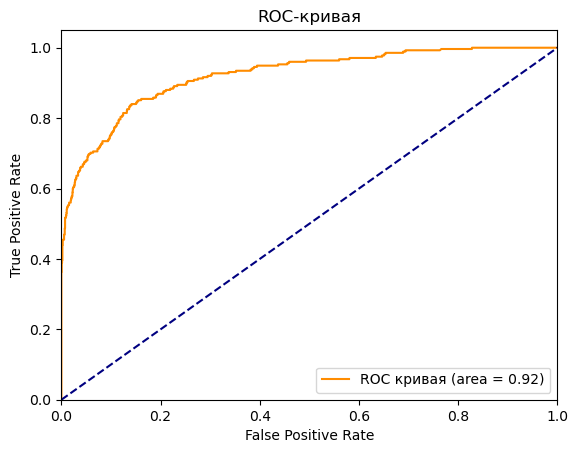

In [219]:
fpr, tpr, treshold = roc_curve(target_test, predict)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='darkorange', label='ROC кривая (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.legend(loc="lower right")
plt.show()

После исключения признаков я получила метрику еще лучше.

## Выводы:

Моя цель была научиться прогнозировать отток клиентов и на тестовых данных получить метрику AUC_ROC с точностью >= 0.85.

После предобработки и исследования данных, я выбрала таргет и необходимые признаки (gender исключила, так как он никак не влияет).

Я рассматривала три модели: ridge, randomforestclassifier и catboostclassifier. На кросс-валидации лучшую метрику дала модель catboostclassifier. Далее на тестовой выборке я получила значение 0.91 и после этого провела анализ важности признаков. После исключения двух слабо влияющих на отток клиентов признаков (PaperlessBilling и TechSupport) я получила roc-auc = 0.92, тем самым достигнув цели.